In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import KNNImputer
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [149]:
train_df = pd.read_csv("D:/Experiment/StickerForecasting/train.csv")
test_df = pd.read_csv("D:/Experiment/StickerForecasting/test.csv")

Data Pre-processing

In [144]:
train_df.shape

(230130, 6)

In [145]:
train_df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [146]:
train_df.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

Dealing with NaN Values

In [150]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [151]:
train_df = train_df.dropna()

In [152]:
train_df['Year'] = train_df['date'].dt.year
train_df['Month'] = train_df['date'].dt.month
train_df['Day'] = train_df['date'].dt.day
train_df['Weekday'] = train_df['date'].dt.day_name()

train_df

,id,date,country,store,product,num_sold,Year,Month,Day,Weekday
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,Friday
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,Friday
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,Friday
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,Friday
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,2010,1,1,Friday
...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,12,31,Saturday
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,12,31,Saturday
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,12,31,Saturday
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,12,31,Saturday


Plotting Data

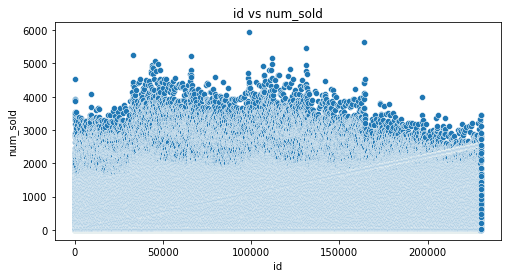

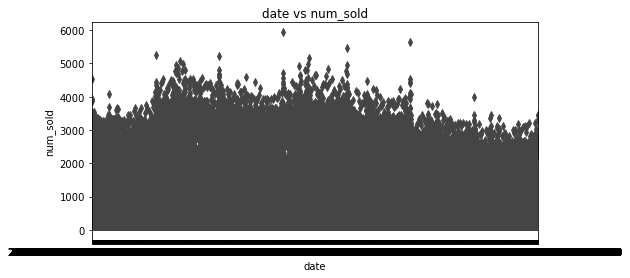

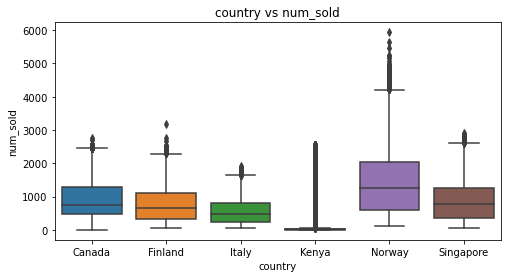

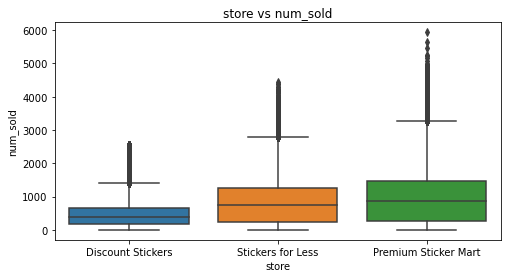

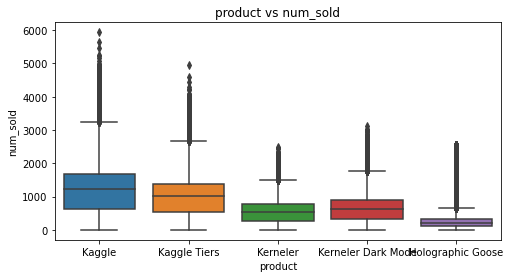

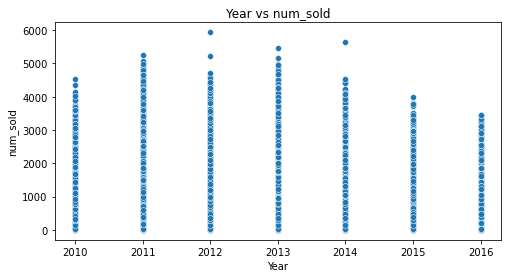

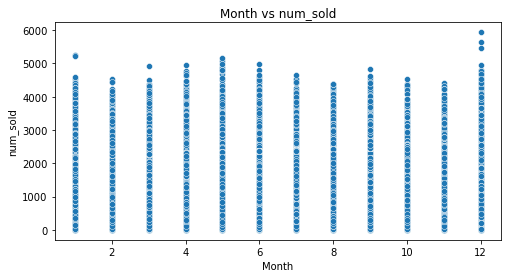

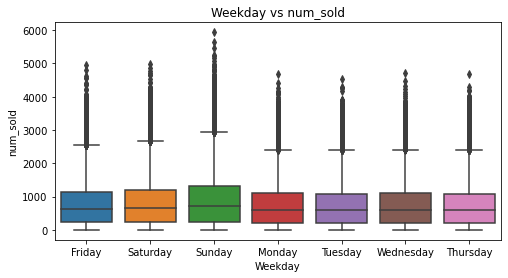

In [37]:
# Define target variable
target = 'num_sold'

# Loop through each column
for column in train_df.columns:
    if column != target and column != 'Day':  # Skip the target column itself
        plt.figure(figsize=(8, 4))
        
        # Check if the column is numerical or categorical
        if train_df[column].dtype in ['int64', 'float64']:
            # Scatter plot for numerical columns
            sns.scatterplot(data=train_df, x=column, y=target)
            plt.title(f'{column} vs {target}')
        else:
            # Box plot for categorical columns
            sns.boxplot(data=train_df, x=column, y=target)
            plt.title(f'{column} vs {target}')
        
        plt.xlabel(column)
        plt.ylabel(target)
        plt.show()

In [154]:
sample = train_df.sample(n = 221259, random_state= 42)

In [155]:
sample

,id,date,country,store,product,num_sold,Year,Month,Day,Weekday
60922,60922,2011-11-08,Singapore,Stickers for Less,Kaggle Tiers,1486.0,2011,11,8,Tuesday
10862,10862,2010-05-01,Norway,Discount Stickers,Kaggle Tiers,1015.0,2010,5,1,Saturday
47898,47898,2011-06-17,Finland,Discount Stickers,Kerneler,362.0,2011,6,17,Friday
214250,214250,2016-07-08,Kenya,Stickers for Less,Holographic Goose,5.0,2016,7,8,Friday
229502,229502,2016-12-25,Canada,Discount Stickers,Kaggle Tiers,586.0,2016,12,25,Sunday
...,...,...,...,...,...,...,...,...,...,...
125192,125192,2013-10-23,Canada,Discount Stickers,Kaggle Tiers,602.0,2013,10,23,Wednesday
108300,108300,2013-04-18,Italy,Discount Stickers,Holographic Goose,68.0,2013,4,18,Thursday
137537,137537,2014-03-09,Finland,Discount Stickers,Kaggle Tiers,767.0,2014,3,9,Sunday
153065,153065,2014-08-28,Norway,Stickers for Less,Holographic Goose,343.0,2014,8,28,Thursday


In [156]:
sample['Year'].max()

2016

In [157]:
# Create holiday mappings
holiday_mappings = {
    'Canada': holidays.CA(years=range(2010, 2025)),
    'Singapore': holidays.SG(years=range(2010, 2025)),
    'Norway': holidays.NO(years=range(2010, 2025)),
    'Finland': holidays.FI(years=range(2010, 2025)),
    'Kenya': holidays.KE(years=range(2010, 2025)),
    'Italy': holidays.IT(years=range(2010, 2025))
}


In [158]:
# Function to check if a date is a holiday
def is_holiday(date, country):
    country_holidays = holiday_mappings.get(country, None)
    if country_holidays:
        # Convert pandas datetime to Python's date object
        return 1 if date.date() in country_holidays else 0
        print(country_holidays)


In [159]:
# Apply the function to create the 'is_holiday' column
sample['is_holiday'] = sample.apply(lambda row: is_holiday(row['date'], row['country']), axis=1)

In [160]:
# Function to calculate days until the next holiday
def days_until_next_holiday(date, country):
    country_holidays = holiday_mappings.get(country, None)
    if country_holidays:
        # Convert 'date' to a datetime.date object if it's a Timestamp
        date = date.date() if isinstance(date, pd.Timestamp) else date
        # Get the future holidays (already datetime.date, no need to call .date())
        future_holidays = [d for d in country_holidays if d >= date]
        
        if future_holidays:
            next_holiday = min(future_holidays)
            return (next_holiday - date).days
    return None  # Return None if no future holidays or unsupported country

# Apply the function to create a new column
sample['days_until_holiday'] = sample.apply(lambda row: days_until_next_holiday(row['date'], row['country']), axis=1)

In [161]:
# Function to calculate days after the holiday
def days_after_holiday(date, country):
    country_holidays = holiday_mappings.get(country, None)
    if country_holidays:
        # Convert 'date' to a datetime.date object if it's a Timestamp
        date = date.date() if isinstance(date, pd.Timestamp) else date
        # Get the past holidays (already datetime.date, no need to call .date())
        past_holidays = [d for d in country_holidays if d <= date]
        
        if past_holidays:
            last_holiday = max(past_holidays)
            return (date - last_holiday).days
    return None  # Return None if no past holidays or unsupported country

sample['days_after_holiday'] = sample.apply(lambda row: days_after_holiday(row['date'], row['country']), axis=1)

In [162]:
sample

,id,date,country,store,product,num_sold,Year,Month,Day,Weekday,is_holiday,days_until_holiday,days_after_holiday
60922,60922,2011-11-08,Singapore,Stickers for Less,Kaggle Tiers,1486.0,2011,11,8,Tuesday,0,47,1
10862,10862,2010-05-01,Norway,Discount Stickers,Kaggle Tiers,1015.0,2010,5,1,Saturday,1,0,0
47898,47898,2011-06-17,Finland,Discount Stickers,Kerneler,362.0,2011,6,17,Friday,0,7,5
214250,214250,2016-07-08,Kenya,Stickers for Less,Holographic Goose,5.0,2016,7,8,Friday,0,104,37
229502,229502,2016-12-25,Canada,Discount Stickers,Kaggle Tiers,586.0,2016,12,25,Sunday,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125192,125192,2013-10-23,Canada,Discount Stickers,Kaggle Tiers,602.0,2013,10,23,Wednesday,0,63,51
108300,108300,2013-04-18,Italy,Discount Stickers,Holographic Goose,68.0,2013,4,18,Thursday,0,7,17
137537,137537,2014-03-09,Finland,Discount Stickers,Kaggle Tiers,767.0,2014,3,9,Sunday,0,40,62
153065,153065,2014-08-28,Norway,Stickers for Less,Holographic Goose,343.0,2014,8,28,Thursday,0,119,80


In [163]:
print(sample['is_holiday'].value_counts())

0    214311
1      6948
Name: is_holiday, dtype: int64


Mapping

In [164]:
# Generate a unique mapping for each country
country_mapping = {country: idx + 1 for idx, country in enumerate(sorted(sample['country'].unique()))}

# Apply the mapping to the 'Country' column
sample['country'] = sample['country'].map(country_mapping)

In [165]:
# Generate a unique mapping for each store 
store_mapping = {store: idx + 1 for idx, store in enumerate(sorted(sample['store'].unique()))}

# Apply the mapping to the 'Store' column
sample['store'] = sample['store'].map(store_mapping)

In [166]:
# Generate a unique mapping for each product
product_mapping = {product: idx + 1 for idx, product in enumerate(sorted(sample['product'].unique()))}

# Apply the mapping to the 'Product' column
sample['product'] = sample['product'].map(product_mapping)

In [167]:
# Generate a unique mapping for each weekday 
weekday_mapping = {weekday: idx + 1 for idx, weekday in enumerate(sorted(sample['Weekday'].unique()))}

# Apply the mapping to the 'Weekday' column
sample['Weekday'] = sample['Weekday'].map(weekday_mapping)

In [168]:
sample

,id,date,country,store,product,num_sold,Year,Month,Day,Weekday,is_holiday,days_until_holiday,days_after_holiday
60922,60922,2011-11-08,6,3,3,1486.0,2011,11,8,6,0,47,1
10862,10862,2010-05-01,5,1,3,1015.0,2010,5,1,3,1,0,0
47898,47898,2011-06-17,2,1,4,362.0,2011,6,17,1,0,7,5
214250,214250,2016-07-08,4,3,1,5.0,2016,7,8,1,0,104,37
229502,229502,2016-12-25,1,1,3,586.0,2016,12,25,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125192,125192,2013-10-23,1,1,3,602.0,2013,10,23,7,0,63,51
108300,108300,2013-04-18,3,1,1,68.0,2013,4,18,5,0,7,17
137537,137537,2014-03-09,2,1,3,767.0,2014,3,9,4,0,40,62
153065,153065,2014-08-28,5,3,1,343.0,2014,8,28,5,0,119,80


In [169]:
#(modifies the sample DataFrame)
sample.drop(columns=['id', 'date'], inplace=True)

Model Making

In [200]:
X = sample[['country', 'store', 'product', 'Year','Weekday','Month', 'days_until_holiday', 'days_after_holiday']]
y = sample['num_sold']

In [201]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [202]:
# Apply Standardization
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [173]:
# Calculate mutual information for the training data
mi_scores = mutual_info_regression(X_train, y_train, random_state=42)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({"Feature": X_train.columns, "MI Score": mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)

print(mi_df)

# Select top features based on a threshold or top-k
threshold = 0.001  # Adjust this threshold
selected_features = mi_df[mi_df["MI Score"] > threshold]["Feature"]
print("Selected Features:", selected_features.tolist())

              Feature  MI Score
2             product  0.399066
0             country  0.338272
1               store  0.177004
3                Year  0.026676
6  days_until_holiday  0.021689
7  days_after_holiday  0.021224
5               Month  0.005660
4             Weekday  0.000240
Selected Features: ['product', 'country', 'store', 'Year', 'days_until_holiday', 'days_after_holiday', 'Month', 'Weekday']


In [174]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

In [208]:
# Define the KNN model
#knn_model = KNeighborsRegressor(n_neighbors=2, weights='distance')  # Use distance-weighted KNN

# Fit the model
#knn_model.fit(X_train_scaled, y_train)

# Predict
#y_pred = knn_model.predict(X_test_scaled)

# Evaluate
#rmse = mean_squared_error(y_test, y_pred, squared=False)
#mape = mean_absolute_percentage_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)

#print(f"Validation RMSE: {rmse}")
#print(f"Validation MAPE: {mape}")
#print(f"Validation R²: {r2}")

Validation RMSE: 94.26882759865398
Validation MAPE: 9.562762813494306
Validation R²: 0.9813992431170686


In [175]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{name} - MAPE: {mape:.2f}%")

Linear Regression - MAPE: 903.73%
Decision Tree - MAPE: 6.63%
Random Forest - MAPE: 5.12%
Gradient Boosting - MAPE: 183.18%


In [181]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Train the model 
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f"MAPE: {mape:.2f}%")

Mean Squared Error: 4428.10
R^2 Score: 0.99
MAPE: 5.12%


In [187]:
# 3. **CatBoost**
#cat_reg = cb.CatBoostRegressor(iterations=100, depth=10, learning_rate=0.1, loss_function='RMSE', verbose=0)
#cat_reg.fit(X_train, y_train)
model = cb.CatBoostRegressor(loss_function='MAPE')

grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'iterations': [500, 1000]
}

grid_result = model.grid_search(grid, X=X_train, y=y_train)
# Predictions
cat_pred = model.predict(X_test)
cat_mse = mean_squared_error(y_test, cat_pred)
cat_r2 = r2_score(y_test, cat_pred)
mape = mean_absolute_percentage_error(y_test, cat_pred)
# Display best parameters
print("Best Parameters:", grid_result['params'])
print(f'CatBoost Mean Squared Error: {cat_mse}')
print(f'CatBoost R^2 Score: {cat_r2}')
print(f"MAPE: {mape:.2f}%")

0:	learn: 0.9905287	test: 0.9905316	best: 0.9905316 (0)	total: 15.4ms	remaining: 7.67s
1:	learn: 0.9811294	test: 0.9811361	best: 0.9811361 (1)	total: 29.5ms	remaining: 7.36s
2:	learn: 0.9718297	test: 0.9718403	best: 0.9718403 (2)	total: 42.8ms	remaining: 7.08s
3:	learn: 0.9626594	test: 0.9626728	best: 0.9626728 (3)	total: 57.2ms	remaining: 7.09s
4:	learn: 0.9535859	test: 0.9536022	best: 0.9536022 (4)	total: 70.2ms	remaining: 6.94s
5:	learn: 0.9446128	test: 0.9446319	best: 0.9446319 (5)	total: 83.7ms	remaining: 6.89s
6:	learn: 0.9357092	test: 0.9357321	best: 0.9357321 (6)	total: 96.8ms	remaining: 6.82s
7:	learn: 0.9268964	test: 0.9269235	best: 0.9269235 (7)	total: 110ms	remaining: 6.75s
8:	learn: 0.9181923	test: 0.9182206	best: 0.9182206 (8)	total: 125ms	remaining: 6.8s
9:	learn: 0.9095843	test: 0.9096130	best: 0.9096130 (9)	total: 137ms	remaining: 6.73s
10:	learn: 0.9010752	test: 0.9011034	best: 0.9011034 (10)	total: 150ms	remaining: 6.66s
11:	learn: 0.8926670	test: 0.8926980	best: 0.8

106:	learn: 0.4251118	test: 0.4252550	best: 0.4252550 (106)	total: 1.48s	remaining: 5.43s
107:	learn: 0.4232115	test: 0.4233576	best: 0.4233576 (107)	total: 1.49s	remaining: 5.42s
108:	learn: 0.4213262	test: 0.4214752	best: 0.4214752 (108)	total: 1.51s	remaining: 5.42s
109:	learn: 0.4192962	test: 0.4194540	best: 0.4194540 (109)	total: 1.52s	remaining: 5.41s
110:	learn: 0.4175352	test: 0.4176941	best: 0.4176941 (110)	total: 1.54s	remaining: 5.39s
111:	learn: 0.4158011	test: 0.4159634	best: 0.4159634 (111)	total: 1.55s	remaining: 5.37s
112:	learn: 0.4140772	test: 0.4142397	best: 0.4142397 (112)	total: 1.56s	remaining: 5.36s
113:	learn: 0.4124550	test: 0.4126203	best: 0.4126203 (113)	total: 1.58s	remaining: 5.34s
114:	learn: 0.4106031	test: 0.4107609	best: 0.4107609 (114)	total: 1.59s	remaining: 5.32s
115:	learn: 0.4090983	test: 0.4092608	best: 0.4092608 (115)	total: 1.6s	remaining: 5.3s
116:	learn: 0.4076694	test: 0.4078333	best: 0.4078333 (116)	total: 1.61s	remaining: 5.29s
117:	learn: 

208:	learn: 0.3433943	test: 0.3437400	best: 0.3437400 (208)	total: 2.88s	remaining: 4.01s
209:	learn: 0.3430888	test: 0.3434373	best: 0.3434373 (209)	total: 2.9s	remaining: 4.01s
210:	learn: 0.3423688	test: 0.3427264	best: 0.3427264 (210)	total: 2.92s	remaining: 4s
211:	learn: 0.3416826	test: 0.3420397	best: 0.3420397 (211)	total: 2.93s	remaining: 3.98s
212:	learn: 0.3409711	test: 0.3413240	best: 0.3413240 (212)	total: 2.95s	remaining: 3.97s
213:	learn: 0.3406329	test: 0.3409876	best: 0.3409876 (213)	total: 2.96s	remaining: 3.96s
214:	learn: 0.3403362	test: 0.3406935	best: 0.3406935 (214)	total: 2.98s	remaining: 3.95s
215:	learn: 0.3400457	test: 0.3404064	best: 0.3404064 (215)	total: 3s	remaining: 3.94s
216:	learn: 0.3397145	test: 0.3400772	best: 0.3400772 (216)	total: 3.02s	remaining: 3.93s
217:	learn: 0.3391256	test: 0.3394825	best: 0.3394825 (217)	total: 3.03s	remaining: 3.92s
218:	learn: 0.3387415	test: 0.3391015	best: 0.3391015 (218)	total: 3.05s	remaining: 3.91s
219:	learn: 0.338

315:	learn: 0.3042834	test: 0.3047360	best: 0.3047360 (315)	total: 4.3s	remaining: 2.51s
316:	learn: 0.3041292	test: 0.3045848	best: 0.3045848 (316)	total: 4.32s	remaining: 2.49s
317:	learn: 0.3037949	test: 0.3042555	best: 0.3042555 (317)	total: 4.33s	remaining: 2.48s
318:	learn: 0.3036453	test: 0.3041087	best: 0.3041087 (318)	total: 4.34s	remaining: 2.46s
319:	learn: 0.3035244	test: 0.3039895	best: 0.3039895 (319)	total: 4.36s	remaining: 2.45s
320:	learn: 0.3033775	test: 0.3038454	best: 0.3038454 (320)	total: 4.37s	remaining: 2.44s
321:	learn: 0.3030650	test: 0.3035372	best: 0.3035372 (321)	total: 4.38s	remaining: 2.42s
322:	learn: 0.3029204	test: 0.3033952	best: 0.3033952 (322)	total: 4.4s	remaining: 2.41s
323:	learn: 0.3027238	test: 0.3032021	best: 0.3032021 (323)	total: 4.41s	remaining: 2.4s
324:	learn: 0.3022677	test: 0.3027519	best: 0.3027519 (324)	total: 4.42s	remaining: 2.38s
325:	learn: 0.3021257	test: 0.3026124	best: 0.3026124 (325)	total: 4.44s	remaining: 2.37s
326:	learn: 0

411:	learn: 0.2851062	test: 0.2857647	best: 0.2857647 (411)	total: 5.73s	remaining: 1.22s
412:	learn: 0.2849473	test: 0.2856065	best: 0.2856065 (412)	total: 5.74s	remaining: 1.21s
413:	learn: 0.2848801	test: 0.2855397	best: 0.2855397 (413)	total: 5.76s	remaining: 1.2s
414:	learn: 0.2846603	test: 0.2853227	best: 0.2853227 (414)	total: 5.78s	remaining: 1.18s
415:	learn: 0.2844476	test: 0.2851106	best: 0.2851106 (415)	total: 5.79s	remaining: 1.17s
416:	learn: 0.2843811	test: 0.2850445	best: 0.2850445 (416)	total: 5.81s	remaining: 1.16s
417:	learn: 0.2843017	test: 0.2849663	best: 0.2849663 (417)	total: 5.82s	remaining: 1.14s
418:	learn: 0.2842233	test: 0.2848891	best: 0.2848891 (418)	total: 5.84s	remaining: 1.13s
419:	learn: 0.2841451	test: 0.2848122	best: 0.2848122 (419)	total: 5.85s	remaining: 1.11s
420:	learn: 0.2839947	test: 0.2846627	best: 0.2846627 (420)	total: 5.87s	remaining: 1.1s
421:	learn: 0.2839297	test: 0.2845981	best: 0.2845981 (421)	total: 5.88s	remaining: 1.09s
422:	learn: 

7:	learn: 0.6857237	test: 0.6858506	best: 0.6858506 (7)	total: 114ms	remaining: 7.03s
8:	learn: 0.6557392	test: 0.6558694	best: 0.6558694 (8)	total: 127ms	remaining: 6.94s
9:	learn: 0.6275612	test: 0.6276942	best: 0.6276942 (9)	total: 142ms	remaining: 6.95s
10:	learn: 0.6011436	test: 0.6012739	best: 0.6012739 (10)	total: 154ms	remaining: 6.83s
11:	learn: 0.5764002	test: 0.5765452	best: 0.5765452 (11)	total: 166ms	remaining: 6.73s
12:	learn: 0.5532331	test: 0.5533934	best: 0.5533934 (12)	total: 178ms	remaining: 6.65s
13:	learn: 0.5316097	test: 0.5317856	best: 0.5317856 (13)	total: 190ms	remaining: 6.58s
14:	learn: 0.5116500	test: 0.5118329	best: 0.5118329 (14)	total: 202ms	remaining: 6.53s
15:	learn: 0.4934684	test: 0.4936586	best: 0.4936586 (15)	total: 214ms	remaining: 6.47s
16:	learn: 0.4768541	test: 0.4770687	best: 0.4770687 (16)	total: 226ms	remaining: 6.43s
17:	learn: 0.4621020	test: 0.4623178	best: 0.4623178 (17)	total: 238ms	remaining: 6.38s
18:	learn: 0.4490391	test: 0.4492809	b

111:	learn: 0.2540985	test: 0.2548319	best: 0.2548319 (111)	total: 1.52s	remaining: 5.27s
112:	learn: 0.2538231	test: 0.2545543	best: 0.2545543 (112)	total: 1.53s	remaining: 5.26s
113:	learn: 0.2531713	test: 0.2539014	best: 0.2539014 (113)	total: 1.55s	remaining: 5.24s
114:	learn: 0.2525611	test: 0.2532962	best: 0.2532962 (114)	total: 1.56s	remaining: 5.22s
115:	learn: 0.2520883	test: 0.2528245	best: 0.2528245 (115)	total: 1.57s	remaining: 5.2s
116:	learn: 0.2516068	test: 0.2523498	best: 0.2523498 (116)	total: 1.58s	remaining: 5.18s
117:	learn: 0.2513833	test: 0.2521266	best: 0.2521266 (117)	total: 1.59s	remaining: 5.16s
118:	learn: 0.2510258	test: 0.2517719	best: 0.2517719 (118)	total: 1.61s	remaining: 5.14s
119:	learn: 0.2502153	test: 0.2509749	best: 0.2509749 (119)	total: 1.62s	remaining: 5.13s
120:	learn: 0.2496949	test: 0.2504547	best: 0.2504547 (120)	total: 1.63s	remaining: 5.11s
121:	learn: 0.2494846	test: 0.2502429	best: 0.2502429 (121)	total: 1.64s	remaining: 5.09s
122:	learn:

212:	learn: 0.2015080	test: 0.2017604	best: 0.2017604 (212)	total: 2.75s	remaining: 3.7s
213:	learn: 0.2011718	test: 0.2014182	best: 0.2014182 (213)	total: 2.76s	remaining: 3.69s
214:	learn: 0.2009876	test: 0.2012322	best: 0.2012322 (214)	total: 2.77s	remaining: 3.67s
215:	learn: 0.2005323	test: 0.2007670	best: 0.2007670 (215)	total: 2.79s	remaining: 3.66s
216:	learn: 0.2003946	test: 0.2006285	best: 0.2006285 (216)	total: 2.8s	remaining: 3.65s
217:	learn: 0.2001149	test: 0.2003510	best: 0.2003510 (217)	total: 2.81s	remaining: 3.64s
218:	learn: 0.1996126	test: 0.1998418	best: 0.1998418 (218)	total: 2.83s	remaining: 3.63s
219:	learn: 0.1991897	test: 0.1994231	best: 0.1994231 (219)	total: 2.84s	remaining: 3.61s
220:	learn: 0.1990861	test: 0.1993191	best: 0.1993191 (220)	total: 2.85s	remaining: 3.6s
221:	learn: 0.1982115	test: 0.1984142	best: 0.1984142 (221)	total: 2.86s	remaining: 3.58s
222:	learn: 0.1980784	test: 0.1982814	best: 0.1982814 (222)	total: 2.87s	remaining: 3.57s
223:	learn: 0

304:	learn: 0.1753679	test: 0.1752957	best: 0.1752957 (304)	total: 3.94s	remaining: 2.52s
305:	learn: 0.1752138	test: 0.1751390	best: 0.1751390 (305)	total: 3.95s	remaining: 2.51s
306:	learn: 0.1751293	test: 0.1750537	best: 0.1750537 (306)	total: 3.97s	remaining: 2.49s
307:	learn: 0.1750324	test: 0.1749565	best: 0.1749565 (307)	total: 3.98s	remaining: 2.48s
308:	learn: 0.1747991	test: 0.1747244	best: 0.1747244 (308)	total: 3.99s	remaining: 2.47s
309:	learn: 0.1747290	test: 0.1746533	best: 0.1746533 (309)	total: 4.01s	remaining: 2.46s
310:	learn: 0.1746334	test: 0.1745572	best: 0.1745572 (310)	total: 4.02s	remaining: 2.44s
311:	learn: 0.1745382	test: 0.1744616	best: 0.1744616 (311)	total: 4.03s	remaining: 2.43s
312:	learn: 0.1742275	test: 0.1741519	best: 0.1741519 (312)	total: 4.05s	remaining: 2.42s
313:	learn: 0.1741604	test: 0.1740832	best: 0.1740832 (313)	total: 4.06s	remaining: 2.4s
314:	learn: 0.1740560	test: 0.1739786	best: 0.1739786 (314)	total: 4.07s	remaining: 2.39s
315:	learn:

397:	learn: 0.1658804	test: 0.1657847	best: 0.1657847 (397)	total: 5.33s	remaining: 1.36s
398:	learn: 0.1658317	test: 0.1657357	best: 0.1657357 (398)	total: 5.34s	remaining: 1.35s
399:	learn: 0.1657812	test: 0.1656857	best: 0.1656857 (399)	total: 5.36s	remaining: 1.34s
400:	learn: 0.1657355	test: 0.1656386	best: 0.1656386 (400)	total: 5.37s	remaining: 1.33s
401:	learn: 0.1656877	test: 0.1655906	best: 0.1655906 (401)	total: 5.38s	remaining: 1.31s
402:	learn: 0.1656314	test: 0.1655349	best: 0.1655349 (402)	total: 5.39s	remaining: 1.3s
403:	learn: 0.1655729	test: 0.1654750	best: 0.1654750 (403)	total: 5.41s	remaining: 1.28s
404:	learn: 0.1655264	test: 0.1654287	best: 0.1654287 (404)	total: 5.42s	remaining: 1.27s
405:	learn: 0.1654676	test: 0.1653685	best: 0.1653685 (405)	total: 5.43s	remaining: 1.26s
406:	learn: 0.1652665	test: 0.1651701	best: 0.1651701 (406)	total: 5.44s	remaining: 1.24s
407:	learn: 0.1652120	test: 0.1651152	best: 0.1651152 (407)	total: 5.46s	remaining: 1.23s
408:	learn:

495:	learn: 0.1591688	test: 0.1590822	best: 0.1590822 (495)	total: 6.81s	remaining: 54.9ms
496:	learn: 0.1591302	test: 0.1590469	best: 0.1590469 (496)	total: 6.82s	remaining: 41.2ms
497:	learn: 0.1590929	test: 0.1590081	best: 0.1590081 (497)	total: 6.84s	remaining: 27.5ms
498:	learn: 0.1590360	test: 0.1589527	best: 0.1589527 (498)	total: 6.86s	remaining: 13.7ms
499:	learn: 0.1589796	test: 0.1588955	best: 0.1588955 (499)	total: 6.87s	remaining: 0us

bestTest = 0.1588955111
bestIteration = 499

1:	loss: 0.1588955	best: 0.1588955 (1)	total: 14.2s	remaining: 1m 53s
0:	learn: 0.9052870	test: 0.9053161	best: 0.9053161 (0)	total: 19.7ms	remaining: 9.81s
1:	learn: 0.8205061	test: 0.8205746	best: 0.8205746 (1)	total: 36.9ms	remaining: 9.18s
2:	learn: 0.7450527	test: 0.7451537	best: 0.7451537 (2)	total: 52ms	remaining: 8.62s
3:	learn: 0.6785051	test: 0.6786314	best: 0.6786314 (3)	total: 67ms	remaining: 8.31s
4:	learn: 0.6197174	test: 0.6198692	best: 0.6198692 (4)	total: 82.8ms	remaining: 8.2s
5:

87:	learn: 0.2369589	test: 0.2375379	best: 0.2375379 (87)	total: 1.31s	remaining: 6.16s
88:	learn: 0.2366677	test: 0.2372417	best: 0.2372417 (88)	total: 1.33s	remaining: 6.15s
89:	learn: 0.2355015	test: 0.2360607	best: 0.2360607 (89)	total: 1.35s	remaining: 6.13s
90:	learn: 0.2291191	test: 0.2295828	best: 0.2295828 (90)	total: 1.36s	remaining: 6.13s
91:	learn: 0.2287569	test: 0.2292252	best: 0.2292252 (91)	total: 1.38s	remaining: 6.13s
92:	learn: 0.2278484	test: 0.2283041	best: 0.2283041 (92)	total: 1.4s	remaining: 6.13s
93:	learn: 0.2261883	test: 0.2266531	best: 0.2266531 (93)	total: 1.42s	remaining: 6.13s
94:	learn: 0.2248382	test: 0.2253209	best: 0.2253209 (94)	total: 1.44s	remaining: 6.14s
95:	learn: 0.2212709	test: 0.2217233	best: 0.2217233 (95)	total: 1.46s	remaining: 6.15s
96:	learn: 0.2209104	test: 0.2213557	best: 0.2213557 (96)	total: 1.48s	remaining: 6.14s
97:	learn: 0.2184214	test: 0.2187934	best: 0.2187934 (97)	total: 1.5s	remaining: 6.14s
98:	learn: 0.2181048	test: 0.21847

189:	learn: 0.1747045	test: 0.1747759	best: 0.1747759 (189)	total: 3.19s	remaining: 5.2s
190:	learn: 0.1745912	test: 0.1746599	best: 0.1746599 (190)	total: 3.21s	remaining: 5.19s
191:	learn: 0.1743499	test: 0.1744145	best: 0.1744145 (191)	total: 3.23s	remaining: 5.18s
192:	learn: 0.1742407	test: 0.1743045	best: 0.1743045 (192)	total: 3.25s	remaining: 5.16s
193:	learn: 0.1741339	test: 0.1741968	best: 0.1741968 (193)	total: 3.26s	remaining: 5.15s
194:	learn: 0.1739981	test: 0.1740627	best: 0.1740627 (194)	total: 3.29s	remaining: 5.14s
195:	learn: 0.1738828	test: 0.1739471	best: 0.1739471 (195)	total: 3.31s	remaining: 5.13s
196:	learn: 0.1737701	test: 0.1738343	best: 0.1738343 (196)	total: 3.33s	remaining: 5.12s
197:	learn: 0.1736711	test: 0.1737329	best: 0.1737329 (197)	total: 3.35s	remaining: 5.11s
198:	learn: 0.1734151	test: 0.1734794	best: 0.1734794 (198)	total: 3.37s	remaining: 5.1s
199:	learn: 0.1732915	test: 0.1733526	best: 0.1733526 (199)	total: 3.4s	remaining: 5.09s
200:	learn: 0

285:	learn: 0.1627079	test: 0.1628303	best: 0.1628303 (285)	total: 5.11s	remaining: 3.83s
286:	learn: 0.1626336	test: 0.1627567	best: 0.1627567 (286)	total: 5.13s	remaining: 3.81s
287:	learn: 0.1625420	test: 0.1626651	best: 0.1626651 (287)	total: 5.15s	remaining: 3.79s
288:	learn: 0.1624240	test: 0.1625462	best: 0.1625462 (288)	total: 5.16s	remaining: 3.77s
289:	learn: 0.1623332	test: 0.1624554	best: 0.1624554 (289)	total: 5.18s	remaining: 3.75s
290:	learn: 0.1622690	test: 0.1623925	best: 0.1623925 (290)	total: 5.2s	remaining: 3.73s
291:	learn: 0.1622113	test: 0.1623346	best: 0.1623346 (291)	total: 5.21s	remaining: 3.71s
292:	learn: 0.1621326	test: 0.1622597	best: 0.1622597 (292)	total: 5.23s	remaining: 3.7s
293:	learn: 0.1620320	test: 0.1621586	best: 0.1621586 (293)	total: 5.25s	remaining: 3.68s
294:	learn: 0.1619299	test: 0.1620572	best: 0.1620572 (294)	total: 5.27s	remaining: 3.66s
295:	learn: 0.1618702	test: 0.1619958	best: 0.1619958 (295)	total: 5.29s	remaining: 3.65s
296:	learn: 

381:	learn: 0.1518918	test: 0.1520336	best: 0.1520336 (381)	total: 7.01s	remaining: 2.17s
382:	learn: 0.1518377	test: 0.1519850	best: 0.1519850 (382)	total: 7.03s	remaining: 2.15s
383:	learn: 0.1517686	test: 0.1519155	best: 0.1519155 (383)	total: 7.05s	remaining: 2.13s
384:	learn: 0.1517166	test: 0.1518638	best: 0.1518638 (384)	total: 7.07s	remaining: 2.11s
385:	learn: 0.1516554	test: 0.1518033	best: 0.1518033 (385)	total: 7.09s	remaining: 2.09s
386:	learn: 0.1515812	test: 0.1517287	best: 0.1517287 (386)	total: 7.11s	remaining: 2.08s
387:	learn: 0.1515367	test: 0.1516838	best: 0.1516838 (387)	total: 7.13s	remaining: 2.06s
388:	learn: 0.1514911	test: 0.1516389	best: 0.1516389 (388)	total: 7.15s	remaining: 2.04s
389:	learn: 0.1514446	test: 0.1515925	best: 0.1515925 (389)	total: 7.17s	remaining: 2.02s
390:	learn: 0.1513973	test: 0.1515500	best: 0.1515500 (390)	total: 7.19s	remaining: 2s
391:	learn: 0.1513250	test: 0.1514773	best: 0.1514773 (391)	total: 7.21s	remaining: 1.99s
392:	learn: 0

477:	learn: 0.1458022	test: 0.1459977	best: 0.1459977 (477)	total: 8.92s	remaining: 410ms
478:	learn: 0.1457790	test: 0.1459773	best: 0.1459773 (478)	total: 8.94s	remaining: 392ms
479:	learn: 0.1457455	test: 0.1459448	best: 0.1459448 (479)	total: 8.95s	remaining: 373ms
480:	learn: 0.1457052	test: 0.1459033	best: 0.1459033 (480)	total: 8.97s	remaining: 354ms
481:	learn: 0.1456168	test: 0.1458175	best: 0.1458175 (481)	total: 8.99s	remaining: 336ms
482:	learn: 0.1455841	test: 0.1457847	best: 0.1457847 (482)	total: 9.01s	remaining: 317ms
483:	learn: 0.1455605	test: 0.1457632	best: 0.1457632 (483)	total: 9.02s	remaining: 298ms
484:	learn: 0.1455374	test: 0.1457422	best: 0.1457422 (484)	total: 9.04s	remaining: 280ms
485:	learn: 0.1449093	test: 0.1450634	best: 0.1450634 (485)	total: 9.06s	remaining: 261ms
486:	learn: 0.1448886	test: 0.1450440	best: 0.1450440 (486)	total: 9.08s	remaining: 242ms
487:	learn: 0.1447373	test: 0.1448987	best: 0.1448987 (487)	total: 9.1s	remaining: 224ms
488:	learn:

74:	learn: 0.5171846	test: 0.5172898	best: 0.5172898 (74)	total: 1.41s	remaining: 17.3s
75:	learn: 0.5133240	test: 0.5134344	best: 0.5134344 (75)	total: 1.43s	remaining: 17.3s
76:	learn: 0.5095586	test: 0.5096735	best: 0.5096735 (76)	total: 1.44s	remaining: 17.3s
77:	learn: 0.5057945	test: 0.5059152	best: 0.5059152 (77)	total: 1.46s	remaining: 17.3s
78:	learn: 0.5021718	test: 0.5022976	best: 0.5022976 (78)	total: 1.48s	remaining: 17.2s
79:	learn: 0.4985267	test: 0.4986490	best: 0.4986490 (79)	total: 1.49s	remaining: 17.2s
80:	learn: 0.4950550	test: 0.4951794	best: 0.4951794 (80)	total: 1.51s	remaining: 17.1s
81:	learn: 0.4915772	test: 0.4916965	best: 0.4916965 (81)	total: 1.53s	remaining: 17.1s
82:	learn: 0.4881240	test: 0.4882362	best: 0.4882362 (82)	total: 1.54s	remaining: 17s
83:	learn: 0.4848359	test: 0.4849524	best: 0.4849524 (83)	total: 1.56s	remaining: 17s
84:	learn: 0.4815575	test: 0.4816702	best: 0.4816702 (84)	total: 1.57s	remaining: 16.9s
85:	learn: 0.4784513	test: 0.4785637

176:	learn: 0.3586614	test: 0.3589652	best: 0.3589652 (176)	total: 3.27s	remaining: 15.2s
177:	learn: 0.3582656	test: 0.3585713	best: 0.3585713 (177)	total: 3.28s	remaining: 15.2s
178:	learn: 0.3578777	test: 0.3581852	best: 0.3581852 (178)	total: 3.3s	remaining: 15.1s
179:	learn: 0.3574029	test: 0.3577126	best: 0.3577126 (179)	total: 3.32s	remaining: 15.1s
180:	learn: 0.3570199	test: 0.3573318	best: 0.3573318 (180)	total: 3.34s	remaining: 15.1s
181:	learn: 0.3555893	test: 0.3558892	best: 0.3558892 (181)	total: 3.36s	remaining: 15.1s
182:	learn: 0.3551509	test: 0.3554541	best: 0.3554541 (182)	total: 3.38s	remaining: 15.1s
183:	learn: 0.3546158	test: 0.3549220	best: 0.3549220 (183)	total: 3.39s	remaining: 15.1s
184:	learn: 0.3541324	test: 0.3544403	best: 0.3544403 (184)	total: 3.41s	remaining: 15s
185:	learn: 0.3532702	test: 0.3535773	best: 0.3535773 (185)	total: 3.43s	remaining: 15s
186:	learn: 0.3527769	test: 0.3530899	best: 0.3530899 (186)	total: 3.45s	remaining: 15s
187:	learn: 0.352

269:	learn: 0.3178217	test: 0.3181654	best: 0.3181654 (269)	total: 5.1s	remaining: 13.8s
270:	learn: 0.3173279	test: 0.3176692	best: 0.3176692 (270)	total: 5.11s	remaining: 13.8s
271:	learn: 0.3171056	test: 0.3174490	best: 0.3174490 (271)	total: 5.13s	remaining: 13.7s
272:	learn: 0.3168599	test: 0.3172066	best: 0.3172066 (272)	total: 5.15s	remaining: 13.7s
273:	learn: 0.3166695	test: 0.3170162	best: 0.3170162 (273)	total: 5.17s	remaining: 13.7s
274:	learn: 0.3162132	test: 0.3165612	best: 0.3165612 (274)	total: 5.2s	remaining: 13.7s
275:	learn: 0.3160166	test: 0.3163640	best: 0.3163640 (275)	total: 5.22s	remaining: 13.7s
276:	learn: 0.3157829	test: 0.3161316	best: 0.3161316 (276)	total: 5.24s	remaining: 13.7s
277:	learn: 0.3150187	test: 0.3153724	best: 0.3153724 (277)	total: 5.25s	remaining: 13.6s
278:	learn: 0.3145919	test: 0.3149487	best: 0.3149487 (278)	total: 5.28s	remaining: 13.6s
279:	learn: 0.3140063	test: 0.3143698	best: 0.3143698 (279)	total: 5.3s	remaining: 13.6s
280:	learn: 0

363:	learn: 0.2925660	test: 0.2931657	best: 0.2931657 (363)	total: 6.97s	remaining: 12.2s
364:	learn: 0.2922516	test: 0.2928536	best: 0.2928536 (364)	total: 6.99s	remaining: 12.2s
365:	learn: 0.2921436	test: 0.2927473	best: 0.2927473 (365)	total: 7.01s	remaining: 12.1s
366:	learn: 0.2920361	test: 0.2926425	best: 0.2926425 (366)	total: 7.04s	remaining: 12.1s
367:	learn: 0.2919311	test: 0.2925394	best: 0.2925394 (367)	total: 7.06s	remaining: 12.1s
368:	learn: 0.2916896	test: 0.2923004	best: 0.2923004 (368)	total: 7.08s	remaining: 12.1s
369:	learn: 0.2915754	test: 0.2921866	best: 0.2921866 (369)	total: 7.1s	remaining: 12.1s
370:	learn: 0.2913352	test: 0.2919490	best: 0.2919490 (370)	total: 7.12s	remaining: 12.1s
371:	learn: 0.2910998	test: 0.2917163	best: 0.2917163 (371)	total: 7.14s	remaining: 12.1s
372:	learn: 0.2908721	test: 0.2914909	best: 0.2914909 (372)	total: 7.16s	remaining: 12s
373:	learn: 0.2906571	test: 0.2912779	best: 0.2912779 (373)	total: 7.18s	remaining: 12s
374:	learn: 0.2

458:	learn: 0.2782528	test: 0.2789509	best: 0.2789509 (458)	total: 9.03s	remaining: 10.6s
459:	learn: 0.2781034	test: 0.2788029	best: 0.2788029 (459)	total: 9.05s	remaining: 10.6s
460:	learn: 0.2779594	test: 0.2786604	best: 0.2786604 (460)	total: 9.07s	remaining: 10.6s
461:	learn: 0.2778232	test: 0.2785256	best: 0.2785256 (461)	total: 9.09s	remaining: 10.6s
462:	learn: 0.2776211	test: 0.2783244	best: 0.2783244 (462)	total: 9.11s	remaining: 10.6s
463:	learn: 0.2775560	test: 0.2782602	best: 0.2782602 (463)	total: 9.13s	remaining: 10.5s
464:	learn: 0.2773165	test: 0.2780255	best: 0.2780255 (464)	total: 9.15s	remaining: 10.5s
465:	learn: 0.2772533	test: 0.2779631	best: 0.2779631 (465)	total: 9.17s	remaining: 10.5s
466:	learn: 0.2771358	test: 0.2778450	best: 0.2778450 (466)	total: 9.19s	remaining: 10.5s
467:	learn: 0.2770527	test: 0.2777593	best: 0.2777593 (467)	total: 9.21s	remaining: 10.5s
468:	learn: 0.2769899	test: 0.2776972	best: 0.2776972 (468)	total: 9.23s	remaining: 10.5s
469:	learn

560:	learn: 0.2655846	test: 0.2663184	best: 0.2663184 (560)	total: 11.1s	remaining: 8.7s
561:	learn: 0.2654604	test: 0.2661939	best: 0.2661939 (561)	total: 11.1s	remaining: 8.68s
562:	learn: 0.2653504	test: 0.2660854	best: 0.2660854 (562)	total: 11.2s	remaining: 8.66s
563:	learn: 0.2652388	test: 0.2659740	best: 0.2659740 (563)	total: 11.2s	remaining: 8.64s
564:	learn: 0.2651419	test: 0.2658781	best: 0.2658781 (564)	total: 11.2s	remaining: 8.62s
565:	learn: 0.2649444	test: 0.2656788	best: 0.2656788 (565)	total: 11.2s	remaining: 8.6s
566:	learn: 0.2648397	test: 0.2655744	best: 0.2655744 (566)	total: 11.2s	remaining: 8.58s
567:	learn: 0.2647027	test: 0.2654391	best: 0.2654391 (567)	total: 11.3s	remaining: 8.56s
568:	learn: 0.2646049	test: 0.2653417	best: 0.2653417 (568)	total: 11.3s	remaining: 8.54s
569:	learn: 0.2644147	test: 0.2651499	best: 0.2651499 (569)	total: 11.3s	remaining: 8.52s
570:	learn: 0.2643181	test: 0.2650537	best: 0.2650537 (570)	total: 11.3s	remaining: 8.5s
571:	learn: 0

655:	learn: 0.2542006	test: 0.2548965	best: 0.2548965 (655)	total: 13s	remaining: 6.82s
656:	learn: 0.2541139	test: 0.2548093	best: 0.2548093 (656)	total: 13s	remaining: 6.79s
657:	learn: 0.2539108	test: 0.2546039	best: 0.2546039 (657)	total: 13s	remaining: 6.77s
658:	learn: 0.2538284	test: 0.2545226	best: 0.2545226 (658)	total: 13.1s	remaining: 6.75s
659:	learn: 0.2537545	test: 0.2544485	best: 0.2544485 (659)	total: 13.1s	remaining: 6.73s
660:	learn: 0.2536847	test: 0.2543788	best: 0.2543788 (660)	total: 13.1s	remaining: 6.71s
661:	learn: 0.2535610	test: 0.2542541	best: 0.2542541 (661)	total: 13.1s	remaining: 6.7s
662:	learn: 0.2535125	test: 0.2542053	best: 0.2542053 (662)	total: 13.1s	remaining: 6.67s
663:	learn: 0.2534492	test: 0.2541424	best: 0.2541424 (663)	total: 13.2s	remaining: 6.66s
664:	learn: 0.2534046	test: 0.2540974	best: 0.2540974 (664)	total: 13.2s	remaining: 6.63s
665:	learn: 0.2533212	test: 0.2540155	best: 0.2540155 (665)	total: 13.2s	remaining: 6.62s
666:	learn: 0.253

751:	learn: 0.2466001	test: 0.2472806	best: 0.2472806 (751)	total: 14.9s	remaining: 4.9s
752:	learn: 0.2459096	test: 0.2465697	best: 0.2465697 (752)	total: 14.9s	remaining: 4.88s
753:	learn: 0.2457933	test: 0.2464532	best: 0.2464532 (753)	total: 14.9s	remaining: 4.86s
754:	learn: 0.2456887	test: 0.2463482	best: 0.2463482 (754)	total: 14.9s	remaining: 4.84s
755:	learn: 0.2456511	test: 0.2463104	best: 0.2463104 (755)	total: 14.9s	remaining: 4.82s
756:	learn: 0.2455956	test: 0.2462560	best: 0.2462560 (756)	total: 15s	remaining: 4.8s
757:	learn: 0.2455419	test: 0.2462018	best: 0.2462018 (757)	total: 15s	remaining: 4.78s
758:	learn: 0.2455011	test: 0.2461607	best: 0.2461607 (758)	total: 15s	remaining: 4.76s
759:	learn: 0.2454480	test: 0.2461080	best: 0.2461080 (759)	total: 15s	remaining: 4.74s
760:	learn: 0.2453256	test: 0.2459839	best: 0.2459839 (760)	total: 15s	remaining: 4.72s
761:	learn: 0.2452702	test: 0.2459294	best: 0.2459294 (761)	total: 15s	remaining: 4.7s
762:	learn: 0.2451771	tes

851:	learn: 0.2364732	test: 0.2370381	best: 0.2370381 (851)	total: 16.7s	remaining: 2.9s
852:	learn: 0.2364397	test: 0.2370045	best: 0.2370045 (852)	total: 16.7s	remaining: 2.88s
853:	learn: 0.2363983	test: 0.2369625	best: 0.2369625 (853)	total: 16.7s	remaining: 2.86s
854:	learn: 0.2363530	test: 0.2369177	best: 0.2369177 (854)	total: 16.7s	remaining: 2.84s
855:	learn: 0.2362954	test: 0.2368602	best: 0.2368602 (855)	total: 16.8s	remaining: 2.82s
856:	learn: 0.2361949	test: 0.2367584	best: 0.2367584 (856)	total: 16.8s	remaining: 2.8s
857:	learn: 0.2361401	test: 0.2367039	best: 0.2367039 (857)	total: 16.8s	remaining: 2.78s
858:	learn: 0.2361078	test: 0.2366714	best: 0.2366714 (858)	total: 16.8s	remaining: 2.76s
859:	learn: 0.2360516	test: 0.2366152	best: 0.2366152 (859)	total: 16.8s	remaining: 2.74s
860:	learn: 0.2360090	test: 0.2365727	best: 0.2365727 (860)	total: 16.9s	remaining: 2.72s
861:	learn: 0.2359758	test: 0.2365395	best: 0.2365395 (861)	total: 16.9s	remaining: 2.7s
862:	learn: 0

950:	learn: 0.2267335	test: 0.2271804	best: 0.2271804 (950)	total: 18.5s	remaining: 956ms
951:	learn: 0.2266950	test: 0.2271415	best: 0.2271415 (951)	total: 18.6s	remaining: 936ms
952:	learn: 0.2265605	test: 0.2270039	best: 0.2270039 (952)	total: 18.6s	remaining: 917ms
953:	learn: 0.2259286	test: 0.2263678	best: 0.2263678 (953)	total: 18.6s	remaining: 897ms
954:	learn: 0.2259026	test: 0.2263419	best: 0.2263419 (954)	total: 18.6s	remaining: 878ms
955:	learn: 0.2258559	test: 0.2262949	best: 0.2262949 (955)	total: 18.6s	remaining: 858ms
956:	learn: 0.2257850	test: 0.2262230	best: 0.2262230 (956)	total: 18.7s	remaining: 839ms
957:	learn: 0.2257462	test: 0.2261842	best: 0.2261842 (957)	total: 18.7s	remaining: 819ms
958:	learn: 0.2257075	test: 0.2261456	best: 0.2261456 (958)	total: 18.7s	remaining: 799ms
959:	learn: 0.2256780	test: 0.2261158	best: 0.2261158 (959)	total: 18.7s	remaining: 780ms
960:	learn: 0.2251410	test: 0.2255720	best: 0.2255720 (960)	total: 18.7s	remaining: 760ms
961:	learn

50:	learn: 0.3143345	test: 0.3147078	best: 0.3147078 (50)	total: 1.11s	remaining: 20.6s
51:	learn: 0.3123140	test: 0.3126879	best: 0.3126879 (51)	total: 1.13s	remaining: 20.5s
52:	learn: 0.3109945	test: 0.3113775	best: 0.3113775 (52)	total: 1.14s	remaining: 20.4s
53:	learn: 0.3090552	test: 0.3094444	best: 0.3094444 (53)	total: 1.16s	remaining: 20.4s
54:	learn: 0.3077646	test: 0.3081660	best: 0.3081660 (54)	total: 1.18s	remaining: 20.3s
55:	learn: 0.3055792	test: 0.3059823	best: 0.3059823 (55)	total: 1.2s	remaining: 20.2s
56:	learn: 0.3045441	test: 0.3049560	best: 0.3049560 (56)	total: 1.22s	remaining: 20.2s
57:	learn: 0.3017129	test: 0.3021295	best: 0.3021295 (57)	total: 1.24s	remaining: 20.1s
58:	learn: 0.2994625	test: 0.2998992	best: 0.2998992 (58)	total: 1.26s	remaining: 20.2s
59:	learn: 0.2974323	test: 0.2978927	best: 0.2978927 (59)	total: 1.29s	remaining: 20.2s
60:	learn: 0.2957009	test: 0.2961695	best: 0.2961695 (60)	total: 1.31s	remaining: 20.2s
61:	learn: 0.2936715	test: 0.2941

144:	learn: 0.2405062	test: 0.2412478	best: 0.2412478 (144)	total: 2.94s	remaining: 17.3s
145:	learn: 0.2403243	test: 0.2410616	best: 0.2410616 (145)	total: 2.96s	remaining: 17.3s
146:	learn: 0.2400594	test: 0.2407945	best: 0.2407945 (146)	total: 2.98s	remaining: 17.3s
147:	learn: 0.2397783	test: 0.2405186	best: 0.2405186 (147)	total: 2.99s	remaining: 17.2s
148:	learn: 0.2392202	test: 0.2399536	best: 0.2399536 (148)	total: 3.01s	remaining: 17.2s
149:	learn: 0.2385448	test: 0.2392741	best: 0.2392741 (149)	total: 3.03s	remaining: 17.2s
150:	learn: 0.2382797	test: 0.2390136	best: 0.2390136 (150)	total: 3.05s	remaining: 17.1s
151:	learn: 0.2380906	test: 0.2388242	best: 0.2388242 (151)	total: 3.06s	remaining: 17.1s
152:	learn: 0.2378296	test: 0.2385617	best: 0.2385617 (152)	total: 3.08s	remaining: 17.1s
153:	learn: 0.2375735	test: 0.2383063	best: 0.2383063 (153)	total: 3.1s	remaining: 17s
154:	learn: 0.2373888	test: 0.2381219	best: 0.2381219 (154)	total: 3.11s	remaining: 17s
155:	learn: 0.2

246:	learn: 0.1896742	test: 0.1897472	best: 0.1897472 (246)	total: 4.73s	remaining: 14.4s
247:	learn: 0.1892533	test: 0.1893076	best: 0.1893076 (247)	total: 4.75s	remaining: 14.4s
248:	learn: 0.1886144	test: 0.1886493	best: 0.1886493 (248)	total: 4.77s	remaining: 14.4s
249:	learn: 0.1882570	test: 0.1882879	best: 0.1882879 (249)	total: 4.79s	remaining: 14.4s
250:	learn: 0.1878543	test: 0.1878812	best: 0.1878812 (250)	total: 4.8s	remaining: 14.3s
251:	learn: 0.1869783	test: 0.1870078	best: 0.1870078 (251)	total: 4.82s	remaining: 14.3s
252:	learn: 0.1867258	test: 0.1867565	best: 0.1867565 (252)	total: 4.84s	remaining: 14.3s
253:	learn: 0.1864494	test: 0.1864716	best: 0.1864716 (253)	total: 4.86s	remaining: 14.3s
254:	learn: 0.1862529	test: 0.1862709	best: 0.1862709 (254)	total: 4.88s	remaining: 14.3s
255:	learn: 0.1859438	test: 0.1859552	best: 0.1859552 (255)	total: 4.9s	remaining: 14.2s
256:	learn: 0.1855999	test: 0.1856069	best: 0.1856069 (256)	total: 4.92s	remaining: 14.2s
257:	learn: 

343:	learn: 0.1706279	test: 0.1705507	best: 0.1705507 (343)	total: 6.37s	remaining: 12.2s
344:	learn: 0.1705597	test: 0.1704810	best: 0.1704810 (344)	total: 6.39s	remaining: 12.1s
345:	learn: 0.1704933	test: 0.1704143	best: 0.1704143 (345)	total: 6.4s	remaining: 12.1s
346:	learn: 0.1704142	test: 0.1703330	best: 0.1703330 (346)	total: 6.42s	remaining: 12.1s
347:	learn: 0.1703507	test: 0.1702692	best: 0.1702692 (347)	total: 6.43s	remaining: 12s
348:	learn: 0.1702930	test: 0.1702106	best: 0.1702106 (348)	total: 6.45s	remaining: 12s
349:	learn: 0.1702231	test: 0.1701416	best: 0.1701416 (349)	total: 6.46s	remaining: 12s
350:	learn: 0.1701533	test: 0.1700728	best: 0.1700728 (350)	total: 6.48s	remaining: 12s
351:	learn: 0.1700619	test: 0.1699821	best: 0.1699821 (351)	total: 6.49s	remaining: 11.9s
352:	learn: 0.1699652	test: 0.1698827	best: 0.1698827 (352)	total: 6.5s	remaining: 11.9s
353:	learn: 0.1698704	test: 0.1697852	best: 0.1697852 (353)	total: 6.52s	remaining: 11.9s
354:	learn: 0.169656

440:	learn: 0.1628062	test: 0.1627155	best: 0.1627155 (440)	total: 8s	remaining: 10.1s
441:	learn: 0.1627513	test: 0.1626616	best: 0.1626616 (441)	total: 8.02s	remaining: 10.1s
442:	learn: 0.1626859	test: 0.1625968	best: 0.1625968 (442)	total: 8.04s	remaining: 10.1s
443:	learn: 0.1626282	test: 0.1625385	best: 0.1625385 (443)	total: 8.05s	remaining: 10.1s
444:	learn: 0.1625815	test: 0.1624914	best: 0.1624914 (444)	total: 8.07s	remaining: 10.1s
445:	learn: 0.1625271	test: 0.1624380	best: 0.1624380 (445)	total: 8.08s	remaining: 10s
446:	learn: 0.1624707	test: 0.1623785	best: 0.1623785 (446)	total: 8.1s	remaining: 10s
447:	learn: 0.1624244	test: 0.1623316	best: 0.1623316 (447)	total: 8.12s	remaining: 10s
448:	learn: 0.1623613	test: 0.1622691	best: 0.1622691 (448)	total: 8.13s	remaining: 9.98s
449:	learn: 0.1622171	test: 0.1621258	best: 0.1621258 (449)	total: 8.15s	remaining: 9.96s
450:	learn: 0.1620996	test: 0.1620024	best: 0.1620024 (450)	total: 8.17s	remaining: 9.94s
451:	learn: 0.162008

535:	learn: 0.1565481	test: 0.1564501	best: 0.1564501 (535)	total: 9.63s	remaining: 8.33s
536:	learn: 0.1564971	test: 0.1563997	best: 0.1563997 (536)	total: 9.64s	remaining: 8.31s
537:	learn: 0.1564643	test: 0.1563674	best: 0.1563674 (537)	total: 9.66s	remaining: 8.3s
538:	learn: 0.1563477	test: 0.1562517	best: 0.1562517 (538)	total: 9.68s	remaining: 8.28s
539:	learn: 0.1563182	test: 0.1562227	best: 0.1562227 (539)	total: 9.7s	remaining: 8.26s
540:	learn: 0.1560929	test: 0.1559887	best: 0.1559887 (540)	total: 9.71s	remaining: 8.24s
541:	learn: 0.1560399	test: 0.1559372	best: 0.1559372 (541)	total: 9.73s	remaining: 8.22s
542:	learn: 0.1560090	test: 0.1559073	best: 0.1559073 (542)	total: 9.74s	remaining: 8.2s
543:	learn: 0.1559791	test: 0.1558781	best: 0.1558781 (543)	total: 9.76s	remaining: 8.18s
544:	learn: 0.1559304	test: 0.1558293	best: 0.1558293 (544)	total: 9.78s	remaining: 8.16s
545:	learn: 0.1558826	test: 0.1557813	best: 0.1557813 (545)	total: 9.8s	remaining: 8.15s
546:	learn: 0.

635:	learn: 0.1516671	test: 0.1516132	best: 0.1516132 (635)	total: 11.3s	remaining: 6.44s
636:	learn: 0.1516319	test: 0.1515771	best: 0.1515771 (636)	total: 11.3s	remaining: 6.42s
637:	learn: 0.1516111	test: 0.1515569	best: 0.1515569 (637)	total: 11.3s	remaining: 6.41s
638:	learn: 0.1515898	test: 0.1515360	best: 0.1515360 (638)	total: 11.3s	remaining: 6.39s
639:	learn: 0.1515686	test: 0.1515153	best: 0.1515153 (639)	total: 11.3s	remaining: 6.37s
640:	learn: 0.1515456	test: 0.1514924	best: 0.1514924 (640)	total: 11.3s	remaining: 6.35s
641:	learn: 0.1515253	test: 0.1514728	best: 0.1514728 (641)	total: 11.4s	remaining: 6.33s
642:	learn: 0.1514918	test: 0.1514394	best: 0.1514394 (642)	total: 11.4s	remaining: 6.31s
643:	learn: 0.1514532	test: 0.1514016	best: 0.1514016 (643)	total: 11.4s	remaining: 6.29s
644:	learn: 0.1514033	test: 0.1513520	best: 0.1513520 (644)	total: 11.4s	remaining: 6.28s
645:	learn: 0.1513824	test: 0.1513316	best: 0.1513316 (645)	total: 11.4s	remaining: 6.26s
646:	learn

737:	learn: 0.1479214	test: 0.1479084	best: 0.1479084 (737)	total: 12.9s	remaining: 4.57s
738:	learn: 0.1478979	test: 0.1478866	best: 0.1478866 (738)	total: 12.9s	remaining: 4.55s
739:	learn: 0.1478697	test: 0.1478588	best: 0.1478588 (739)	total: 12.9s	remaining: 4.53s
740:	learn: 0.1478284	test: 0.1478174	best: 0.1478174 (740)	total: 12.9s	remaining: 4.51s
741:	learn: 0.1478114	test: 0.1478015	best: 0.1478015 (741)	total: 12.9s	remaining: 4.5s
742:	learn: 0.1477911	test: 0.1477832	best: 0.1477832 (742)	total: 12.9s	remaining: 4.48s
743:	learn: 0.1477618	test: 0.1477549	best: 0.1477549 (743)	total: 13s	remaining: 4.46s
744:	learn: 0.1477218	test: 0.1477147	best: 0.1477147 (744)	total: 13s	remaining: 4.44s
745:	learn: 0.1476781	test: 0.1476711	best: 0.1476711 (745)	total: 13s	remaining: 4.42s
746:	learn: 0.1476554	test: 0.1476493	best: 0.1476493 (746)	total: 13s	remaining: 4.41s
747:	learn: 0.1476276	test: 0.1476220	best: 0.1476220 (747)	total: 13s	remaining: 4.39s
748:	learn: 0.1476107

835:	learn: 0.1438751	test: 0.1438740	best: 0.1438740 (835)	total: 14.5s	remaining: 2.84s
836:	learn: 0.1438607	test: 0.1438599	best: 0.1438599 (836)	total: 14.5s	remaining: 2.82s
837:	learn: 0.1438316	test: 0.1438309	best: 0.1438309 (837)	total: 14.5s	remaining: 2.8s
838:	learn: 0.1438088	test: 0.1438086	best: 0.1438086 (838)	total: 14.5s	remaining: 2.78s
839:	learn: 0.1437950	test: 0.1437951	best: 0.1437951 (839)	total: 14.5s	remaining: 2.77s
840:	learn: 0.1437636	test: 0.1437631	best: 0.1437631 (840)	total: 14.5s	remaining: 2.75s
841:	learn: 0.1437456	test: 0.1437443	best: 0.1437443 (841)	total: 14.6s	remaining: 2.73s
842:	learn: 0.1437272	test: 0.1437262	best: 0.1437262 (842)	total: 14.6s	remaining: 2.71s
843:	learn: 0.1436967	test: 0.1436950	best: 0.1436950 (843)	total: 14.6s	remaining: 2.69s
844:	learn: 0.1436667	test: 0.1436650	best: 0.1436650 (844)	total: 14.6s	remaining: 2.68s
845:	learn: 0.1436371	test: 0.1436351	best: 0.1436351 (845)	total: 14.6s	remaining: 2.66s
846:	learn:

938:	learn: 0.1410962	test: 0.1411060	best: 0.1411060 (938)	total: 16.1s	remaining: 1.05s
939:	learn: 0.1410847	test: 0.1410955	best: 0.1410955 (939)	total: 16.1s	remaining: 1.03s
940:	learn: 0.1410738	test: 0.1410851	best: 0.1410851 (940)	total: 16.2s	remaining: 1.01s
941:	learn: 0.1410604	test: 0.1410723	best: 0.1410723 (941)	total: 16.2s	remaining: 996ms
942:	learn: 0.1410383	test: 0.1410508	best: 0.1410508 (942)	total: 16.2s	remaining: 978ms
943:	learn: 0.1410161	test: 0.1410293	best: 0.1410293 (943)	total: 16.2s	remaining: 961ms
944:	learn: 0.1409996	test: 0.1410139	best: 0.1410139 (944)	total: 16.2s	remaining: 944ms
945:	learn: 0.1409869	test: 0.1410017	best: 0.1410017 (945)	total: 16.2s	remaining: 927ms
946:	learn: 0.1409756	test: 0.1409907	best: 0.1409907 (946)	total: 16.2s	remaining: 909ms
947:	learn: 0.1408565	test: 0.1408753	best: 0.1408753 (947)	total: 16.3s	remaining: 892ms
948:	learn: 0.1408315	test: 0.1408498	best: 0.1408498 (948)	total: 16.3s	remaining: 875ms
949:	learn

36:	learn: 0.3028256	test: 0.3034850	best: 0.3034850 (36)	total: 559ms	remaining: 14.6s
37:	learn: 0.2998152	test: 0.3005180	best: 0.3005180 (37)	total: 574ms	remaining: 14.5s
38:	learn: 0.2974978	test: 0.2982333	best: 0.2982333 (38)	total: 589ms	remaining: 14.5s
39:	learn: 0.2947616	test: 0.2955204	best: 0.2955204 (39)	total: 605ms	remaining: 14.5s
40:	learn: 0.2924772	test: 0.2932686	best: 0.2932686 (40)	total: 620ms	remaining: 14.5s
41:	learn: 0.2908412	test: 0.2916475	best: 0.2916475 (41)	total: 636ms	remaining: 14.5s
42:	learn: 0.2884473	test: 0.2892679	best: 0.2892679 (42)	total: 653ms	remaining: 14.5s
43:	learn: 0.2873178	test: 0.2881524	best: 0.2881524 (43)	total: 670ms	remaining: 14.6s
44:	learn: 0.2866387	test: 0.2874811	best: 0.2874811 (44)	total: 688ms	remaining: 14.6s
45:	learn: 0.2861063	test: 0.2869569	best: 0.2869569 (45)	total: 703ms	remaining: 14.6s
46:	learn: 0.2850239	test: 0.2858831	best: 0.2858831 (46)	total: 721ms	remaining: 14.6s
47:	learn: 0.2845246	test: 0.285

130:	learn: 0.1922765	test: 0.1923889	best: 0.1923889 (130)	total: 1.97s	remaining: 13.1s
131:	learn: 0.1918863	test: 0.1919887	best: 0.1919887 (131)	total: 1.99s	remaining: 13.1s
132:	learn: 0.1912537	test: 0.1913473	best: 0.1913473 (132)	total: 2s	remaining: 13s
133:	learn: 0.1909746	test: 0.1910689	best: 0.1910689 (133)	total: 2.02s	remaining: 13s
134:	learn: 0.1896469	test: 0.1897427	best: 0.1897427 (134)	total: 2.03s	remaining: 13s
135:	learn: 0.1893542	test: 0.1894448	best: 0.1894448 (135)	total: 2.04s	remaining: 13s
136:	learn: 0.1889994	test: 0.1890873	best: 0.1890873 (136)	total: 2.06s	remaining: 13s
137:	learn: 0.1884632	test: 0.1885508	best: 0.1885508 (137)	total: 2.07s	remaining: 13s
138:	learn: 0.1881891	test: 0.1882710	best: 0.1882710 (138)	total: 2.09s	remaining: 12.9s
139:	learn: 0.1878519	test: 0.1879289	best: 0.1879289 (139)	total: 2.1s	remaining: 12.9s
140:	learn: 0.1875817	test: 0.1876565	best: 0.1876565 (140)	total: 2.12s	remaining: 12.9s
141:	learn: 0.1873457	test

231:	learn: 0.1681311	test: 0.1682201	best: 0.1682201 (231)	total: 3.58s	remaining: 11.8s
232:	learn: 0.1679983	test: 0.1680869	best: 0.1680869 (232)	total: 3.59s	remaining: 11.8s
233:	learn: 0.1676957	test: 0.1677845	best: 0.1677845 (233)	total: 3.61s	remaining: 11.8s
234:	learn: 0.1676142	test: 0.1677027	best: 0.1677027 (234)	total: 3.63s	remaining: 11.8s
235:	learn: 0.1675286	test: 0.1676191	best: 0.1676191 (235)	total: 3.64s	remaining: 11.8s
236:	learn: 0.1673886	test: 0.1674787	best: 0.1674787 (236)	total: 3.66s	remaining: 11.8s
237:	learn: 0.1671744	test: 0.1672661	best: 0.1672661 (237)	total: 3.68s	remaining: 11.8s
238:	learn: 0.1670324	test: 0.1671262	best: 0.1671262 (238)	total: 3.7s	remaining: 11.8s
239:	learn: 0.1669083	test: 0.1670007	best: 0.1670007 (239)	total: 3.71s	remaining: 11.8s
240:	learn: 0.1668225	test: 0.1669144	best: 0.1669144 (240)	total: 3.73s	remaining: 11.8s
241:	learn: 0.1667539	test: 0.1668465	best: 0.1668465 (241)	total: 3.75s	remaining: 11.8s
242:	learn:

324:	learn: 0.1586702	test: 0.1588144	best: 0.1588144 (324)	total: 5.25s	remaining: 10.9s
325:	learn: 0.1585725	test: 0.1587162	best: 0.1587162 (325)	total: 5.27s	remaining: 10.9s
326:	learn: 0.1584779	test: 0.1586212	best: 0.1586212 (326)	total: 5.28s	remaining: 10.9s
327:	learn: 0.1584336	test: 0.1585782	best: 0.1585782 (327)	total: 5.3s	remaining: 10.9s
328:	learn: 0.1583451	test: 0.1584898	best: 0.1584898 (328)	total: 5.32s	remaining: 10.8s
329:	learn: 0.1582938	test: 0.1584391	best: 0.1584391 (329)	total: 5.33s	remaining: 10.8s
330:	learn: 0.1582045	test: 0.1583510	best: 0.1583510 (330)	total: 5.35s	remaining: 10.8s
331:	learn: 0.1580979	test: 0.1582435	best: 0.1582435 (331)	total: 5.36s	remaining: 10.8s
332:	learn: 0.1580100	test: 0.1581561	best: 0.1581561 (332)	total: 5.38s	remaining: 10.8s
333:	learn: 0.1579445	test: 0.1580927	best: 0.1580927 (333)	total: 5.39s	remaining: 10.8s
334:	learn: 0.1578602	test: 0.1580079	best: 0.1580079 (334)	total: 5.41s	remaining: 10.7s
335:	learn:

422:	learn: 0.1494793	test: 0.1496550	best: 0.1496550 (422)	total: 7.07s	remaining: 9.65s
423:	learn: 0.1494125	test: 0.1495893	best: 0.1495893 (423)	total: 7.09s	remaining: 9.63s
424:	learn: 0.1493702	test: 0.1495460	best: 0.1495460 (424)	total: 7.11s	remaining: 9.62s
425:	learn: 0.1493193	test: 0.1494976	best: 0.1494976 (425)	total: 7.12s	remaining: 9.6s
426:	learn: 0.1490588	test: 0.1492458	best: 0.1492458 (426)	total: 7.14s	remaining: 9.58s
427:	learn: 0.1489406	test: 0.1491295	best: 0.1491295 (427)	total: 7.16s	remaining: 9.57s
428:	learn: 0.1488696	test: 0.1490582	best: 0.1490582 (428)	total: 7.17s	remaining: 9.55s
429:	learn: 0.1488184	test: 0.1490079	best: 0.1490079 (429)	total: 7.19s	remaining: 9.53s
430:	learn: 0.1487647	test: 0.1489542	best: 0.1489542 (430)	total: 7.21s	remaining: 9.52s
431:	learn: 0.1487341	test: 0.1489256	best: 0.1489256 (431)	total: 7.22s	remaining: 9.5s
432:	learn: 0.1486734	test: 0.1488658	best: 0.1488658 (432)	total: 7.24s	remaining: 9.48s
433:	learn: 

524:	learn: 0.1426856	test: 0.1428513	best: 0.1428513 (524)	total: 8.7s	remaining: 7.87s
525:	learn: 0.1426669	test: 0.1428343	best: 0.1428343 (525)	total: 8.71s	remaining: 7.85s
526:	learn: 0.1426408	test: 0.1428097	best: 0.1428097 (526)	total: 8.73s	remaining: 7.83s
527:	learn: 0.1426021	test: 0.1427740	best: 0.1427740 (527)	total: 8.74s	remaining: 7.82s
528:	learn: 0.1425520	test: 0.1427249	best: 0.1427249 (528)	total: 8.76s	remaining: 7.8s
529:	learn: 0.1425206	test: 0.1426942	best: 0.1426942 (529)	total: 8.78s	remaining: 7.78s
530:	learn: 0.1424991	test: 0.1426750	best: 0.1426750 (530)	total: 8.8s	remaining: 7.77s
531:	learn: 0.1424827	test: 0.1426603	best: 0.1426603 (531)	total: 8.82s	remaining: 7.76s
532:	learn: 0.1424395	test: 0.1426192	best: 0.1426192 (532)	total: 8.84s	remaining: 7.74s
533:	learn: 0.1424139	test: 0.1425957	best: 0.1425957 (533)	total: 8.86s	remaining: 7.73s
534:	learn: 0.1422199	test: 0.1423905	best: 0.1423905 (534)	total: 8.88s	remaining: 7.71s
535:	learn: 0

624:	learn: 0.1387949	test: 0.1389372	best: 0.1389372 (624)	total: 10.5s	remaining: 6.33s
625:	learn: 0.1387652	test: 0.1389088	best: 0.1389088 (625)	total: 10.6s	remaining: 6.31s
626:	learn: 0.1387505	test: 0.1388947	best: 0.1388947 (626)	total: 10.6s	remaining: 6.3s
627:	learn: 0.1386924	test: 0.1388289	best: 0.1388289 (627)	total: 10.6s	remaining: 6.28s
628:	learn: 0.1386704	test: 0.1388077	best: 0.1388077 (628)	total: 10.6s	remaining: 6.27s
629:	learn: 0.1386560	test: 0.1387941	best: 0.1387941 (629)	total: 10.6s	remaining: 6.25s
630:	learn: 0.1385803	test: 0.1387198	best: 0.1387198 (630)	total: 10.7s	remaining: 6.24s
631:	learn: 0.1385569	test: 0.1386972	best: 0.1386972 (631)	total: 10.7s	remaining: 6.22s
632:	learn: 0.1385382	test: 0.1386772	best: 0.1386772 (632)	total: 10.7s	remaining: 6.21s
633:	learn: 0.1385026	test: 0.1386408	best: 0.1386408 (633)	total: 10.7s	remaining: 6.19s
634:	learn: 0.1384898	test: 0.1386290	best: 0.1386290 (634)	total: 10.8s	remaining: 6.18s
635:	learn:

717:	learn: 0.1357024	test: 0.1358297	best: 0.1358297 (717)	total: 12.2s	remaining: 4.78s
718:	learn: 0.1356625	test: 0.1357884	best: 0.1357884 (718)	total: 12.2s	remaining: 4.76s
719:	learn: 0.1356389	test: 0.1357665	best: 0.1357665 (719)	total: 12.2s	remaining: 4.75s
720:	learn: 0.1355289	test: 0.1356540	best: 0.1356540 (720)	total: 12.2s	remaining: 4.73s
721:	learn: 0.1354855	test: 0.1356105	best: 0.1356105 (721)	total: 12.2s	remaining: 4.71s
722:	learn: 0.1354523	test: 0.1355793	best: 0.1355793 (722)	total: 12.3s	remaining: 4.69s
723:	learn: 0.1353962	test: 0.1355210	best: 0.1355210 (723)	total: 12.3s	remaining: 4.68s
724:	learn: 0.1353355	test: 0.1354586	best: 0.1354586 (724)	total: 12.3s	remaining: 4.66s
725:	learn: 0.1353053	test: 0.1354281	best: 0.1354281 (725)	total: 12.3s	remaining: 4.64s
726:	learn: 0.1345822	test: 0.1347367	best: 0.1347367 (726)	total: 12.3s	remaining: 4.62s
727:	learn: 0.1345636	test: 0.1347187	best: 0.1347187 (727)	total: 12.3s	remaining: 4.61s
728:	learn

818:	learn: 0.1323787	test: 0.1325894	best: 0.1325894 (818)	total: 13.8s	remaining: 3.04s
819:	learn: 0.1323677	test: 0.1325783	best: 0.1325783 (819)	total: 13.8s	remaining: 3.02s
820:	learn: 0.1323227	test: 0.1325301	best: 0.1325301 (820)	total: 13.8s	remaining: 3.01s
821:	learn: 0.1323132	test: 0.1325216	best: 0.1325216 (821)	total: 13.8s	remaining: 2.99s
822:	learn: 0.1323042	test: 0.1325133	best: 0.1325133 (822)	total: 13.8s	remaining: 2.97s
823:	learn: 0.1322950	test: 0.1325054	best: 0.1325054 (823)	total: 13.8s	remaining: 2.96s
824:	learn: 0.1322571	test: 0.1324654	best: 0.1324654 (824)	total: 13.9s	remaining: 2.94s
825:	learn: 0.1322202	test: 0.1324267	best: 0.1324267 (825)	total: 13.9s	remaining: 2.92s
826:	learn: 0.1321829	test: 0.1323880	best: 0.1323880 (826)	total: 13.9s	remaining: 2.9s
827:	learn: 0.1321681	test: 0.1323731	best: 0.1323731 (827)	total: 13.9s	remaining: 2.89s
828:	learn: 0.1321497	test: 0.1323553	best: 0.1323553 (828)	total: 13.9s	remaining: 2.87s
829:	learn:

920:	learn: 0.1252052	test: 0.1255152	best: 0.1255152 (920)	total: 15.4s	remaining: 1.32s
921:	learn: 0.1251992	test: 0.1255100	best: 0.1255100 (921)	total: 15.4s	remaining: 1.3s
922:	learn: 0.1251931	test: 0.1255046	best: 0.1255046 (922)	total: 15.4s	remaining: 1.29s
923:	learn: 0.1251790	test: 0.1254905	best: 0.1254905 (923)	total: 15.5s	remaining: 1.27s
924:	learn: 0.1251607	test: 0.1254721	best: 0.1254721 (924)	total: 15.5s	remaining: 1.25s
925:	learn: 0.1251394	test: 0.1254517	best: 0.1254517 (925)	total: 15.5s	remaining: 1.24s
926:	learn: 0.1251061	test: 0.1254174	best: 0.1254174 (926)	total: 15.5s	remaining: 1.22s
927:	learn: 0.1249667	test: 0.1252702	best: 0.1252702 (927)	total: 15.5s	remaining: 1.21s
928:	learn: 0.1249631	test: 0.1252672	best: 0.1252672 (928)	total: 15.6s	remaining: 1.19s
929:	learn: 0.1249531	test: 0.1252577	best: 0.1252577 (929)	total: 15.6s	remaining: 1.17s
930:	learn: 0.1249452	test: 0.1252495	best: 0.1252495 (930)	total: 15.6s	remaining: 1.16s
931:	learn:

13:	learn: 0.8753104	test: 0.8753246	best: 0.8753246 (13)	total: 300ms	remaining: 10.4s
14:	learn: 0.8671530	test: 0.8671605	best: 0.8671605 (14)	total: 322ms	remaining: 10.4s
15:	learn: 0.8590784	test: 0.8590891	best: 0.8590891 (15)	total: 342ms	remaining: 10.3s
16:	learn: 0.8510466	test: 0.8510493	best: 0.8510493 (16)	total: 366ms	remaining: 10.4s
17:	learn: 0.8431669	test: 0.8431703	best: 0.8431703 (17)	total: 388ms	remaining: 10.4s
18:	learn: 0.8353693	test: 0.8353734	best: 0.8353734 (18)	total: 404ms	remaining: 10.2s
19:	learn: 0.8275583	test: 0.8275545	best: 0.8275545 (19)	total: 427ms	remaining: 10.2s
20:	learn: 0.8199176	test: 0.8199070	best: 0.8199070 (20)	total: 449ms	remaining: 10.2s
21:	learn: 0.8123372	test: 0.8123208	best: 0.8123208 (21)	total: 470ms	remaining: 10.2s
22:	learn: 0.8048209	test: 0.8048026	best: 0.8048026 (22)	total: 497ms	remaining: 10.3s
23:	learn: 0.7973578	test: 0.7973365	best: 0.7973365 (23)	total: 521ms	remaining: 10.3s
24:	learn: 0.7900876	test: 0.790

113:	learn: 0.3952822	test: 0.3953882	best: 0.3953882 (113)	total: 2.55s	remaining: 8.64s
114:	learn: 0.3934595	test: 0.3935717	best: 0.3935717 (114)	total: 2.57s	remaining: 8.62s
115:	learn: 0.3917398	test: 0.3918539	best: 0.3918539 (115)	total: 2.59s	remaining: 8.59s
116:	learn: 0.3897210	test: 0.3898292	best: 0.3898292 (116)	total: 2.62s	remaining: 8.57s
117:	learn: 0.3879644	test: 0.3880728	best: 0.3880728 (117)	total: 2.64s	remaining: 8.54s
118:	learn: 0.3859569	test: 0.3860686	best: 0.3860686 (118)	total: 2.66s	remaining: 8.52s
119:	learn: 0.3838153	test: 0.3839308	best: 0.3839308 (119)	total: 2.68s	remaining: 8.5s
120:	learn: 0.3821806	test: 0.3823051	best: 0.3823051 (120)	total: 2.71s	remaining: 8.48s
121:	learn: 0.3804607	test: 0.3805849	best: 0.3805849 (121)	total: 2.73s	remaining: 8.46s
122:	learn: 0.3786126	test: 0.3787398	best: 0.3787398 (122)	total: 2.75s	remaining: 8.44s
123:	learn: 0.3769748	test: 0.3771035	best: 0.3771035 (123)	total: 2.78s	remaining: 8.42s
124:	learn:

213:	learn: 0.2988745	test: 0.2991380	best: 0.2991380 (213)	total: 4.85s	remaining: 6.49s
214:	learn: 0.2981213	test: 0.2983854	best: 0.2983854 (214)	total: 4.88s	remaining: 6.47s
215:	learn: 0.2977737	test: 0.2980398	best: 0.2980398 (215)	total: 4.91s	remaining: 6.45s
216:	learn: 0.2971451	test: 0.2974103	best: 0.2974103 (216)	total: 4.93s	remaining: 6.43s
217:	learn: 0.2961081	test: 0.2963787	best: 0.2963787 (217)	total: 4.97s	remaining: 6.42s
218:	learn: 0.2953860	test: 0.2956566	best: 0.2956566 (218)	total: 5s	remaining: 6.42s
219:	learn: 0.2946920	test: 0.2949614	best: 0.2949614 (219)	total: 5.03s	remaining: 6.4s
220:	learn: 0.2941128	test: 0.2943823	best: 0.2943823 (220)	total: 5.06s	remaining: 6.39s
221:	learn: 0.2934477	test: 0.2937174	best: 0.2937174 (221)	total: 5.09s	remaining: 6.38s
222:	learn: 0.2928215	test: 0.2930918	best: 0.2930918 (222)	total: 5.13s	remaining: 6.37s
223:	learn: 0.2921675	test: 0.2924388	best: 0.2924388 (223)	total: 5.15s	remaining: 6.35s
224:	learn: 0.

313:	learn: 0.2530057	test: 0.2534548	best: 0.2534548 (313)	total: 7.47s	remaining: 4.42s
314:	learn: 0.2527545	test: 0.2532019	best: 0.2532019 (314)	total: 7.49s	remaining: 4.4s
315:	learn: 0.2524265	test: 0.2528708	best: 0.2528708 (315)	total: 7.51s	remaining: 4.37s
316:	learn: 0.2522091	test: 0.2526550	best: 0.2526550 (316)	total: 7.53s	remaining: 4.34s
317:	learn: 0.2518506	test: 0.2523022	best: 0.2523022 (317)	total: 7.55s	remaining: 4.32s
318:	learn: 0.2516234	test: 0.2520786	best: 0.2520786 (318)	total: 7.57s	remaining: 4.29s
319:	learn: 0.2513673	test: 0.2518242	best: 0.2518242 (319)	total: 7.59s	remaining: 4.27s
320:	learn: 0.2511645	test: 0.2516236	best: 0.2516236 (320)	total: 7.61s	remaining: 4.24s
321:	learn: 0.2509646	test: 0.2514243	best: 0.2514243 (321)	total: 7.63s	remaining: 4.22s
322:	learn: 0.2506793	test: 0.2511325	best: 0.2511325 (322)	total: 7.65s	remaining: 4.19s
323:	learn: 0.2503423	test: 0.2507927	best: 0.2507927 (323)	total: 7.67s	remaining: 4.17s
324:	learn:

408:	learn: 0.2287111	test: 0.2292846	best: 0.2292846 (408)	total: 9.59s	remaining: 2.13s
409:	learn: 0.2284392	test: 0.2290141	best: 0.2290141 (409)	total: 9.62s	remaining: 2.11s
410:	learn: 0.2282416	test: 0.2288174	best: 0.2288174 (410)	total: 9.64s	remaining: 2.09s
411:	learn: 0.2280525	test: 0.2286299	best: 0.2286299 (411)	total: 9.66s	remaining: 2.06s
412:	learn: 0.2278977	test: 0.2284773	best: 0.2284773 (412)	total: 9.69s	remaining: 2.04s
413:	learn: 0.2277013	test: 0.2282806	best: 0.2282806 (413)	total: 9.71s	remaining: 2.02s
414:	learn: 0.2275118	test: 0.2280919	best: 0.2280919 (414)	total: 9.73s	remaining: 1.99s
415:	learn: 0.2273236	test: 0.2279052	best: 0.2279052 (415)	total: 9.75s	remaining: 1.97s
416:	learn: 0.2271857	test: 0.2277680	best: 0.2277680 (416)	total: 9.77s	remaining: 1.94s
417:	learn: 0.2270047	test: 0.2275880	best: 0.2275880 (417)	total: 9.79s	remaining: 1.92s
418:	learn: 0.2268968	test: 0.2274794	best: 0.2274794 (418)	total: 9.82s	remaining: 1.9s
419:	learn:

3:	learn: 0.8252009	test: 0.8252086	best: 0.8252086 (3)	total: 84.3ms	remaining: 10.5s
4:	learn: 0.7872339	test: 0.7872433	best: 0.7872433 (4)	total: 108ms	remaining: 10.7s
5:	learn: 0.7513845	test: 0.7513967	best: 0.7513967 (5)	total: 125ms	remaining: 10.3s
6:	learn: 0.7174973	test: 0.7175270	best: 0.7175270 (6)	total: 143ms	remaining: 10.1s
7:	learn: 0.6856171	test: 0.6856488	best: 0.6856488 (7)	total: 160ms	remaining: 9.81s
8:	learn: 0.6538476	test: 0.6539185	best: 0.6539185 (8)	total: 180ms	remaining: 9.8s
9:	learn: 0.6249261	test: 0.6250033	best: 0.6250033 (9)	total: 200ms	remaining: 9.82s
10:	learn: 0.5980985	test: 0.5981834	best: 0.5981834 (10)	total: 220ms	remaining: 9.8s
11:	learn: 0.5728568	test: 0.5729236	best: 0.5729236 (11)	total: 240ms	remaining: 9.75s
12:	learn: 0.5474320	test: 0.5474790	best: 0.5474790 (12)	total: 259ms	remaining: 9.71s
13:	learn: 0.5254183	test: 0.5254820	best: 0.5254820 (13)	total: 280ms	remaining: 9.71s
14:	learn: 0.5046218	test: 0.5046562	best: 0.50

97:	learn: 0.2149910	test: 0.2155872	best: 0.2155872 (97)	total: 1.97s	remaining: 8.09s
98:	learn: 0.2145789	test: 0.2151768	best: 0.2151768 (98)	total: 1.99s	remaining: 8.07s
99:	learn: 0.2138398	test: 0.2144494	best: 0.2144494 (99)	total: 2.01s	remaining: 8.05s
100:	learn: 0.2135643	test: 0.2141736	best: 0.2141736 (100)	total: 2.03s	remaining: 8.03s
101:	learn: 0.2130143	test: 0.2136271	best: 0.2136271 (101)	total: 2.05s	remaining: 8.01s
102:	learn: 0.2126454	test: 0.2132521	best: 0.2132521 (102)	total: 2.07s	remaining: 7.99s
103:	learn: 0.2123044	test: 0.2129115	best: 0.2129115 (103)	total: 2.09s	remaining: 7.97s
104:	learn: 0.2120430	test: 0.2126537	best: 0.2126537 (104)	total: 2.11s	remaining: 7.94s
105:	learn: 0.2115855	test: 0.2121996	best: 0.2121996 (105)	total: 2.13s	remaining: 7.92s
106:	learn: 0.2109935	test: 0.2116079	best: 0.2116079 (106)	total: 2.15s	remaining: 7.9s
107:	learn: 0.2100242	test: 0.2106250	best: 0.2106250 (107)	total: 2.17s	remaining: 7.89s
108:	learn: 0.209

192:	learn: 0.1559937	test: 0.1562056	best: 0.1562056 (192)	total: 3.87s	remaining: 6.16s
193:	learn: 0.1557908	test: 0.1560013	best: 0.1560013 (193)	total: 3.89s	remaining: 6.13s
194:	learn: 0.1548623	test: 0.1550736	best: 0.1550736 (194)	total: 3.91s	remaining: 6.11s
195:	learn: 0.1546712	test: 0.1548857	best: 0.1548857 (195)	total: 3.93s	remaining: 6.09s
196:	learn: 0.1542355	test: 0.1544362	best: 0.1544362 (196)	total: 3.95s	remaining: 6.07s
197:	learn: 0.1534865	test: 0.1536939	best: 0.1536939 (197)	total: 3.97s	remaining: 6.05s
198:	learn: 0.1529513	test: 0.1531487	best: 0.1531487 (198)	total: 3.99s	remaining: 6.03s
199:	learn: 0.1528218	test: 0.1530201	best: 0.1530201 (199)	total: 4.01s	remaining: 6.01s
200:	learn: 0.1526307	test: 0.1528331	best: 0.1528331 (200)	total: 4.03s	remaining: 6s
201:	learn: 0.1523721	test: 0.1525781	best: 0.1525781 (201)	total: 4.06s	remaining: 5.99s
202:	learn: 0.1519876	test: 0.1521913	best: 0.1521913 (202)	total: 4.08s	remaining: 5.97s
203:	learn: 0

290:	learn: 0.1315794	test: 0.1315592	best: 0.1315592 (290)	total: 6s	remaining: 4.31s
291:	learn: 0.1314767	test: 0.1314535	best: 0.1314535 (291)	total: 6.02s	remaining: 4.29s
292:	learn: 0.1313816	test: 0.1313560	best: 0.1313560 (292)	total: 6.04s	remaining: 4.27s
293:	learn: 0.1311362	test: 0.1311131	best: 0.1311131 (293)	total: 6.06s	remaining: 4.25s
294:	learn: 0.1309942	test: 0.1309702	best: 0.1309702 (294)	total: 6.08s	remaining: 4.22s
295:	learn: 0.1309121	test: 0.1308886	best: 0.1308886 (295)	total: 6.1s	remaining: 4.21s
296:	learn: 0.1308307	test: 0.1308077	best: 0.1308077 (296)	total: 6.12s	remaining: 4.18s
297:	learn: 0.1307562	test: 0.1307315	best: 0.1307315 (297)	total: 6.14s	remaining: 4.17s
298:	learn: 0.1306611	test: 0.1306384	best: 0.1306384 (298)	total: 6.17s	remaining: 4.15s
299:	learn: 0.1305795	test: 0.1305549	best: 0.1305549 (299)	total: 6.19s	remaining: 4.13s
300:	learn: 0.1303614	test: 0.1303391	best: 0.1303391 (300)	total: 6.21s	remaining: 4.11s
301:	learn: 0.

383:	learn: 0.1230705	test: 0.1230209	best: 0.1230209 (383)	total: 7.88s	remaining: 2.38s
384:	learn: 0.1230186	test: 0.1229715	best: 0.1229715 (384)	total: 7.9s	remaining: 2.36s
385:	learn: 0.1229535	test: 0.1229068	best: 0.1229068 (385)	total: 7.92s	remaining: 2.34s
386:	learn: 0.1228784	test: 0.1228322	best: 0.1228322 (386)	total: 7.94s	remaining: 2.32s
387:	learn: 0.1228226	test: 0.1227772	best: 0.1227772 (387)	total: 7.96s	remaining: 2.3s
388:	learn: 0.1227715	test: 0.1227260	best: 0.1227260 (388)	total: 7.97s	remaining: 2.27s
389:	learn: 0.1227127	test: 0.1226676	best: 0.1226676 (389)	total: 7.99s	remaining: 2.25s
390:	learn: 0.1226568	test: 0.1226117	best: 0.1226117 (390)	total: 8.01s	remaining: 2.23s
391:	learn: 0.1225954	test: 0.1225506	best: 0.1225506 (391)	total: 8.03s	remaining: 2.21s
392:	learn: 0.1225345	test: 0.1224911	best: 0.1224911 (392)	total: 8.05s	remaining: 2.19s
393:	learn: 0.1224989	test: 0.1224559	best: 0.1224559 (393)	total: 8.07s	remaining: 2.17s
394:	learn: 

483:	learn: 0.1169072	test: 0.1169051	best: 0.1169051 (483)	total: 9.81s	remaining: 324ms
484:	learn: 0.1168796	test: 0.1168772	best: 0.1168772 (484)	total: 9.83s	remaining: 304ms
485:	learn: 0.1168331	test: 0.1168309	best: 0.1168309 (485)	total: 9.85s	remaining: 284ms
486:	learn: 0.1167889	test: 0.1167871	best: 0.1167871 (486)	total: 9.87s	remaining: 263ms
487:	learn: 0.1167545	test: 0.1167535	best: 0.1167535 (487)	total: 9.88s	remaining: 243ms
488:	learn: 0.1167098	test: 0.1167092	best: 0.1167092 (488)	total: 9.9s	remaining: 223ms
489:	learn: 0.1166638	test: 0.1166632	best: 0.1166632 (489)	total: 9.92s	remaining: 202ms
490:	learn: 0.1166195	test: 0.1166202	best: 0.1166202 (490)	total: 9.94s	remaining: 182ms
491:	learn: 0.1165708	test: 0.1165713	best: 0.1165713 (491)	total: 9.96s	remaining: 162ms
492:	learn: 0.1164998	test: 0.1165010	best: 0.1165010 (492)	total: 9.98s	remaining: 142ms
493:	learn: 0.1163542	test: 0.1163526	best: 0.1163526 (493)	total: 9.99s	remaining: 121ms
494:	learn:

81:	learn: 0.1675731	test: 0.1679691	best: 0.1679691 (81)	total: 1.56s	remaining: 7.97s
82:	learn: 0.1670649	test: 0.1674680	best: 0.1674680 (82)	total: 1.58s	remaining: 7.96s
83:	learn: 0.1652811	test: 0.1656632	best: 0.1656632 (83)	total: 1.6s	remaining: 7.94s
84:	learn: 0.1649788	test: 0.1653603	best: 0.1653603 (84)	total: 1.62s	remaining: 7.91s
85:	learn: 0.1642333	test: 0.1646102	best: 0.1646102 (85)	total: 1.64s	remaining: 7.89s
86:	learn: 0.1629066	test: 0.1632695	best: 0.1632695 (86)	total: 1.66s	remaining: 7.87s
87:	learn: 0.1609520	test: 0.1612692	best: 0.1612692 (87)	total: 1.68s	remaining: 7.84s
88:	learn: 0.1593316	test: 0.1596092	best: 0.1596092 (88)	total: 1.69s	remaining: 7.82s
89:	learn: 0.1590347	test: 0.1593157	best: 0.1593157 (89)	total: 1.71s	remaining: 7.8s
90:	learn: 0.1567266	test: 0.1570058	best: 0.1570058 (90)	total: 1.73s	remaining: 7.78s
91:	learn: 0.1556648	test: 0.1559380	best: 0.1559380 (91)	total: 1.75s	remaining: 7.75s
92:	learn: 0.1552367	test: 0.15551

182:	learn: 0.1242030	test: 0.1243755	best: 0.1243755 (182)	total: 3.46s	remaining: 5.99s
183:	learn: 0.1240626	test: 0.1242386	best: 0.1242386 (183)	total: 3.48s	remaining: 5.97s
184:	learn: 0.1238535	test: 0.1240366	best: 0.1240366 (184)	total: 3.5s	remaining: 5.95s
185:	learn: 0.1236376	test: 0.1238186	best: 0.1238186 (185)	total: 3.51s	remaining: 5.93s
186:	learn: 0.1234935	test: 0.1236779	best: 0.1236779 (186)	total: 3.53s	remaining: 5.91s
187:	learn: 0.1233012	test: 0.1234898	best: 0.1234898 (187)	total: 3.55s	remaining: 5.89s
188:	learn: 0.1232080	test: 0.1233963	best: 0.1233963 (188)	total: 3.57s	remaining: 5.87s
189:	learn: 0.1230227	test: 0.1232079	best: 0.1232079 (189)	total: 3.59s	remaining: 5.85s
190:	learn: 0.1228704	test: 0.1230547	best: 0.1230547 (190)	total: 3.6s	remaining: 5.83s
191:	learn: 0.1227560	test: 0.1229412	best: 0.1229412 (191)	total: 3.62s	remaining: 5.81s
192:	learn: 0.1225476	test: 0.1227433	best: 0.1227433 (192)	total: 3.64s	remaining: 5.79s
193:	learn: 

282:	learn: 0.1128454	test: 0.1130828	best: 0.1130828 (282)	total: 5.36s	remaining: 4.11s
283:	learn: 0.1127339	test: 0.1129735	best: 0.1129735 (283)	total: 5.38s	remaining: 4.09s
284:	learn: 0.1126608	test: 0.1129031	best: 0.1129031 (284)	total: 5.4s	remaining: 4.07s
285:	learn: 0.1125814	test: 0.1128238	best: 0.1128238 (285)	total: 5.42s	remaining: 4.05s
286:	learn: 0.1124924	test: 0.1127362	best: 0.1127362 (286)	total: 5.44s	remaining: 4.04s
287:	learn: 0.1124150	test: 0.1126621	best: 0.1126621 (287)	total: 5.46s	remaining: 4.02s
288:	learn: 0.1123516	test: 0.1125982	best: 0.1125982 (288)	total: 5.48s	remaining: 4s
289:	learn: 0.1122868	test: 0.1125339	best: 0.1125339 (289)	total: 5.5s	remaining: 3.98s
290:	learn: 0.1122302	test: 0.1124790	best: 0.1124790 (290)	total: 5.51s	remaining: 3.96s
291:	learn: 0.1121114	test: 0.1123612	best: 0.1123612 (291)	total: 5.53s	remaining: 3.94s
292:	learn: 0.1120693	test: 0.1123197	best: 0.1123197 (292)	total: 5.55s	remaining: 3.92s
293:	learn: 0.1

381:	learn: 0.1061735	test: 0.1065400	best: 0.1065400 (381)	total: 7.25s	remaining: 2.24s
382:	learn: 0.1061174	test: 0.1064842	best: 0.1064842 (382)	total: 7.26s	remaining: 2.22s
383:	learn: 0.1060751	test: 0.1064434	best: 0.1064434 (383)	total: 7.28s	remaining: 2.2s
384:	learn: 0.1060380	test: 0.1064071	best: 0.1064071 (384)	total: 7.3s	remaining: 2.18s
385:	learn: 0.1059556	test: 0.1063275	best: 0.1063275 (385)	total: 7.32s	remaining: 2.16s
386:	learn: 0.1059089	test: 0.1062848	best: 0.1062848 (386)	total: 7.34s	remaining: 2.14s
387:	learn: 0.1058766	test: 0.1062548	best: 0.1062548 (387)	total: 7.36s	remaining: 2.12s
388:	learn: 0.1058419	test: 0.1062213	best: 0.1062213 (388)	total: 7.38s	remaining: 2.1s
389:	learn: 0.1057208	test: 0.1060867	best: 0.1060867 (389)	total: 7.39s	remaining: 2.08s
390:	learn: 0.1056922	test: 0.1060571	best: 0.1060571 (390)	total: 7.41s	remaining: 2.07s
391:	learn: 0.1056661	test: 0.1060358	best: 0.1060358 (391)	total: 7.43s	remaining: 2.05s
392:	learn: 0

479:	learn: 0.1021547	test: 0.1026227	best: 0.1026227 (479)	total: 9.12s	remaining: 380ms
480:	learn: 0.1020970	test: 0.1025617	best: 0.1025617 (480)	total: 9.14s	remaining: 361ms
481:	learn: 0.1020687	test: 0.1025318	best: 0.1025318 (481)	total: 9.15s	remaining: 342ms
482:	learn: 0.1020533	test: 0.1025174	best: 0.1025174 (482)	total: 9.17s	remaining: 323ms
483:	learn: 0.1020015	test: 0.1024690	best: 0.1024690 (483)	total: 9.19s	remaining: 304ms
484:	learn: 0.1019816	test: 0.1024503	best: 0.1024503 (484)	total: 9.21s	remaining: 285ms
485:	learn: 0.1019335	test: 0.1024008	best: 0.1024008 (485)	total: 9.23s	remaining: 266ms
486:	learn: 0.1019067	test: 0.1023777	best: 0.1023777 (486)	total: 9.25s	remaining: 247ms
487:	learn: 0.1018828	test: 0.1023557	best: 0.1023557 (487)	total: 9.27s	remaining: 228ms
488:	learn: 0.1018449	test: 0.1023192	best: 0.1023192 (488)	total: 9.29s	remaining: 209ms
489:	learn: 0.1018237	test: 0.1022995	best: 0.1022995 (489)	total: 9.31s	remaining: 190ms
490:	learn

78:	learn: 0.4953752	test: 0.4954310	best: 0.4954310 (78)	total: 1.51s	remaining: 17.6s
79:	learn: 0.4916377	test: 0.4916923	best: 0.4916923 (79)	total: 1.53s	remaining: 17.6s
80:	learn: 0.4879029	test: 0.4879535	best: 0.4879535 (80)	total: 1.55s	remaining: 17.6s
81:	learn: 0.4841768	test: 0.4842285	best: 0.4842285 (81)	total: 1.57s	remaining: 17.6s
82:	learn: 0.4806436	test: 0.4806974	best: 0.4806974 (82)	total: 1.59s	remaining: 17.5s
83:	learn: 0.4770988	test: 0.4771518	best: 0.4771518 (83)	total: 1.6s	remaining: 17.5s
84:	learn: 0.4736007	test: 0.4736491	best: 0.4736491 (84)	total: 1.62s	remaining: 17.5s
85:	learn: 0.4700545	test: 0.4701056	best: 0.4701056 (85)	total: 1.64s	remaining: 17.4s
86:	learn: 0.4667695	test: 0.4668265	best: 0.4668265 (86)	total: 1.66s	remaining: 17.4s
87:	learn: 0.4634324	test: 0.4634866	best: 0.4634866 (87)	total: 1.68s	remaining: 17.4s
88:	learn: 0.4601518	test: 0.4602004	best: 0.4602004 (88)	total: 1.7s	remaining: 17.4s
89:	learn: 0.4570292	test: 0.45708

178:	learn: 0.3236476	test: 0.3239190	best: 0.3239190 (178)	total: 3.39s	remaining: 15.6s
179:	learn: 0.3227020	test: 0.3229701	best: 0.3229701 (179)	total: 3.41s	remaining: 15.5s
180:	learn: 0.3212963	test: 0.3215495	best: 0.3215495 (180)	total: 3.43s	remaining: 15.5s
181:	learn: 0.3208945	test: 0.3211484	best: 0.3211484 (181)	total: 3.44s	remaining: 15.5s
182:	learn: 0.3204918	test: 0.3207461	best: 0.3207461 (182)	total: 3.46s	remaining: 15.4s
183:	learn: 0.3200921	test: 0.3203469	best: 0.3203469 (183)	total: 3.48s	remaining: 15.4s
184:	learn: 0.3191627	test: 0.3194216	best: 0.3194216 (184)	total: 3.5s	remaining: 15.4s
185:	learn: 0.3183759	test: 0.3186325	best: 0.3186325 (185)	total: 3.51s	remaining: 15.4s
186:	learn: 0.3179907	test: 0.3182490	best: 0.3182490 (186)	total: 3.53s	remaining: 15.3s
187:	learn: 0.3174183	test: 0.3176757	best: 0.3176757 (187)	total: 3.55s	remaining: 15.3s
188:	learn: 0.3170386	test: 0.3172976	best: 0.3172976 (188)	total: 3.56s	remaining: 15.3s
189:	learn:

270:	learn: 0.2670009	test: 0.2673558	best: 0.2673558 (270)	total: 5.07s	remaining: 13.7s
271:	learn: 0.2664880	test: 0.2668460	best: 0.2668460 (271)	total: 5.09s	remaining: 13.6s
272:	learn: 0.2660812	test: 0.2664415	best: 0.2664415 (272)	total: 5.11s	remaining: 13.6s
273:	learn: 0.2656396	test: 0.2660034	best: 0.2660034 (273)	total: 5.13s	remaining: 13.6s
274:	learn: 0.2651475	test: 0.2655152	best: 0.2655152 (274)	total: 5.15s	remaining: 13.6s
275:	learn: 0.2646414	test: 0.2650092	best: 0.2650092 (275)	total: 5.17s	remaining: 13.6s
276:	learn: 0.2641901	test: 0.2645593	best: 0.2645593 (276)	total: 5.19s	remaining: 13.5s
277:	learn: 0.2637776	test: 0.2641487	best: 0.2641487 (277)	total: 5.21s	remaining: 13.5s
278:	learn: 0.2635124	test: 0.2638884	best: 0.2638884 (278)	total: 5.23s	remaining: 13.5s
279:	learn: 0.2632174	test: 0.2635998	best: 0.2635998 (279)	total: 5.25s	remaining: 13.5s
280:	learn: 0.2627576	test: 0.2631438	best: 0.2631438 (280)	total: 5.26s	remaining: 13.5s
281:	learn

369:	learn: 0.2372412	test: 0.2377504	best: 0.2377504 (369)	total: 7s	remaining: 11.9s
370:	learn: 0.2369504	test: 0.2374602	best: 0.2374602 (370)	total: 7.02s	remaining: 11.9s
371:	learn: 0.2366949	test: 0.2372047	best: 0.2372047 (371)	total: 7.04s	remaining: 11.9s
372:	learn: 0.2364698	test: 0.2369811	best: 0.2369811 (372)	total: 7.05s	remaining: 11.9s
373:	learn: 0.2362552	test: 0.2367685	best: 0.2367685 (373)	total: 7.07s	remaining: 11.8s
374:	learn: 0.2358975	test: 0.2364108	best: 0.2364108 (374)	total: 7.09s	remaining: 11.8s
375:	learn: 0.2356093	test: 0.2361247	best: 0.2361247 (375)	total: 7.11s	remaining: 11.8s
376:	learn: 0.2354077	test: 0.2359264	best: 0.2359264 (376)	total: 7.13s	remaining: 11.8s
377:	learn: 0.2351892	test: 0.2357103	best: 0.2357103 (377)	total: 7.14s	remaining: 11.8s
378:	learn: 0.2350742	test: 0.2355956	best: 0.2355956 (378)	total: 7.16s	remaining: 11.7s
379:	learn: 0.2348582	test: 0.2353809	best: 0.2353809 (379)	total: 7.18s	remaining: 11.7s
380:	learn: 0

468:	learn: 0.2180165	test: 0.2185916	best: 0.2185916 (468)	total: 8.89s	remaining: 10.1s
469:	learn: 0.2179409	test: 0.2185172	best: 0.2185172 (469)	total: 8.91s	remaining: 10s
470:	learn: 0.2178161	test: 0.2183939	best: 0.2183939 (470)	total: 8.93s	remaining: 10s
471:	learn: 0.2177040	test: 0.2182826	best: 0.2182826 (471)	total: 8.95s	remaining: 10s
472:	learn: 0.2176367	test: 0.2182158	best: 0.2182158 (472)	total: 8.97s	remaining: 9.99s
473:	learn: 0.2175163	test: 0.2180971	best: 0.2180971 (473)	total: 8.98s	remaining: 9.97s
474:	learn: 0.2174366	test: 0.2180183	best: 0.2180183 (474)	total: 9s	remaining: 9.95s
475:	learn: 0.2173417	test: 0.2179237	best: 0.2179237 (475)	total: 9.02s	remaining: 9.93s
476:	learn: 0.2172048	test: 0.2177881	best: 0.2177881 (476)	total: 9.04s	remaining: 9.91s
477:	learn: 0.2170894	test: 0.2176732	best: 0.2176732 (477)	total: 9.06s	remaining: 9.89s
478:	learn: 0.2169760	test: 0.2175614	best: 0.2175614 (478)	total: 9.08s	remaining: 9.87s
479:	learn: 0.21685

567:	learn: 0.2063511	test: 0.2069478	best: 0.2069478 (567)	total: 10.8s	remaining: 8.2s
568:	learn: 0.2062934	test: 0.2068904	best: 0.2068904 (568)	total: 10.8s	remaining: 8.18s
569:	learn: 0.2062139	test: 0.2068109	best: 0.2068109 (569)	total: 10.8s	remaining: 8.17s
570:	learn: 0.2060985	test: 0.2066952	best: 0.2066952 (570)	total: 10.8s	remaining: 8.15s
571:	learn: 0.2053087	test: 0.2058949	best: 0.2058949 (571)	total: 10.9s	remaining: 8.13s
572:	learn: 0.2051916	test: 0.2057794	best: 0.2057794 (572)	total: 10.9s	remaining: 8.11s
573:	learn: 0.2050809	test: 0.2056685	best: 0.2056685 (573)	total: 10.9s	remaining: 8.09s
574:	learn: 0.2049226	test: 0.2055107	best: 0.2055107 (574)	total: 10.9s	remaining: 8.08s
575:	learn: 0.2048728	test: 0.2054612	best: 0.2054612 (575)	total: 10.9s	remaining: 8.06s
576:	learn: 0.2047626	test: 0.2053527	best: 0.2053527 (576)	total: 11s	remaining: 8.04s
577:	learn: 0.2046457	test: 0.2052373	best: 0.2052373 (577)	total: 11s	remaining: 8.03s
578:	learn: 0.2

664:	learn: 0.1963591	test: 0.1969314	best: 0.1969314 (664)	total: 12.7s	remaining: 6.4s
665:	learn: 0.1963243	test: 0.1968968	best: 0.1968968 (665)	total: 12.7s	remaining: 6.38s
666:	learn: 0.1962118	test: 0.1967832	best: 0.1967832 (666)	total: 12.7s	remaining: 6.36s
667:	learn: 0.1956690	test: 0.1962281	best: 0.1962281 (667)	total: 12.8s	remaining: 6.34s
668:	learn: 0.1956161	test: 0.1961749	best: 0.1961749 (668)	total: 12.8s	remaining: 6.32s
669:	learn: 0.1955652	test: 0.1961239	best: 0.1961239 (669)	total: 12.8s	remaining: 6.3s
670:	learn: 0.1949480	test: 0.1954986	best: 0.1954986 (670)	total: 12.8s	remaining: 6.28s
671:	learn: 0.1948974	test: 0.1954480	best: 0.1954480 (671)	total: 12.8s	remaining: 6.26s
672:	learn: 0.1943769	test: 0.1949152	best: 0.1949152 (672)	total: 12.8s	remaining: 6.24s
673:	learn: 0.1943412	test: 0.1948795	best: 0.1948795 (673)	total: 12.9s	remaining: 6.22s
674:	learn: 0.1942677	test: 0.1948051	best: 0.1948051 (674)	total: 12.9s	remaining: 6.2s
675:	learn: 0

765:	learn: 0.1840335	test: 0.1844799	best: 0.1844799 (765)	total: 14.6s	remaining: 4.46s
766:	learn: 0.1839917	test: 0.1844381	best: 0.1844381 (766)	total: 14.6s	remaining: 4.44s
767:	learn: 0.1834693	test: 0.1839124	best: 0.1839124 (767)	total: 14.6s	remaining: 4.42s
768:	learn: 0.1834324	test: 0.1838755	best: 0.1838755 (768)	total: 14.7s	remaining: 4.4s
769:	learn: 0.1833771	test: 0.1838198	best: 0.1838198 (769)	total: 14.7s	remaining: 4.38s
770:	learn: 0.1833310	test: 0.1837737	best: 0.1837737 (770)	total: 14.7s	remaining: 4.37s
771:	learn: 0.1832397	test: 0.1836825	best: 0.1836825 (771)	total: 14.7s	remaining: 4.35s
772:	learn: 0.1831892	test: 0.1836320	best: 0.1836320 (772)	total: 14.7s	remaining: 4.33s
773:	learn: 0.1830887	test: 0.1835304	best: 0.1835304 (773)	total: 14.8s	remaining: 4.31s
774:	learn: 0.1830355	test: 0.1834770	best: 0.1834770 (774)	total: 14.8s	remaining: 4.29s
775:	learn: 0.1829920	test: 0.1834339	best: 0.1834339 (775)	total: 14.8s	remaining: 4.27s
776:	learn:

864:	learn: 0.1714679	test: 0.1717902	best: 0.1717902 (864)	total: 16.5s	remaining: 2.58s
865:	learn: 0.1714307	test: 0.1717526	best: 0.1717526 (865)	total: 16.5s	remaining: 2.56s
866:	learn: 0.1713945	test: 0.1717160	best: 0.1717160 (866)	total: 16.6s	remaining: 2.54s
867:	learn: 0.1712687	test: 0.1715915	best: 0.1715915 (867)	total: 16.6s	remaining: 2.52s
868:	learn: 0.1712257	test: 0.1715490	best: 0.1715490 (868)	total: 16.6s	remaining: 2.5s
869:	learn: 0.1711818	test: 0.1715052	best: 0.1715052 (869)	total: 16.6s	remaining: 2.48s
870:	learn: 0.1708091	test: 0.1711315	best: 0.1711315 (870)	total: 16.6s	remaining: 2.46s
871:	learn: 0.1707612	test: 0.1710840	best: 0.1710840 (871)	total: 16.6s	remaining: 2.44s
872:	learn: 0.1704729	test: 0.1707940	best: 0.1707940 (872)	total: 16.7s	remaining: 2.42s
873:	learn: 0.1704360	test: 0.1707568	best: 0.1707568 (873)	total: 16.7s	remaining: 2.4s
874:	learn: 0.1704011	test: 0.1707217	best: 0.1707217 (874)	total: 16.7s	remaining: 2.39s
875:	learn: 

960:	learn: 0.1610195	test: 0.1612848	best: 0.1612848 (960)	total: 18.4s	remaining: 745ms
961:	learn: 0.1608933	test: 0.1611574	best: 0.1611574 (961)	total: 18.4s	remaining: 726ms
962:	learn: 0.1608363	test: 0.1610983	best: 0.1610983 (962)	total: 18.4s	remaining: 707ms
963:	learn: 0.1607737	test: 0.1610363	best: 0.1610363 (963)	total: 18.4s	remaining: 688ms
964:	learn: 0.1607444	test: 0.1610070	best: 0.1610070 (964)	total: 18.4s	remaining: 669ms
965:	learn: 0.1606602	test: 0.1609236	best: 0.1609236 (965)	total: 18.5s	remaining: 650ms
966:	learn: 0.1606243	test: 0.1608879	best: 0.1608879 (966)	total: 18.5s	remaining: 630ms
967:	learn: 0.1606007	test: 0.1608647	best: 0.1608647 (967)	total: 18.5s	remaining: 611ms
968:	learn: 0.1605587	test: 0.1608220	best: 0.1608220 (968)	total: 18.5s	remaining: 592ms
969:	learn: 0.1604785	test: 0.1607429	best: 0.1607429 (969)	total: 18.5s	remaining: 573ms
970:	learn: 0.1603593	test: 0.1606207	best: 0.1606207 (970)	total: 18.5s	remaining: 554ms
971:	learn

58:	learn: 0.2583404	test: 0.2587454	best: 0.2587454 (58)	total: 1.09s	remaining: 17.4s
59:	learn: 0.2561484	test: 0.2565729	best: 0.2565729 (59)	total: 1.11s	remaining: 17.4s
60:	learn: 0.2532994	test: 0.2537371	best: 0.2537371 (60)	total: 1.13s	remaining: 17.4s
61:	learn: 0.2516571	test: 0.2520756	best: 0.2520756 (61)	total: 1.15s	remaining: 17.4s
62:	learn: 0.2508376	test: 0.2512613	best: 0.2512613 (62)	total: 1.17s	remaining: 17.4s
63:	learn: 0.2499467	test: 0.2503744	best: 0.2503744 (63)	total: 1.19s	remaining: 17.4s
64:	learn: 0.2490605	test: 0.2494876	best: 0.2494876 (64)	total: 1.21s	remaining: 17.3s
65:	learn: 0.2475686	test: 0.2480138	best: 0.2480138 (65)	total: 1.23s	remaining: 17.3s
66:	learn: 0.2457814	test: 0.2462485	best: 0.2462485 (66)	total: 1.24s	remaining: 17.3s
67:	learn: 0.2443637	test: 0.2448516	best: 0.2448516 (67)	total: 1.26s	remaining: 17.3s
68:	learn: 0.2423214	test: 0.2428232	best: 0.2428232 (68)	total: 1.28s	remaining: 17.3s
69:	learn: 0.2411049	test: 0.241

158:	learn: 0.1847098	test: 0.1850868	best: 0.1850868 (158)	total: 2.99s	remaining: 15.8s
159:	learn: 0.1845211	test: 0.1848970	best: 0.1848970 (159)	total: 3.01s	remaining: 15.8s
160:	learn: 0.1819648	test: 0.1823094	best: 0.1823094 (160)	total: 3.03s	remaining: 15.8s
161:	learn: 0.1793553	test: 0.1796817	best: 0.1796817 (161)	total: 3.05s	remaining: 15.8s
162:	learn: 0.1790812	test: 0.1794106	best: 0.1794106 (162)	total: 3.07s	remaining: 15.7s
163:	learn: 0.1764991	test: 0.1768119	best: 0.1768119 (163)	total: 3.08s	remaining: 15.7s
164:	learn: 0.1744203	test: 0.1746953	best: 0.1746953 (164)	total: 3.1s	remaining: 15.7s
165:	learn: 0.1741109	test: 0.1743799	best: 0.1743799 (165)	total: 3.12s	remaining: 15.7s
166:	learn: 0.1737834	test: 0.1740580	best: 0.1740580 (166)	total: 3.14s	remaining: 15.7s
167:	learn: 0.1736062	test: 0.1738802	best: 0.1738802 (167)	total: 3.16s	remaining: 15.6s
168:	learn: 0.1732585	test: 0.1735300	best: 0.1735300 (168)	total: 3.17s	remaining: 15.6s
169:	learn:

256:	learn: 0.1376455	test: 0.1376979	best: 0.1376979 (256)	total: 4.84s	remaining: 14s
257:	learn: 0.1374617	test: 0.1375115	best: 0.1375115 (257)	total: 4.87s	remaining: 14s
258:	learn: 0.1373364	test: 0.1373839	best: 0.1373839 (258)	total: 4.89s	remaining: 14s
259:	learn: 0.1371860	test: 0.1372354	best: 0.1372354 (259)	total: 4.91s	remaining: 14s
260:	learn: 0.1369060	test: 0.1369471	best: 0.1369471 (260)	total: 4.92s	remaining: 13.9s
261:	learn: 0.1367367	test: 0.1367775	best: 0.1367775 (261)	total: 4.94s	remaining: 13.9s
262:	learn: 0.1366080	test: 0.1366484	best: 0.1366484 (262)	total: 4.96s	remaining: 13.9s
263:	learn: 0.1363248	test: 0.1363654	best: 0.1363654 (263)	total: 4.98s	remaining: 13.9s
264:	learn: 0.1360855	test: 0.1361265	best: 0.1361265 (264)	total: 5s	remaining: 13.9s
265:	learn: 0.1358804	test: 0.1359184	best: 0.1359184 (265)	total: 5.02s	remaining: 13.8s
266:	learn: 0.1357042	test: 0.1357403	best: 0.1357403 (266)	total: 5.04s	remaining: 13.8s
267:	learn: 0.1355927

355:	learn: 0.1251574	test: 0.1251007	best: 0.1251007 (355)	total: 6.73s	remaining: 12.2s
356:	learn: 0.1250852	test: 0.1250298	best: 0.1250298 (356)	total: 6.75s	remaining: 12.2s
357:	learn: 0.1250115	test: 0.1249563	best: 0.1249563 (357)	total: 6.77s	remaining: 12.1s
358:	learn: 0.1248730	test: 0.1248201	best: 0.1248201 (358)	total: 6.79s	remaining: 12.1s
359:	learn: 0.1248012	test: 0.1247471	best: 0.1247471 (359)	total: 6.82s	remaining: 12.1s
360:	learn: 0.1247365	test: 0.1246828	best: 0.1246828 (360)	total: 6.84s	remaining: 12.1s
361:	learn: 0.1246595	test: 0.1246051	best: 0.1246051 (361)	total: 6.86s	remaining: 12.1s
362:	learn: 0.1245702	test: 0.1245164	best: 0.1245164 (362)	total: 6.88s	remaining: 12.1s
363:	learn: 0.1244784	test: 0.1244239	best: 0.1244239 (363)	total: 6.89s	remaining: 12s
364:	learn: 0.1244177	test: 0.1243636	best: 0.1243636 (364)	total: 6.91s	remaining: 12s
365:	learn: 0.1243598	test: 0.1243059	best: 0.1243059 (365)	total: 6.93s	remaining: 12s
366:	learn: 0.12

451:	learn: 0.1187597	test: 0.1187440	best: 0.1187440 (451)	total: 8.6s	remaining: 10.4s
452:	learn: 0.1185678	test: 0.1185493	best: 0.1185493 (452)	total: 8.62s	remaining: 10.4s
453:	learn: 0.1185387	test: 0.1185218	best: 0.1185218 (453)	total: 8.64s	remaining: 10.4s
454:	learn: 0.1184958	test: 0.1184797	best: 0.1184797 (454)	total: 8.66s	remaining: 10.4s
455:	learn: 0.1184607	test: 0.1184443	best: 0.1184443 (455)	total: 8.68s	remaining: 10.4s
456:	learn: 0.1184136	test: 0.1183975	best: 0.1183975 (456)	total: 8.7s	remaining: 10.3s
457:	learn: 0.1183646	test: 0.1183487	best: 0.1183487 (457)	total: 8.72s	remaining: 10.3s
458:	learn: 0.1183157	test: 0.1183010	best: 0.1183010 (458)	total: 8.73s	remaining: 10.3s
459:	learn: 0.1182790	test: 0.1182648	best: 0.1182648 (459)	total: 8.75s	remaining: 10.3s
460:	learn: 0.1182365	test: 0.1182245	best: 0.1182245 (460)	total: 8.77s	remaining: 10.3s
461:	learn: 0.1181956	test: 0.1181831	best: 0.1181831 (461)	total: 8.79s	remaining: 10.2s
462:	learn: 

548:	learn: 0.1138297	test: 0.1138597	best: 0.1138597 (548)	total: 10.5s	remaining: 8.61s
549:	learn: 0.1137966	test: 0.1138277	best: 0.1138277 (549)	total: 10.5s	remaining: 8.59s
550:	learn: 0.1137549	test: 0.1137865	best: 0.1137865 (550)	total: 10.5s	remaining: 8.57s
551:	learn: 0.1137267	test: 0.1137611	best: 0.1137611 (551)	total: 10.5s	remaining: 8.55s
552:	learn: 0.1136986	test: 0.1137339	best: 0.1137339 (552)	total: 10.6s	remaining: 8.54s
553:	learn: 0.1136728	test: 0.1137086	best: 0.1137086 (553)	total: 10.6s	remaining: 8.52s
554:	learn: 0.1136517	test: 0.1136880	best: 0.1136880 (554)	total: 10.6s	remaining: 8.5s
555:	learn: 0.1136081	test: 0.1136446	best: 0.1136446 (555)	total: 10.6s	remaining: 8.48s
556:	learn: 0.1135754	test: 0.1136134	best: 0.1136134 (556)	total: 10.6s	remaining: 8.46s
557:	learn: 0.1135522	test: 0.1135910	best: 0.1135910 (557)	total: 10.7s	remaining: 8.44s
558:	learn: 0.1135098	test: 0.1135462	best: 0.1135462 (558)	total: 10.7s	remaining: 8.42s
559:	learn:

647:	learn: 0.1101054	test: 0.1101942	best: 0.1101942 (647)	total: 12.4s	remaining: 6.72s
648:	learn: 0.1100816	test: 0.1101718	best: 0.1101718 (648)	total: 12.4s	remaining: 6.71s
649:	learn: 0.1100469	test: 0.1101360	best: 0.1101360 (649)	total: 12.4s	remaining: 6.69s
650:	learn: 0.1100186	test: 0.1101079	best: 0.1101079 (650)	total: 12.4s	remaining: 6.67s
651:	learn: 0.1099989	test: 0.1100893	best: 0.1100893 (651)	total: 12.5s	remaining: 6.65s
652:	learn: 0.1099751	test: 0.1100663	best: 0.1100663 (652)	total: 12.5s	remaining: 6.63s
653:	learn: 0.1099425	test: 0.1100344	best: 0.1100344 (653)	total: 12.5s	remaining: 6.61s
654:	learn: 0.1098990	test: 0.1099915	best: 0.1099915 (654)	total: 12.5s	remaining: 6.59s
655:	learn: 0.1098714	test: 0.1099648	best: 0.1099648 (655)	total: 12.5s	remaining: 6.57s
656:	learn: 0.1098534	test: 0.1099478	best: 0.1099478 (656)	total: 12.6s	remaining: 6.55s
657:	learn: 0.1098304	test: 0.1099253	best: 0.1099253 (657)	total: 12.6s	remaining: 6.53s
658:	learn

745:	learn: 0.1072034	test: 0.1073875	best: 0.1073875 (745)	total: 14.2s	remaining: 4.84s
746:	learn: 0.1071815	test: 0.1073660	best: 0.1073660 (746)	total: 14.2s	remaining: 4.83s
747:	learn: 0.1071557	test: 0.1073421	best: 0.1073421 (747)	total: 14.3s	remaining: 4.81s
748:	learn: 0.1071326	test: 0.1073192	best: 0.1073192 (748)	total: 14.3s	remaining: 4.79s
749:	learn: 0.1071215	test: 0.1073088	best: 0.1073088 (749)	total: 14.3s	remaining: 4.77s
750:	learn: 0.1070862	test: 0.1072724	best: 0.1072724 (750)	total: 14.3s	remaining: 4.75s
751:	learn: 0.1070756	test: 0.1072625	best: 0.1072625 (751)	total: 14.3s	remaining: 4.73s
752:	learn: 0.1070560	test: 0.1072426	best: 0.1072426 (752)	total: 14.4s	remaining: 4.71s
753:	learn: 0.1070290	test: 0.1072153	best: 0.1072153 (753)	total: 14.4s	remaining: 4.69s
754:	learn: 0.1069883	test: 0.1071751	best: 0.1071751 (754)	total: 14.4s	remaining: 4.67s
755:	learn: 0.1069557	test: 0.1071426	best: 0.1071426 (755)	total: 14.4s	remaining: 4.65s
756:	learn

845:	learn: 0.1048824	test: 0.1051415	best: 0.1051415 (845)	total: 16.1s	remaining: 2.93s
846:	learn: 0.1048690	test: 0.1051288	best: 0.1051288 (846)	total: 16.1s	remaining: 2.91s
847:	learn: 0.1048528	test: 0.1051126	best: 0.1051126 (847)	total: 16.2s	remaining: 2.9s
848:	learn: 0.1048386	test: 0.1050994	best: 0.1050994 (848)	total: 16.2s	remaining: 2.88s
849:	learn: 0.1048245	test: 0.1050857	best: 0.1050857 (849)	total: 16.2s	remaining: 2.86s
850:	learn: 0.1047766	test: 0.1050375	best: 0.1050375 (850)	total: 16.2s	remaining: 2.84s
851:	learn: 0.1047374	test: 0.1050031	best: 0.1050031 (851)	total: 16.2s	remaining: 2.82s
852:	learn: 0.1047212	test: 0.1049874	best: 0.1049874 (852)	total: 16.3s	remaining: 2.8s
853:	learn: 0.1047085	test: 0.1049753	best: 0.1049753 (853)	total: 16.3s	remaining: 2.78s
854:	learn: 0.1046783	test: 0.1049461	best: 0.1049461 (854)	total: 16.3s	remaining: 2.76s
855:	learn: 0.1046490	test: 0.1049178	best: 0.1049178 (855)	total: 16.3s	remaining: 2.74s
856:	learn: 

942:	learn: 0.1028134	test: 0.1031658	best: 0.1031658 (942)	total: 18.1s	remaining: 1.09s
943:	learn: 0.1027992	test: 0.1031513	best: 0.1031513 (943)	total: 18.1s	remaining: 1.07s
944:	learn: 0.1027909	test: 0.1031439	best: 0.1031439 (944)	total: 18.1s	remaining: 1.05s
945:	learn: 0.1027802	test: 0.1031337	best: 0.1031337 (945)	total: 18.1s	remaining: 1.03s
946:	learn: 0.1027682	test: 0.1031222	best: 0.1031222 (946)	total: 18.2s	remaining: 1.01s
947:	learn: 0.1027488	test: 0.1031042	best: 0.1031042 (947)	total: 18.2s	remaining: 997ms
948:	learn: 0.1027260	test: 0.1030827	best: 0.1030827 (948)	total: 18.2s	remaining: 977ms
949:	learn: 0.1027058	test: 0.1030636	best: 0.1030636 (949)	total: 18.2s	remaining: 958ms
950:	learn: 0.1026792	test: 0.1030369	best: 0.1030369 (950)	total: 18.2s	remaining: 939ms
951:	learn: 0.1026359	test: 0.1029941	best: 0.1029941 (951)	total: 18.2s	remaining: 920ms
952:	learn: 0.1026171	test: 0.1029757	best: 0.1029757 (952)	total: 18.3s	remaining: 901ms
953:	learn

39:	learn: 0.2211230	test: 0.2216069	best: 0.2216069 (39)	total: 784ms	remaining: 18.8s
40:	learn: 0.2193025	test: 0.2197899	best: 0.2197899 (40)	total: 805ms	remaining: 18.8s
41:	learn: 0.2178203	test: 0.2183366	best: 0.2183366 (41)	total: 824ms	remaining: 18.8s
42:	learn: 0.2161473	test: 0.2166641	best: 0.2166641 (42)	total: 845ms	remaining: 18.8s
43:	learn: 0.2139213	test: 0.2144694	best: 0.2144694 (43)	total: 868ms	remaining: 18.9s
44:	learn: 0.2131654	test: 0.2137226	best: 0.2137226 (44)	total: 888ms	remaining: 18.9s
45:	learn: 0.2104963	test: 0.2110779	best: 0.2110779 (45)	total: 909ms	remaining: 18.8s
46:	learn: 0.2090525	test: 0.2096434	best: 0.2096434 (46)	total: 928ms	remaining: 18.8s
47:	learn: 0.2077812	test: 0.2083734	best: 0.2083734 (47)	total: 949ms	remaining: 18.8s
48:	learn: 0.2071128	test: 0.2077052	best: 0.2077052 (48)	total: 967ms	remaining: 18.8s
49:	learn: 0.2058320	test: 0.2064298	best: 0.2064298 (49)	total: 986ms	remaining: 18.7s
50:	learn: 0.2048778	test: 0.205

140:	learn: 0.1338248	test: 0.1340470	best: 0.1340470 (140)	total: 2.69s	remaining: 16.4s
141:	learn: 0.1335927	test: 0.1338176	best: 0.1338176 (141)	total: 2.71s	remaining: 16.4s
142:	learn: 0.1332330	test: 0.1334473	best: 0.1334473 (142)	total: 2.73s	remaining: 16.4s
143:	learn: 0.1329729	test: 0.1331896	best: 0.1331896 (143)	total: 2.75s	remaining: 16.4s
144:	learn: 0.1326110	test: 0.1328241	best: 0.1328241 (144)	total: 2.77s	remaining: 16.3s
145:	learn: 0.1324506	test: 0.1326627	best: 0.1326627 (145)	total: 2.79s	remaining: 16.3s
146:	learn: 0.1321236	test: 0.1323289	best: 0.1323289 (146)	total: 2.81s	remaining: 16.3s
147:	learn: 0.1319752	test: 0.1321823	best: 0.1321823 (147)	total: 2.83s	remaining: 16.3s
148:	learn: 0.1317684	test: 0.1319745	best: 0.1319745 (148)	total: 2.84s	remaining: 16.2s
149:	learn: 0.1309845	test: 0.1311787	best: 0.1311787 (149)	total: 2.86s	remaining: 16.2s
150:	learn: 0.1308445	test: 0.1310380	best: 0.1310380 (150)	total: 2.88s	remaining: 16.2s
151:	learn

240:	learn: 0.1165508	test: 0.1167789	best: 0.1167789 (240)	total: 4.58s	remaining: 14.4s
241:	learn: 0.1164236	test: 0.1166534	best: 0.1166534 (241)	total: 4.6s	remaining: 14.4s
242:	learn: 0.1163350	test: 0.1165668	best: 0.1165668 (242)	total: 4.62s	remaining: 14.4s
243:	learn: 0.1162428	test: 0.1164781	best: 0.1164781 (243)	total: 4.63s	remaining: 14.4s
244:	learn: 0.1161094	test: 0.1163435	best: 0.1163435 (244)	total: 4.65s	remaining: 14.3s
245:	learn: 0.1159086	test: 0.1161467	best: 0.1161467 (245)	total: 4.67s	remaining: 14.3s
246:	learn: 0.1158056	test: 0.1160381	best: 0.1160381 (246)	total: 4.69s	remaining: 14.3s
247:	learn: 0.1157360	test: 0.1159708	best: 0.1159708 (247)	total: 4.71s	remaining: 14.3s
248:	learn: 0.1156783	test: 0.1159191	best: 0.1159191 (248)	total: 4.72s	remaining: 14.3s
249:	learn: 0.1156018	test: 0.1158447	best: 0.1158447 (249)	total: 4.74s	remaining: 14.2s
250:	learn: 0.1155044	test: 0.1157499	best: 0.1157499 (250)	total: 4.76s	remaining: 14.2s
251:	learn:

340:	learn: 0.1085081	test: 0.1088217	best: 0.1088217 (340)	total: 6.46s	remaining: 12.5s
341:	learn: 0.1084446	test: 0.1087616	best: 0.1087616 (341)	total: 6.48s	remaining: 12.5s
342:	learn: 0.1083850	test: 0.1087026	best: 0.1087026 (342)	total: 6.5s	remaining: 12.5s
343:	learn: 0.1083458	test: 0.1086651	best: 0.1086651 (343)	total: 6.52s	remaining: 12.4s
344:	learn: 0.1082967	test: 0.1086197	best: 0.1086197 (344)	total: 6.54s	remaining: 12.4s
345:	learn: 0.1082437	test: 0.1085669	best: 0.1085669 (345)	total: 6.55s	remaining: 12.4s
346:	learn: 0.1081941	test: 0.1085185	best: 0.1085185 (346)	total: 6.57s	remaining: 12.4s
347:	learn: 0.1081592	test: 0.1084859	best: 0.1084859 (347)	total: 6.59s	remaining: 12.3s
348:	learn: 0.1081197	test: 0.1084471	best: 0.1084471 (348)	total: 6.61s	remaining: 12.3s
349:	learn: 0.1080899	test: 0.1084193	best: 0.1084193 (349)	total: 6.63s	remaining: 12.3s
350:	learn: 0.1080592	test: 0.1083904	best: 0.1083904 (350)	total: 6.64s	remaining: 12.3s
351:	learn:

441:	learn: 0.1035389	test: 0.1039619	best: 0.1039619 (441)	total: 8.36s	remaining: 10.6s
442:	learn: 0.1035143	test: 0.1039399	best: 0.1039399 (442)	total: 8.39s	remaining: 10.5s
443:	learn: 0.1034965	test: 0.1039244	best: 0.1039244 (443)	total: 8.4s	remaining: 10.5s
444:	learn: 0.1034555	test: 0.1038831	best: 0.1038831 (444)	total: 8.42s	remaining: 10.5s
445:	learn: 0.1034304	test: 0.1038594	best: 0.1038594 (445)	total: 8.44s	remaining: 10.5s
446:	learn: 0.1034016	test: 0.1038326	best: 0.1038326 (446)	total: 8.46s	remaining: 10.5s
447:	learn: 0.1033551	test: 0.1037861	best: 0.1037861 (447)	total: 8.48s	remaining: 10.4s
448:	learn: 0.1033198	test: 0.1037506	best: 0.1037506 (448)	total: 8.5s	remaining: 10.4s
449:	learn: 0.1032898	test: 0.1037222	best: 0.1037222 (449)	total: 8.51s	remaining: 10.4s
450:	learn: 0.1032695	test: 0.1037059	best: 0.1037059 (450)	total: 8.53s	remaining: 10.4s
451:	learn: 0.1032460	test: 0.1036853	best: 0.1036853 (451)	total: 8.55s	remaining: 10.4s
452:	learn: 

540:	learn: 0.1002910	test: 0.1008515	best: 0.1008515 (540)	total: 10.2s	remaining: 8.69s
541:	learn: 0.1001578	test: 0.1007568	best: 0.1007568 (541)	total: 10.3s	remaining: 8.67s
542:	learn: 0.1001462	test: 0.1007476	best: 0.1007476 (542)	total: 10.3s	remaining: 8.65s
543:	learn: 0.1001221	test: 0.1007218	best: 0.1007218 (543)	total: 10.3s	remaining: 8.63s
544:	learn: 0.1000727	test: 0.1006763	best: 0.1006763 (544)	total: 10.3s	remaining: 8.61s
545:	learn: 0.1000428	test: 0.1006469	best: 0.1006469 (545)	total: 10.3s	remaining: 8.59s
546:	learn: 0.1000165	test: 0.1006222	best: 0.1006222 (546)	total: 10.4s	remaining: 8.57s
547:	learn: 0.1000005	test: 0.1006060	best: 0.1006060 (547)	total: 10.4s	remaining: 8.55s
548:	learn: 0.0999782	test: 0.1005852	best: 0.1005852 (548)	total: 10.4s	remaining: 8.54s
549:	learn: 0.0999669	test: 0.1005756	best: 0.1005756 (549)	total: 10.4s	remaining: 8.52s
550:	learn: 0.0999382	test: 0.1005475	best: 0.1005475 (550)	total: 10.4s	remaining: 8.49s
551:	learn

638:	learn: 0.0977787	test: 0.0984872	best: 0.0984872 (638)	total: 12.1s	remaining: 6.85s
639:	learn: 0.0977523	test: 0.0984603	best: 0.0984603 (639)	total: 12.1s	remaining: 6.83s
640:	learn: 0.0977323	test: 0.0984417	best: 0.0984417 (640)	total: 12.2s	remaining: 6.81s
641:	learn: 0.0977209	test: 0.0984321	best: 0.0984321 (641)	total: 12.2s	remaining: 6.79s
642:	learn: 0.0976999	test: 0.0984101	best: 0.0984101 (642)	total: 12.2s	remaining: 6.77s
643:	learn: 0.0976810	test: 0.0983932	best: 0.0983932 (643)	total: 12.2s	remaining: 6.75s
644:	learn: 0.0976454	test: 0.0983602	best: 0.0983602 (644)	total: 12.2s	remaining: 6.74s
645:	learn: 0.0976341	test: 0.0983507	best: 0.0983507 (645)	total: 12.3s	remaining: 6.72s
646:	learn: 0.0976232	test: 0.0983406	best: 0.0983406 (646)	total: 12.3s	remaining: 6.7s
647:	learn: 0.0976136	test: 0.0983316	best: 0.0983316 (647)	total: 12.3s	remaining: 6.68s
648:	learn: 0.0975943	test: 0.0983119	best: 0.0983119 (648)	total: 12.3s	remaining: 6.66s
649:	learn:

739:	learn: 0.0956054	test: 0.0964110	best: 0.0964110 (739)	total: 14.1s	remaining: 4.94s
740:	learn: 0.0955777	test: 0.0963847	best: 0.0963847 (740)	total: 14.1s	remaining: 4.92s
741:	learn: 0.0955576	test: 0.0963664	best: 0.0963664 (741)	total: 14.1s	remaining: 4.91s
742:	learn: 0.0955454	test: 0.0963549	best: 0.0963549 (742)	total: 14.1s	remaining: 4.89s
743:	learn: 0.0955327	test: 0.0963428	best: 0.0963428 (743)	total: 14.1s	remaining: 4.87s
744:	learn: 0.0955091	test: 0.0963192	best: 0.0963192 (744)	total: 14.2s	remaining: 4.85s
745:	learn: 0.0955026	test: 0.0963137	best: 0.0963137 (745)	total: 14.2s	remaining: 4.83s
746:	learn: 0.0954867	test: 0.0962978	best: 0.0962978 (746)	total: 14.2s	remaining: 4.81s
747:	learn: 0.0954795	test: 0.0962923	best: 0.0962923 (747)	total: 14.2s	remaining: 4.79s
748:	learn: 0.0954659	test: 0.0962805	best: 0.0962805 (748)	total: 14.2s	remaining: 4.77s
749:	learn: 0.0954554	test: 0.0962724	best: 0.0962724 (749)	total: 14.3s	remaining: 4.75s
750:	learn

838:	learn: 0.0941604	test: 0.0950455	best: 0.0950455 (838)	total: 15.9s	remaining: 3.06s
839:	learn: 0.0941562	test: 0.0950421	best: 0.0950421 (839)	total: 16s	remaining: 3.04s
840:	learn: 0.0941472	test: 0.0950355	best: 0.0950355 (840)	total: 16s	remaining: 3.02s
841:	learn: 0.0941436	test: 0.0950330	best: 0.0950330 (841)	total: 16s	remaining: 3s
842:	learn: 0.0941380	test: 0.0950280	best: 0.0950280 (842)	total: 16s	remaining: 2.98s
843:	learn: 0.0941202	test: 0.0950118	best: 0.0950118 (843)	total: 16s	remaining: 2.97s
844:	learn: 0.0941097	test: 0.0950015	best: 0.0950015 (844)	total: 16.1s	remaining: 2.95s
845:	learn: 0.0941060	test: 0.0949984	best: 0.0949984 (845)	total: 16.1s	remaining: 2.93s
846:	learn: 0.0940982	test: 0.0949930	best: 0.0949930 (846)	total: 16.1s	remaining: 2.91s
847:	learn: 0.0940808	test: 0.0949748	best: 0.0949748 (847)	total: 16.1s	remaining: 2.89s
848:	learn: 0.0940720	test: 0.0949693	best: 0.0949693 (848)	total: 16.1s	remaining: 2.87s
849:	learn: 0.0940666	t

938:	learn: 0.0931205	test: 0.0940661	best: 0.0940661 (938)	total: 17.9s	remaining: 1.16s
939:	learn: 0.0931172	test: 0.0940627	best: 0.0940627 (939)	total: 17.9s	remaining: 1.14s
940:	learn: 0.0931108	test: 0.0940588	best: 0.0940588 (940)	total: 17.9s	remaining: 1.12s
941:	learn: 0.0931078	test: 0.0940563	best: 0.0940563 (941)	total: 17.9s	remaining: 1.1s
942:	learn: 0.0931035	test: 0.0940527	best: 0.0940527 (942)	total: 18s	remaining: 1.09s
943:	learn: 0.0931004	test: 0.0940500	best: 0.0940500 (943)	total: 18s	remaining: 1.07s
944:	learn: 0.0930976	test: 0.0940476	best: 0.0940476 (944)	total: 18s	remaining: 1.05s
945:	learn: 0.0930397	test: 0.0939899	best: 0.0939899 (945)	total: 18s	remaining: 1.03s
946:	learn: 0.0930243	test: 0.0939751	best: 0.0939751 (946)	total: 18s	remaining: 1.01s
947:	learn: 0.0930124	test: 0.0939643	best: 0.0939643 (947)	total: 18.1s	remaining: 991ms
948:	learn: 0.0930038	test: 0.0939568	best: 0.0939568 (948)	total: 18.1s	remaining: 972ms
949:	learn: 0.0929966

35:	learn: 0.7129921	test: 0.7129359	best: 0.7129359 (35)	total: 946ms	remaining: 12.2s
36:	learn: 0.7064670	test: 0.7063967	best: 0.7063967 (36)	total: 978ms	remaining: 12.2s
37:	learn: 0.7001493	test: 0.7000795	best: 0.7000795 (37)	total: 998ms	remaining: 12.1s
38:	learn: 0.6938732	test: 0.6938017	best: 0.6938017 (38)	total: 1.03s	remaining: 12.2s
39:	learn: 0.6873853	test: 0.6873174	best: 0.6873174 (39)	total: 1.06s	remaining: 12.2s
40:	learn: 0.6811060	test: 0.6810280	best: 0.6810280 (40)	total: 1.09s	remaining: 12.2s
41:	learn: 0.6750561	test: 0.6749785	best: 0.6749785 (41)	total: 1.1s	remaining: 12s
42:	learn: 0.6689814	test: 0.6689024	best: 0.6689024 (42)	total: 1.13s	remaining: 12s
43:	learn: 0.6630751	test: 0.6629968	best: 0.6629968 (43)	total: 1.15s	remaining: 11.9s
44:	learn: 0.6570663	test: 0.6569784	best: 0.6569784 (44)	total: 1.18s	remaining: 12s
45:	learn: 0.6512706	test: 0.6511809	best: 0.6511809 (45)	total: 1.2s	remaining: 11.8s
46:	learn: 0.6452779	test: 0.6451932	bes

134:	learn: 0.3466628	test: 0.3466478	best: 0.3466478 (134)	total: 3.6s	remaining: 9.74s
135:	learn: 0.3452987	test: 0.3452879	best: 0.3452879 (135)	total: 3.63s	remaining: 9.71s
136:	learn: 0.3436191	test: 0.3436079	best: 0.3436079 (136)	total: 3.65s	remaining: 9.68s
137:	learn: 0.3424295	test: 0.3424282	best: 0.3424282 (137)	total: 3.67s	remaining: 9.63s
138:	learn: 0.3408021	test: 0.3408072	best: 0.3408072 (138)	total: 3.7s	remaining: 9.61s
139:	learn: 0.3392784	test: 0.3392875	best: 0.3392875 (139)	total: 3.73s	remaining: 9.59s
140:	learn: 0.3379213	test: 0.3379268	best: 0.3379268 (140)	total: 3.76s	remaining: 9.57s
141:	learn: 0.3366871	test: 0.3366957	best: 0.3366957 (141)	total: 3.79s	remaining: 9.55s
142:	learn: 0.3351509	test: 0.3351576	best: 0.3351576 (142)	total: 3.82s	remaining: 9.54s
143:	learn: 0.3339756	test: 0.3339868	best: 0.3339868 (143)	total: 3.85s	remaining: 9.53s
144:	learn: 0.3327402	test: 0.3327489	best: 0.3327489 (144)	total: 3.88s	remaining: 9.5s
145:	learn: 0

228:	learn: 0.2675194	test: 0.2676177	best: 0.2676177 (228)	total: 5.93s	remaining: 7.02s
229:	learn: 0.2664918	test: 0.2665880	best: 0.2665880 (229)	total: 5.97s	remaining: 7s
230:	learn: 0.2659028	test: 0.2659976	best: 0.2659976 (230)	total: 6s	remaining: 6.98s
231:	learn: 0.2651941	test: 0.2652852	best: 0.2652852 (231)	total: 6.03s	remaining: 6.96s
232:	learn: 0.2643617	test: 0.2644577	best: 0.2644577 (232)	total: 6.06s	remaining: 6.94s
233:	learn: 0.2639513	test: 0.2640492	best: 0.2640492 (233)	total: 6.08s	remaining: 6.92s
234:	learn: 0.2636941	test: 0.2637944	best: 0.2637944 (234)	total: 6.1s	remaining: 6.88s
235:	learn: 0.2629718	test: 0.2630751	best: 0.2630751 (235)	total: 6.13s	remaining: 6.86s
236:	learn: 0.2627175	test: 0.2628237	best: 0.2628237 (236)	total: 6.15s	remaining: 6.82s
237:	learn: 0.2624792	test: 0.2625885	best: 0.2625885 (237)	total: 6.17s	remaining: 6.79s
238:	learn: 0.2618644	test: 0.2619748	best: 0.2619748 (238)	total: 6.2s	remaining: 6.77s
239:	learn: 0.2611

321:	learn: 0.2257844	test: 0.2260923	best: 0.2260923 (321)	total: 8.7s	remaining: 4.81s
322:	learn: 0.2255381	test: 0.2258493	best: 0.2258493 (322)	total: 8.73s	remaining: 4.78s
323:	learn: 0.2253335	test: 0.2256454	best: 0.2256454 (323)	total: 8.76s	remaining: 4.76s
324:	learn: 0.2249872	test: 0.2253038	best: 0.2253038 (324)	total: 8.79s	remaining: 4.73s
325:	learn: 0.2246588	test: 0.2249800	best: 0.2249800 (325)	total: 8.82s	remaining: 4.71s
326:	learn: 0.2241980	test: 0.2245175	best: 0.2245175 (326)	total: 8.85s	remaining: 4.68s
327:	learn: 0.2238756	test: 0.2241975	best: 0.2241975 (327)	total: 8.88s	remaining: 4.66s
328:	learn: 0.2236623	test: 0.2239868	best: 0.2239868 (328)	total: 8.92s	remaining: 4.63s
329:	learn: 0.2233408	test: 0.2236703	best: 0.2236703 (329)	total: 8.95s	remaining: 4.61s
330:	learn: 0.2230256	test: 0.2233598	best: 0.2233598 (330)	total: 8.98s	remaining: 4.58s
331:	learn: 0.2228464	test: 0.2231801	best: 0.2231801 (331)	total: 9.01s	remaining: 4.56s
332:	learn:

413:	learn: 0.2018962	test: 0.2023880	best: 0.2023880 (413)	total: 11.5s	remaining: 2.39s
414:	learn: 0.2016696	test: 0.2021649	best: 0.2021649 (414)	total: 11.5s	remaining: 2.36s
415:	learn: 0.2014739	test: 0.2019667	best: 0.2019667 (415)	total: 11.6s	remaining: 2.33s
416:	learn: 0.2012563	test: 0.2017514	best: 0.2017514 (416)	total: 11.6s	remaining: 2.31s
417:	learn: 0.2010726	test: 0.2015687	best: 0.2015687 (417)	total: 11.6s	remaining: 2.28s
418:	learn: 0.2009202	test: 0.2014189	best: 0.2014189 (418)	total: 11.7s	remaining: 2.25s
419:	learn: 0.2007515	test: 0.2012493	best: 0.2012493 (419)	total: 11.7s	remaining: 2.23s
420:	learn: 0.2005412	test: 0.2010409	best: 0.2010409 (420)	total: 11.7s	remaining: 2.2s
421:	learn: 0.2003568	test: 0.2008558	best: 0.2008558 (421)	total: 11.7s	remaining: 2.17s
422:	learn: 0.2001900	test: 0.2006902	best: 0.2006902 (422)	total: 11.8s	remaining: 2.14s
423:	learn: 0.2000572	test: 0.2005597	best: 0.2005597 (423)	total: 11.8s	remaining: 2.12s
424:	learn:

5:	learn: 0.7503297	test: 0.7502808	best: 0.7502808 (5)	total: 147ms	remaining: 12.1s
6:	learn: 0.7164599	test: 0.7164135	best: 0.7164135 (6)	total: 162ms	remaining: 11.4s
7:	learn: 0.6828823	test: 0.6828700	best: 0.6828700 (7)	total: 192ms	remaining: 11.8s
8:	learn: 0.6525463	test: 0.6525634	best: 0.6525634 (8)	total: 222ms	remaining: 12.1s
9:	learn: 0.6238178	test: 0.6238478	best: 0.6238478 (9)	total: 246ms	remaining: 12s
10:	learn: 0.5962528	test: 0.5962603	best: 0.5962603 (10)	total: 276ms	remaining: 12.3s
11:	learn: 0.5694779	test: 0.5694909	best: 0.5694909 (11)	total: 305ms	remaining: 12.4s
12:	learn: 0.5446848	test: 0.5446832	best: 0.5446832 (12)	total: 334ms	remaining: 12.5s
13:	learn: 0.5215635	test: 0.5215373	best: 0.5215373 (13)	total: 371ms	remaining: 12.9s
14:	learn: 0.5006860	test: 0.5006627	best: 0.5006627 (14)	total: 386ms	remaining: 12.5s
15:	learn: 0.4809801	test: 0.4809428	best: 0.4809428 (15)	total: 407ms	remaining: 12.3s
16:	learn: 0.4622958	test: 0.4622685	best: 0

105:	learn: 0.1717458	test: 0.1722290	best: 0.1722290 (105)	total: 2.96s	remaining: 11s
106:	learn: 0.1711356	test: 0.1716339	best: 0.1716339 (106)	total: 2.99s	remaining: 11s
107:	learn: 0.1705568	test: 0.1710604	best: 0.1710604 (107)	total: 3.02s	remaining: 11s
108:	learn: 0.1697006	test: 0.1702166	best: 0.1702166 (108)	total: 3.05s	remaining: 10.9s
109:	learn: 0.1690502	test: 0.1695785	best: 0.1695785 (109)	total: 3.08s	remaining: 10.9s
110:	learn: 0.1684896	test: 0.1690128	best: 0.1690128 (110)	total: 3.11s	remaining: 10.9s
111:	learn: 0.1679681	test: 0.1684982	best: 0.1684982 (111)	total: 3.14s	remaining: 10.9s
112:	learn: 0.1676472	test: 0.1681787	best: 0.1681787 (112)	total: 3.17s	remaining: 10.9s
113:	learn: 0.1672504	test: 0.1677864	best: 0.1677864 (113)	total: 3.21s	remaining: 10.9s
114:	learn: 0.1660513	test: 0.1666198	best: 0.1666198 (114)	total: 3.23s	remaining: 10.8s
115:	learn: 0.1657082	test: 0.1662820	best: 0.1662820 (115)	total: 3.26s	remaining: 10.8s
116:	learn: 0.16

198:	learn: 0.1243058	test: 0.1248220	best: 0.1248220 (198)	total: 5.79s	remaining: 8.75s
199:	learn: 0.1241742	test: 0.1246916	best: 0.1246916 (199)	total: 5.82s	remaining: 8.73s
200:	learn: 0.1238575	test: 0.1243696	best: 0.1243696 (200)	total: 5.85s	remaining: 8.7s
201:	learn: 0.1235150	test: 0.1240180	best: 0.1240180 (201)	total: 5.88s	remaining: 8.67s
202:	learn: 0.1232520	test: 0.1237534	best: 0.1237534 (202)	total: 5.91s	remaining: 8.64s
203:	learn: 0.1229031	test: 0.1234068	best: 0.1234068 (203)	total: 5.94s	remaining: 8.62s
204:	learn: 0.1226796	test: 0.1231823	best: 0.1231823 (204)	total: 5.97s	remaining: 8.59s
205:	learn: 0.1223567	test: 0.1228576	best: 0.1228576 (205)	total: 6s	remaining: 8.57s
206:	learn: 0.1221208	test: 0.1226150	best: 0.1226150 (206)	total: 6.03s	remaining: 8.54s
207:	learn: 0.1220086	test: 0.1225038	best: 0.1225038 (207)	total: 6.06s	remaining: 8.51s
208:	learn: 0.1217561	test: 0.1222504	best: 0.1222504 (208)	total: 6.09s	remaining: 8.48s
209:	learn: 0.

290:	learn: 0.1095763	test: 0.1101558	best: 0.1101558 (290)	total: 8.61s	remaining: 6.18s
291:	learn: 0.1094993	test: 0.1100782	best: 0.1100782 (291)	total: 8.64s	remaining: 6.16s
292:	learn: 0.1094069	test: 0.1099876	best: 0.1099876 (292)	total: 8.67s	remaining: 6.13s
293:	learn: 0.1093154	test: 0.1098973	best: 0.1098973 (293)	total: 8.7s	remaining: 6.1s
294:	learn: 0.1092366	test: 0.1098216	best: 0.1098216 (294)	total: 8.73s	remaining: 6.07s
295:	learn: 0.1091586	test: 0.1097446	best: 0.1097446 (295)	total: 8.76s	remaining: 6.04s
296:	learn: 0.1090625	test: 0.1096518	best: 0.1096518 (296)	total: 8.79s	remaining: 6.01s
297:	learn: 0.1089737	test: 0.1095638	best: 0.1095638 (297)	total: 8.82s	remaining: 5.98s
298:	learn: 0.1088981	test: 0.1094901	best: 0.1094901 (298)	total: 8.85s	remaining: 5.95s
299:	learn: 0.1087457	test: 0.1093392	best: 0.1093392 (299)	total: 8.88s	remaining: 5.92s
300:	learn: 0.1086658	test: 0.1092589	best: 0.1092589 (300)	total: 8.91s	remaining: 5.89s
301:	learn: 

388:	learn: 0.1018806	test: 0.1026041	best: 0.1026041 (388)	total: 11.6s	remaining: 3.31s
389:	learn: 0.1018243	test: 0.1025492	best: 0.1025492 (389)	total: 11.6s	remaining: 3.28s
390:	learn: 0.1017574	test: 0.1024830	best: 0.1024830 (390)	total: 11.7s	remaining: 3.25s
391:	learn: 0.1017169	test: 0.1024455	best: 0.1024455 (391)	total: 11.7s	remaining: 3.22s
392:	learn: 0.1016604	test: 0.1023908	best: 0.1023908 (392)	total: 11.7s	remaining: 3.19s
393:	learn: 0.1015570	test: 0.1022861	best: 0.1022861 (393)	total: 11.7s	remaining: 3.16s
394:	learn: 0.1014596	test: 0.1021877	best: 0.1021877 (394)	total: 11.8s	remaining: 3.13s
395:	learn: 0.1014082	test: 0.1021381	best: 0.1021381 (395)	total: 11.8s	remaining: 3.1s
396:	learn: 0.1013619	test: 0.1020928	best: 0.1020928 (396)	total: 11.8s	remaining: 3.07s
397:	learn: 0.1013175	test: 0.1020501	best: 0.1020501 (397)	total: 11.9s	remaining: 3.04s
398:	learn: 0.1012548	test: 0.1019888	best: 0.1019888 (398)	total: 11.9s	remaining: 3.02s
399:	learn:

486:	learn: 0.0968406	test: 0.0976735	best: 0.0976735 (486)	total: 14.7s	remaining: 391ms
487:	learn: 0.0968031	test: 0.0976391	best: 0.0976391 (487)	total: 14.7s	remaining: 361ms
488:	learn: 0.0967631	test: 0.0976023	best: 0.0976023 (488)	total: 14.7s	remaining: 331ms
489:	learn: 0.0967355	test: 0.0975760	best: 0.0975760 (489)	total: 14.7s	remaining: 301ms
490:	learn: 0.0966991	test: 0.0975429	best: 0.0975429 (490)	total: 14.8s	remaining: 271ms
491:	learn: 0.0966705	test: 0.0975156	best: 0.0975156 (491)	total: 14.8s	remaining: 241ms
492:	learn: 0.0966252	test: 0.0974726	best: 0.0974726 (492)	total: 14.8s	remaining: 211ms
493:	learn: 0.0965980	test: 0.0974469	best: 0.0974469 (493)	total: 14.9s	remaining: 181ms
494:	learn: 0.0965473	test: 0.0973985	best: 0.0973985 (494)	total: 14.9s	remaining: 151ms
495:	learn: 0.0965273	test: 0.0973798	best: 0.0973798 (495)	total: 14.9s	remaining: 120ms
496:	learn: 0.0964867	test: 0.0973398	best: 0.0973398 (496)	total: 15s	remaining: 90.3ms
497:	learn:

83:	learn: 0.1347720	test: 0.1354146	best: 0.1354146 (83)	total: 2.7s	remaining: 13.4s
84:	learn: 0.1342961	test: 0.1349564	best: 0.1349564 (84)	total: 2.74s	remaining: 13.4s
85:	learn: 0.1339569	test: 0.1346213	best: 0.1346213 (85)	total: 2.77s	remaining: 13.3s
86:	learn: 0.1333823	test: 0.1340748	best: 0.1340748 (86)	total: 2.81s	remaining: 13.3s
87:	learn: 0.1320941	test: 0.1327597	best: 0.1327597 (87)	total: 2.84s	remaining: 13.3s
88:	learn: 0.1316609	test: 0.1323404	best: 0.1323404 (88)	total: 2.88s	remaining: 13.3s
89:	learn: 0.1312302	test: 0.1319082	best: 0.1319082 (89)	total: 2.92s	remaining: 13.3s
90:	learn: 0.1309416	test: 0.1316269	best: 0.1316269 (90)	total: 2.96s	remaining: 13.3s
91:	learn: 0.1298091	test: 0.1305042	best: 0.1305042 (91)	total: 3s	remaining: 13.3s
92:	learn: 0.1289732	test: 0.1296736	best: 0.1296736 (92)	total: 3.03s	remaining: 13.3s
93:	learn: 0.1281196	test: 0.1288026	best: 0.1288026 (93)	total: 3.07s	remaining: 13.2s
94:	learn: 0.1273896	test: 0.1280661

176:	learn: 0.1034200	test: 0.1041759	best: 0.1041759 (176)	total: 6.34s	remaining: 11.6s
177:	learn: 0.1032697	test: 0.1040291	best: 0.1040291 (177)	total: 6.38s	remaining: 11.5s
178:	learn: 0.1031207	test: 0.1038803	best: 0.1038803 (178)	total: 6.42s	remaining: 11.5s
179:	learn: 0.1030051	test: 0.1037652	best: 0.1037652 (179)	total: 6.46s	remaining: 11.5s
180:	learn: 0.1028923	test: 0.1036552	best: 0.1036552 (180)	total: 6.49s	remaining: 11.4s
181:	learn: 0.1028022	test: 0.1035660	best: 0.1035660 (181)	total: 6.53s	remaining: 11.4s
182:	learn: 0.1026652	test: 0.1034343	best: 0.1034343 (182)	total: 6.57s	remaining: 11.4s
183:	learn: 0.1025130	test: 0.1032794	best: 0.1032794 (183)	total: 6.61s	remaining: 11.4s
184:	learn: 0.1024281	test: 0.1031968	best: 0.1031968 (184)	total: 6.65s	remaining: 11.3s
185:	learn: 0.1022995	test: 0.1030706	best: 0.1030706 (185)	total: 6.69s	remaining: 11.3s
186:	learn: 0.1021040	test: 0.1028714	best: 0.1028714 (186)	total: 6.73s	remaining: 11.3s
187:	learn

270:	learn: 0.0945355	test: 0.0956805	best: 0.0956805 (270)	total: 9.57s	remaining: 8.08s
271:	learn: 0.0944915	test: 0.0956421	best: 0.0956421 (271)	total: 9.6s	remaining: 8.04s
272:	learn: 0.0944229	test: 0.0955634	best: 0.0955634 (272)	total: 9.63s	remaining: 8s
273:	learn: 0.0943816	test: 0.0955261	best: 0.0955261 (273)	total: 9.66s	remaining: 7.96s
274:	learn: 0.0943214	test: 0.0954790	best: 0.0954790 (274)	total: 9.69s	remaining: 7.92s
275:	learn: 0.0942765	test: 0.0954420	best: 0.0954420 (275)	total: 9.71s	remaining: 7.88s
276:	learn: 0.0942388	test: 0.0954058	best: 0.0954058 (276)	total: 9.74s	remaining: 7.84s
277:	learn: 0.0940939	test: 0.0952692	best: 0.0952692 (277)	total: 9.77s	remaining: 7.8s
278:	learn: 0.0940635	test: 0.0952401	best: 0.0952401 (278)	total: 9.8s	remaining: 7.76s
279:	learn: 0.0940322	test: 0.0952109	best: 0.0952109 (279)	total: 9.83s	remaining: 7.72s
280:	learn: 0.0939607	test: 0.0951416	best: 0.0951416 (280)	total: 9.86s	remaining: 7.69s
281:	learn: 0.09

367:	learn: 0.0896965	test: 0.0911983	best: 0.0911983 (367)	total: 12.6s	remaining: 4.52s
368:	learn: 0.0896516	test: 0.0911586	best: 0.0911586 (368)	total: 12.6s	remaining: 4.49s
369:	learn: 0.0896295	test: 0.0911381	best: 0.0911381 (369)	total: 12.7s	remaining: 4.45s
370:	learn: 0.0896043	test: 0.0911168	best: 0.0911168 (370)	total: 12.7s	remaining: 4.42s
371:	learn: 0.0895598	test: 0.0910771	best: 0.0910771 (371)	total: 12.7s	remaining: 4.38s
372:	learn: 0.0895263	test: 0.0910499	best: 0.0910499 (372)	total: 12.8s	remaining: 4.34s
373:	learn: 0.0895090	test: 0.0910362	best: 0.0910362 (373)	total: 12.8s	remaining: 4.31s
374:	learn: 0.0894764	test: 0.0910059	best: 0.0910059 (374)	total: 12.8s	remaining: 4.27s
375:	learn: 0.0894516	test: 0.0909818	best: 0.0909818 (375)	total: 12.9s	remaining: 4.24s
376:	learn: 0.0894161	test: 0.0909473	best: 0.0909473 (376)	total: 12.9s	remaining: 4.2s
377:	learn: 0.0893976	test: 0.0909293	best: 0.0909293 (377)	total: 12.9s	remaining: 4.17s
378:	learn:

465:	learn: 0.0867433	test: 0.0884657	best: 0.0884657 (465)	total: 15.7s	remaining: 1.15s
466:	learn: 0.0867265	test: 0.0884507	best: 0.0884507 (466)	total: 15.8s	remaining: 1.11s
467:	learn: 0.0867107	test: 0.0884359	best: 0.0884359 (467)	total: 15.8s	remaining: 1.08s
468:	learn: 0.0866962	test: 0.0884219	best: 0.0884219 (468)	total: 15.8s	remaining: 1.05s
469:	learn: 0.0866861	test: 0.0884115	best: 0.0884115 (469)	total: 15.9s	remaining: 1.01s
470:	learn: 0.0866765	test: 0.0884031	best: 0.0884031 (470)	total: 15.9s	remaining: 979ms
471:	learn: 0.0866620	test: 0.0883914	best: 0.0883914 (471)	total: 15.9s	remaining: 945ms
472:	learn: 0.0866392	test: 0.0883695	best: 0.0883695 (472)	total: 16s	remaining: 911ms
473:	learn: 0.0865808	test: 0.0883106	best: 0.0883106 (473)	total: 16s	remaining: 878ms
474:	learn: 0.0865724	test: 0.0883033	best: 0.0883033 (474)	total: 16s	remaining: 844ms
475:	learn: 0.0865588	test: 0.0882929	best: 0.0882929 (475)	total: 16.1s	remaining: 810ms
476:	learn: 0.08

57:	learn: 0.5858199	test: 0.5857429	best: 0.5857429 (57)	total: 1.59s	remaining: 25.8s
58:	learn: 0.5807267	test: 0.5806516	best: 0.5806516 (58)	total: 1.62s	remaining: 25.9s
59:	learn: 0.5757594	test: 0.5756788	best: 0.5756788 (59)	total: 1.66s	remaining: 25.9s
60:	learn: 0.5705083	test: 0.5704290	best: 0.5704290 (60)	total: 1.69s	remaining: 25.9s
61:	learn: 0.5657020	test: 0.5656261	best: 0.5656261 (61)	total: 1.7s	remaining: 25.8s
62:	learn: 0.5609008	test: 0.5608216	best: 0.5608216 (62)	total: 1.73s	remaining: 25.8s
63:	learn: 0.5559316	test: 0.5558504	best: 0.5558504 (63)	total: 1.75s	remaining: 25.7s
64:	learn: 0.5512302	test: 0.5511482	best: 0.5511482 (64)	total: 1.78s	remaining: 25.6s
65:	learn: 0.5466227	test: 0.5465365	best: 0.5465365 (65)	total: 1.81s	remaining: 25.7s
66:	learn: 0.5420465	test: 0.5419585	best: 0.5419585 (66)	total: 1.84s	remaining: 25.7s
67:	learn: 0.5375621	test: 0.5374714	best: 0.5374714 (67)	total: 1.87s	remaining: 25.7s
68:	learn: 0.5330748	test: 0.5329

152:	learn: 0.3239701	test: 0.3239843	best: 0.3239843 (152)	total: 4.17s	remaining: 23.1s
153:	learn: 0.3231426	test: 0.3231600	best: 0.3231600 (153)	total: 4.2s	remaining: 23.1s
154:	learn: 0.3224130	test: 0.3224338	best: 0.3224338 (154)	total: 4.21s	remaining: 23s
155:	learn: 0.3216074	test: 0.3216321	best: 0.3216321 (155)	total: 4.24s	remaining: 22.9s
156:	learn: 0.3209058	test: 0.3209326	best: 0.3209326 (156)	total: 4.26s	remaining: 22.9s
157:	learn: 0.3197590	test: 0.3197868	best: 0.3197868 (157)	total: 4.29s	remaining: 22.9s
158:	learn: 0.3188348	test: 0.3188643	best: 0.3188643 (158)	total: 4.31s	remaining: 22.8s
159:	learn: 0.3180224	test: 0.3180512	best: 0.3180512 (159)	total: 4.33s	remaining: 22.7s
160:	learn: 0.3173762	test: 0.3174072	best: 0.3174072 (160)	total: 4.35s	remaining: 22.7s
161:	learn: 0.3167061	test: 0.3167435	best: 0.3167435 (161)	total: 4.37s	remaining: 22.6s
162:	learn: 0.3150621	test: 0.3150875	best: 0.3150875 (162)	total: 4.4s	remaining: 22.6s
163:	learn: 0.

246:	learn: 0.2574567	test: 0.2575901	best: 0.2575901 (246)	total: 6.59s	remaining: 20.1s
247:	learn: 0.2568299	test: 0.2569657	best: 0.2569657 (247)	total: 6.62s	remaining: 20.1s
248:	learn: 0.2562789	test: 0.2564195	best: 0.2564195 (248)	total: 6.65s	remaining: 20.1s
249:	learn: 0.2555356	test: 0.2556833	best: 0.2556833 (249)	total: 6.68s	remaining: 20s
250:	learn: 0.2549021	test: 0.2550485	best: 0.2550485 (250)	total: 6.71s	remaining: 20s
251:	learn: 0.2543098	test: 0.2544617	best: 0.2544617 (251)	total: 6.74s	remaining: 20s
252:	learn: 0.2537941	test: 0.2539480	best: 0.2539480 (252)	total: 6.77s	remaining: 20s
253:	learn: 0.2533189	test: 0.2534743	best: 0.2534743 (253)	total: 6.8s	remaining: 20s
254:	learn: 0.2528152	test: 0.2529734	best: 0.2529734 (254)	total: 6.83s	remaining: 20s
255:	learn: 0.2522013	test: 0.2523606	best: 0.2523606 (255)	total: 6.87s	remaining: 20s
256:	learn: 0.2515162	test: 0.2516784	best: 0.2516784 (256)	total: 6.89s	remaining: 19.9s
257:	learn: 0.2512064	tes

343:	learn: 0.2192625	test: 0.2196372	best: 0.2196372 (343)	total: 9.53s	remaining: 18.2s
344:	learn: 0.2188356	test: 0.2192130	best: 0.2192130 (344)	total: 9.58s	remaining: 18.2s
345:	learn: 0.2186078	test: 0.2189898	best: 0.2189898 (345)	total: 9.61s	remaining: 18.2s
346:	learn: 0.2183549	test: 0.2187405	best: 0.2187405 (346)	total: 9.65s	remaining: 18.2s
347:	learn: 0.2181013	test: 0.2184914	best: 0.2184914 (347)	total: 9.68s	remaining: 18.1s
348:	learn: 0.2176555	test: 0.2180480	best: 0.2180480 (348)	total: 9.71s	remaining: 18.1s
349:	learn: 0.2172659	test: 0.2176647	best: 0.2176647 (349)	total: 9.74s	remaining: 18.1s
350:	learn: 0.2170443	test: 0.2174468	best: 0.2174468 (350)	total: 9.77s	remaining: 18.1s
351:	learn: 0.2168288	test: 0.2172347	best: 0.2172347 (351)	total: 9.8s	remaining: 18s
352:	learn: 0.2165266	test: 0.2169319	best: 0.2169319 (352)	total: 9.83s	remaining: 18s
353:	learn: 0.2163000	test: 0.2167089	best: 0.2167089 (353)	total: 9.86s	remaining: 18s
354:	learn: 0.216

435:	learn: 0.1980571	test: 0.1985686	best: 0.1985686 (435)	total: 12.4s	remaining: 16.1s
436:	learn: 0.1979163	test: 0.1984293	best: 0.1984293 (436)	total: 12.4s	remaining: 16s
437:	learn: 0.1977743	test: 0.1982873	best: 0.1982873 (437)	total: 12.5s	remaining: 16s
438:	learn: 0.1975723	test: 0.1980876	best: 0.1980876 (438)	total: 12.5s	remaining: 16s
439:	learn: 0.1974332	test: 0.1979487	best: 0.1979487 (439)	total: 12.5s	remaining: 16s
440:	learn: 0.1972950	test: 0.1978105	best: 0.1978105 (440)	total: 12.6s	remaining: 15.9s
441:	learn: 0.1971250	test: 0.1976425	best: 0.1976425 (441)	total: 12.6s	remaining: 15.9s
442:	learn: 0.1969395	test: 0.1974593	best: 0.1974593 (442)	total: 12.6s	remaining: 15.9s
443:	learn: 0.1967517	test: 0.1972734	best: 0.1972734 (443)	total: 12.7s	remaining: 15.9s
444:	learn: 0.1965223	test: 0.1970483	best: 0.1970483 (444)	total: 12.7s	remaining: 15.8s
445:	learn: 0.1963414	test: 0.1968710	best: 0.1968710 (445)	total: 12.7s	remaining: 15.8s
446:	learn: 0.1961

527:	learn: 0.1858780	test: 0.1865158	best: 0.1865158 (527)	total: 15.2s	remaining: 13.6s
528:	learn: 0.1857778	test: 0.1864192	best: 0.1864192 (528)	total: 15.3s	remaining: 13.6s
529:	learn: 0.1856997	test: 0.1863423	best: 0.1863423 (529)	total: 15.3s	remaining: 13.6s
530:	learn: 0.1856280	test: 0.1862720	best: 0.1862720 (530)	total: 15.3s	remaining: 13.6s
531:	learn: 0.1855476	test: 0.1861927	best: 0.1861927 (531)	total: 15.4s	remaining: 13.5s
532:	learn: 0.1854680	test: 0.1861141	best: 0.1861141 (532)	total: 15.4s	remaining: 13.5s
533:	learn: 0.1853935	test: 0.1860412	best: 0.1860412 (533)	total: 15.4s	remaining: 13.5s
534:	learn: 0.1852850	test: 0.1859331	best: 0.1859331 (534)	total: 15.5s	remaining: 13.4s
535:	learn: 0.1852148	test: 0.1858639	best: 0.1858639 (535)	total: 15.5s	remaining: 13.4s
536:	learn: 0.1851437	test: 0.1857952	best: 0.1857952 (536)	total: 15.5s	remaining: 13.4s
537:	learn: 0.1850006	test: 0.1856534	best: 0.1856534 (537)	total: 15.6s	remaining: 13.4s
538:	learn

619:	learn: 0.1763909	test: 0.1770824	best: 0.1770824 (619)	total: 18.1s	remaining: 11.1s
620:	learn: 0.1763279	test: 0.1770212	best: 0.1770212 (620)	total: 18.1s	remaining: 11.1s
621:	learn: 0.1762702	test: 0.1769639	best: 0.1769639 (621)	total: 18.1s	remaining: 11s
622:	learn: 0.1762209	test: 0.1769152	best: 0.1769152 (622)	total: 18.2s	remaining: 11s
623:	learn: 0.1760668	test: 0.1767642	best: 0.1767642 (623)	total: 18.2s	remaining: 11s
624:	learn: 0.1759565	test: 0.1766537	best: 0.1766537 (624)	total: 18.2s	remaining: 10.9s
625:	learn: 0.1758504	test: 0.1765472	best: 0.1765472 (625)	total: 18.3s	remaining: 10.9s
626:	learn: 0.1757519	test: 0.1764507	best: 0.1764507 (626)	total: 18.3s	remaining: 10.9s
627:	learn: 0.1757045	test: 0.1764037	best: 0.1764037 (627)	total: 18.3s	remaining: 10.9s
628:	learn: 0.1756081	test: 0.1763088	best: 0.1763088 (628)	total: 18.4s	remaining: 10.8s
629:	learn: 0.1755427	test: 0.1762443	best: 0.1762443 (629)	total: 18.4s	remaining: 10.8s
630:	learn: 0.17

717:	learn: 0.1630159	test: 0.1636739	best: 0.1636739 (717)	total: 21.1s	remaining: 8.3s
718:	learn: 0.1625758	test: 0.1632290	best: 0.1632290 (718)	total: 21.2s	remaining: 8.27s
719:	learn: 0.1625301	test: 0.1631827	best: 0.1631827 (719)	total: 21.2s	remaining: 8.25s
720:	learn: 0.1624746	test: 0.1631284	best: 0.1631284 (720)	total: 21.2s	remaining: 8.22s
721:	learn: 0.1620069	test: 0.1626572	best: 0.1626572 (721)	total: 21.3s	remaining: 8.19s
722:	learn: 0.1619666	test: 0.1626179	best: 0.1626179 (722)	total: 21.3s	remaining: 8.16s
723:	learn: 0.1618952	test: 0.1625460	best: 0.1625460 (723)	total: 21.3s	remaining: 8.13s
724:	learn: 0.1614668	test: 0.1621120	best: 0.1621120 (724)	total: 21.4s	remaining: 8.1s
725:	learn: 0.1614175	test: 0.1620629	best: 0.1620629 (725)	total: 21.4s	remaining: 8.07s
726:	learn: 0.1610409	test: 0.1616816	best: 0.1616816 (726)	total: 21.4s	remaining: 8.04s
727:	learn: 0.1609816	test: 0.1616238	best: 0.1616238 (727)	total: 21.4s	remaining: 8.01s
728:	learn: 

810:	learn: 0.1483614	test: 0.1489287	best: 0.1489287 (810)	total: 24s	remaining: 5.6s
811:	learn: 0.1483119	test: 0.1488798	best: 0.1488798 (811)	total: 24.1s	remaining: 5.57s
812:	learn: 0.1482489	test: 0.1488178	best: 0.1488178 (812)	total: 24.1s	remaining: 5.54s
813:	learn: 0.1482100	test: 0.1487792	best: 0.1487792 (813)	total: 24.1s	remaining: 5.51s
814:	learn: 0.1481721	test: 0.1487409	best: 0.1487409 (814)	total: 24.2s	remaining: 5.48s
815:	learn: 0.1481207	test: 0.1486894	best: 0.1486894 (815)	total: 24.2s	remaining: 5.45s
816:	learn: 0.1480894	test: 0.1486593	best: 0.1486593 (816)	total: 24.2s	remaining: 5.42s
817:	learn: 0.1478784	test: 0.1484442	best: 0.1484442 (817)	total: 24.3s	remaining: 5.4s
818:	learn: 0.1478343	test: 0.1483998	best: 0.1483998 (818)	total: 24.3s	remaining: 5.37s
819:	learn: 0.1477857	test: 0.1483524	best: 0.1483524 (819)	total: 24.3s	remaining: 5.34s
820:	learn: 0.1476286	test: 0.1481910	best: 0.1481910 (820)	total: 24.3s	remaining: 5.31s
821:	learn: 0.

906:	learn: 0.1369156	test: 0.1374324	best: 0.1374324 (906)	total: 27.1s	remaining: 2.78s
907:	learn: 0.1367636	test: 0.1372761	best: 0.1372761 (907)	total: 27.1s	remaining: 2.75s
908:	learn: 0.1366010	test: 0.1371143	best: 0.1371143 (908)	total: 27.2s	remaining: 2.72s
909:	learn: 0.1365647	test: 0.1370783	best: 0.1370783 (909)	total: 27.2s	remaining: 2.69s
910:	learn: 0.1363492	test: 0.1368605	best: 0.1368605 (910)	total: 27.2s	remaining: 2.66s
911:	learn: 0.1362490	test: 0.1367587	best: 0.1367587 (911)	total: 27.2s	remaining: 2.63s
912:	learn: 0.1362163	test: 0.1367261	best: 0.1367261 (912)	total: 27.3s	remaining: 2.6s
913:	learn: 0.1361100	test: 0.1366199	best: 0.1366199 (913)	total: 27.3s	remaining: 2.57s
914:	learn: 0.1360713	test: 0.1365829	best: 0.1365829 (914)	total: 27.3s	remaining: 2.54s
915:	learn: 0.1359098	test: 0.1364212	best: 0.1364212 (915)	total: 27.4s	remaining: 2.51s
916:	learn: 0.1358728	test: 0.1363850	best: 0.1363850 (916)	total: 27.4s	remaining: 2.48s
917:	learn:


bestTest = 0.1298675244
bestIteration = 999

15:	loss: 0.1298675	best: 0.0878403 (14)	total: 4m 4s	remaining: 30.5s
0:	learn: 0.9526435	test: 0.9526581	best: 0.9526581 (0)	total: 19.8ms	remaining: 19.8s
1:	learn: 0.9078519	test: 0.9078777	best: 0.9078777 (1)	total: 40.9ms	remaining: 20.4s
2:	learn: 0.8652769	test: 0.8652822	best: 0.8652822 (2)	total: 64.7ms	remaining: 21.5s
3:	learn: 0.8244419	test: 0.8244610	best: 0.8244610 (3)	total: 94.8ms	remaining: 23.6s
4:	learn: 0.7862752	test: 0.7862299	best: 0.7862299 (4)	total: 124ms	remaining: 24.7s
5:	learn: 0.7503297	test: 0.7502808	best: 0.7502808 (5)	total: 144ms	remaining: 23.8s
6:	learn: 0.7164599	test: 0.7164135	best: 0.7164135 (6)	total: 159ms	remaining: 22.6s
7:	learn: 0.6828823	test: 0.6828700	best: 0.6828700 (7)	total: 196ms	remaining: 24.4s
8:	learn: 0.6525463	test: 0.6525634	best: 0.6525634 (8)	total: 232ms	remaining: 25.6s
9:	learn: 0.6238178	test: 0.6238478	best: 0.6238478 (9)	total: 258ms	remaining: 25.5s
10:	learn: 0.596252

96:	learn: 0.1767380	test: 0.1771784	best: 0.1771784 (96)	total: 2.78s	remaining: 25.9s
97:	learn: 0.1762413	test: 0.1766835	best: 0.1766835 (97)	total: 2.81s	remaining: 25.9s
98:	learn: 0.1756327	test: 0.1760804	best: 0.1760804 (98)	total: 2.84s	remaining: 25.8s
99:	learn: 0.1751335	test: 0.1755822	best: 0.1755822 (99)	total: 2.87s	remaining: 25.8s
100:	learn: 0.1746298	test: 0.1750803	best: 0.1750803 (100)	total: 2.9s	remaining: 25.8s
101:	learn: 0.1741309	test: 0.1745873	best: 0.1745873 (101)	total: 2.93s	remaining: 25.8s
102:	learn: 0.1736374	test: 0.1740997	best: 0.1740997 (102)	total: 2.96s	remaining: 25.8s
103:	learn: 0.1729196	test: 0.1733903	best: 0.1733903 (103)	total: 3s	remaining: 25.8s
104:	learn: 0.1721723	test: 0.1726493	best: 0.1726493 (104)	total: 3.03s	remaining: 25.8s
105:	learn: 0.1717458	test: 0.1722290	best: 0.1722290 (105)	total: 3.06s	remaining: 25.8s
106:	learn: 0.1711356	test: 0.1716339	best: 0.1716339 (106)	total: 3.1s	remaining: 25.8s
107:	learn: 0.1705568	t

190:	learn: 0.1259371	test: 0.1264566	best: 0.1264566 (190)	total: 5.77s	remaining: 24.4s
191:	learn: 0.1256642	test: 0.1261823	best: 0.1261823 (191)	total: 5.8s	remaining: 24.4s
192:	learn: 0.1254992	test: 0.1260227	best: 0.1260227 (192)	total: 5.83s	remaining: 24.4s
193:	learn: 0.1252984	test: 0.1258254	best: 0.1258254 (193)	total: 5.87s	remaining: 24.4s
194:	learn: 0.1250981	test: 0.1256179	best: 0.1256179 (194)	total: 5.9s	remaining: 24.4s
195:	learn: 0.1247898	test: 0.1252984	best: 0.1252984 (195)	total: 5.93s	remaining: 24.3s
196:	learn: 0.1246623	test: 0.1251715	best: 0.1251715 (196)	total: 5.96s	remaining: 24.3s
197:	learn: 0.1245227	test: 0.1250353	best: 0.1250353 (197)	total: 6s	remaining: 24.3s
198:	learn: 0.1243058	test: 0.1248220	best: 0.1248220 (198)	total: 6.03s	remaining: 24.3s
199:	learn: 0.1241742	test: 0.1246916	best: 0.1246916 (199)	total: 6.06s	remaining: 24.2s
200:	learn: 0.1238575	test: 0.1243696	best: 0.1243696 (200)	total: 6.09s	remaining: 24.2s
201:	learn: 0.1

283:	learn: 0.1104289	test: 0.1110058	best: 0.1110058 (283)	total: 8.84s	remaining: 22.3s
284:	learn: 0.1103516	test: 0.1109284	best: 0.1109284 (284)	total: 8.88s	remaining: 22.3s
285:	learn: 0.1101852	test: 0.1107627	best: 0.1107627 (285)	total: 8.91s	remaining: 22.2s
286:	learn: 0.1099927	test: 0.1105682	best: 0.1105682 (286)	total: 8.95s	remaining: 22.2s
287:	learn: 0.1099043	test: 0.1104813	best: 0.1104813 (287)	total: 8.98s	remaining: 22.2s
288:	learn: 0.1097975	test: 0.1103758	best: 0.1103758 (288)	total: 9.02s	remaining: 22.2s
289:	learn: 0.1097093	test: 0.1102871	best: 0.1102871 (289)	total: 9.05s	remaining: 22.2s
290:	learn: 0.1095763	test: 0.1101558	best: 0.1101558 (290)	total: 9.09s	remaining: 22.1s
291:	learn: 0.1094993	test: 0.1100782	best: 0.1100782 (291)	total: 9.13s	remaining: 22.1s
292:	learn: 0.1094069	test: 0.1099876	best: 0.1099876 (292)	total: 9.16s	remaining: 22.1s
293:	learn: 0.1093154	test: 0.1098973	best: 0.1098973 (293)	total: 9.2s	remaining: 22.1s
294:	learn:

381:	learn: 0.1023409	test: 0.1030406	best: 0.1030406 (381)	total: 12.2s	remaining: 19.7s
382:	learn: 0.1022900	test: 0.1029924	best: 0.1029924 (382)	total: 12.2s	remaining: 19.6s
383:	learn: 0.1022328	test: 0.1029373	best: 0.1029373 (383)	total: 12.2s	remaining: 19.6s
384:	learn: 0.1021112	test: 0.1028183	best: 0.1028183 (384)	total: 12.2s	remaining: 19.6s
385:	learn: 0.1020641	test: 0.1027738	best: 0.1027738 (385)	total: 12.3s	remaining: 19.5s
386:	learn: 0.1019651	test: 0.1026854	best: 0.1026854 (386)	total: 12.3s	remaining: 19.5s
387:	learn: 0.1019229	test: 0.1026455	best: 0.1026455 (387)	total: 12.3s	remaining: 19.4s
388:	learn: 0.1018806	test: 0.1026041	best: 0.1026041 (388)	total: 12.4s	remaining: 19.4s
389:	learn: 0.1018243	test: 0.1025492	best: 0.1025492 (389)	total: 12.4s	remaining: 19.4s
390:	learn: 0.1017574	test: 0.1024830	best: 0.1024830 (390)	total: 12.4s	remaining: 19.3s
391:	learn: 0.1017169	test: 0.1024455	best: 0.1024455 (391)	total: 12.4s	remaining: 19.3s
392:	learn

480:	learn: 0.0970706	test: 0.0978947	best: 0.0978947 (480)	total: 15.2s	remaining: 16.3s
481:	learn: 0.0970300	test: 0.0978540	best: 0.0978540 (481)	total: 15.2s	remaining: 16.3s
482:	learn: 0.0969968	test: 0.0978218	best: 0.0978218 (482)	total: 15.2s	remaining: 16.3s
483:	learn: 0.0969610	test: 0.0977897	best: 0.0977897 (483)	total: 15.2s	remaining: 16.3s
484:	learn: 0.0969149	test: 0.0977449	best: 0.0977449 (484)	total: 15.3s	remaining: 16.2s
485:	learn: 0.0968695	test: 0.0977007	best: 0.0977007 (485)	total: 15.3s	remaining: 16.2s
486:	learn: 0.0968406	test: 0.0976735	best: 0.0976735 (486)	total: 15.3s	remaining: 16.2s
487:	learn: 0.0968031	test: 0.0976391	best: 0.0976391 (487)	total: 15.4s	remaining: 16.1s
488:	learn: 0.0967631	test: 0.0976023	best: 0.0976023 (488)	total: 15.4s	remaining: 16.1s
489:	learn: 0.0967355	test: 0.0975760	best: 0.0975760 (489)	total: 15.4s	remaining: 16.1s
490:	learn: 0.0966991	test: 0.0975429	best: 0.0975429 (490)	total: 15.5s	remaining: 16s
491:	learn: 

578:	learn: 0.0933941	test: 0.0943941	best: 0.0943941 (578)	total: 18.1s	remaining: 13.2s
579:	learn: 0.0933664	test: 0.0943680	best: 0.0943680 (579)	total: 18.2s	remaining: 13.2s
580:	learn: 0.0933385	test: 0.0943406	best: 0.0943406 (580)	total: 18.2s	remaining: 13.1s
581:	learn: 0.0933137	test: 0.0943155	best: 0.0943155 (581)	total: 18.2s	remaining: 13.1s
582:	learn: 0.0932885	test: 0.0942905	best: 0.0942905 (582)	total: 18.3s	remaining: 13.1s
583:	learn: 0.0932642	test: 0.0942664	best: 0.0942664 (583)	total: 18.3s	remaining: 13s
584:	learn: 0.0932392	test: 0.0942450	best: 0.0942450 (584)	total: 18.3s	remaining: 13s
585:	learn: 0.0932180	test: 0.0942251	best: 0.0942251 (585)	total: 18.3s	remaining: 13s
586:	learn: 0.0931539	test: 0.0941621	best: 0.0941621 (586)	total: 18.4s	remaining: 12.9s
587:	learn: 0.0931011	test: 0.0941102	best: 0.0941102 (587)	total: 18.4s	remaining: 12.9s
588:	learn: 0.0930728	test: 0.0940845	best: 0.0940845 (588)	total: 18.4s	remaining: 12.9s
589:	learn: 0.09

672:	learn: 0.0907490	test: 0.0919094	best: 0.0919094 (672)	total: 21s	remaining: 10.2s
673:	learn: 0.0907256	test: 0.0918879	best: 0.0918879 (673)	total: 21s	remaining: 10.2s
674:	learn: 0.0907048	test: 0.0918683	best: 0.0918683 (674)	total: 21s	remaining: 10.1s
675:	learn: 0.0906665	test: 0.0918324	best: 0.0918324 (675)	total: 21.1s	remaining: 10.1s
676:	learn: 0.0906364	test: 0.0918043	best: 0.0918043 (676)	total: 21.1s	remaining: 10.1s
677:	learn: 0.0905993	test: 0.0917719	best: 0.0917719 (677)	total: 21.1s	remaining: 10s
678:	learn: 0.0905705	test: 0.0917441	best: 0.0917441 (678)	total: 21.2s	remaining: 10s
679:	learn: 0.0905169	test: 0.0916917	best: 0.0916917 (679)	total: 21.2s	remaining: 9.97s
680:	learn: 0.0904992	test: 0.0916767	best: 0.0916767 (680)	total: 21.2s	remaining: 9.94s
681:	learn: 0.0904726	test: 0.0916524	best: 0.0916524 (681)	total: 21.3s	remaining: 9.91s
682:	learn: 0.0904475	test: 0.0916291	best: 0.0916291 (682)	total: 21.3s	remaining: 9.88s
683:	learn: 0.090411

770:	learn: 0.0885082	test: 0.0898154	best: 0.0898154 (770)	total: 24s	remaining: 7.13s
771:	learn: 0.0884913	test: 0.0898000	best: 0.0898000 (771)	total: 24s	remaining: 7.1s
772:	learn: 0.0884791	test: 0.0897880	best: 0.0897880 (772)	total: 24.1s	remaining: 7.07s
773:	learn: 0.0884687	test: 0.0897791	best: 0.0897791 (773)	total: 24.1s	remaining: 7.04s
774:	learn: 0.0884571	test: 0.0897691	best: 0.0897691 (774)	total: 24.1s	remaining: 7.01s
775:	learn: 0.0884344	test: 0.0897473	best: 0.0897473 (775)	total: 24.2s	remaining: 6.97s
776:	learn: 0.0884143	test: 0.0897257	best: 0.0897257 (776)	total: 24.2s	remaining: 6.94s
777:	learn: 0.0883987	test: 0.0897103	best: 0.0897103 (777)	total: 24.2s	remaining: 6.91s
778:	learn: 0.0883660	test: 0.0896819	best: 0.0896819 (778)	total: 24.3s	remaining: 6.88s
779:	learn: 0.0883520	test: 0.0896702	best: 0.0896702 (779)	total: 24.3s	remaining: 6.85s
780:	learn: 0.0883220	test: 0.0896448	best: 0.0896448 (780)	total: 24.3s	remaining: 6.82s
781:	learn: 0.0

868:	learn: 0.0868492	test: 0.0883011	best: 0.0883011 (868)	total: 27s	remaining: 4.07s
869:	learn: 0.0868376	test: 0.0882902	best: 0.0882902 (869)	total: 27s	remaining: 4.03s
870:	learn: 0.0868057	test: 0.0882581	best: 0.0882581 (870)	total: 27s	remaining: 4s
871:	learn: 0.0867585	test: 0.0882134	best: 0.0882134 (871)	total: 27.1s	remaining: 3.97s
872:	learn: 0.0867417	test: 0.0881987	best: 0.0881987 (872)	total: 27.1s	remaining: 3.94s
873:	learn: 0.0867263	test: 0.0881852	best: 0.0881852 (873)	total: 27.1s	remaining: 3.91s
874:	learn: 0.0867171	test: 0.0881771	best: 0.0881771 (874)	total: 27.1s	remaining: 3.88s
875:	learn: 0.0867062	test: 0.0881663	best: 0.0881663 (875)	total: 27.2s	remaining: 3.85s
876:	learn: 0.0866911	test: 0.0881523	best: 0.0881523 (876)	total: 27.2s	remaining: 3.82s
877:	learn: 0.0866826	test: 0.0881444	best: 0.0881444 (877)	total: 27.2s	remaining: 3.79s
878:	learn: 0.0866625	test: 0.0881255	best: 0.0881255 (878)	total: 27.3s	remaining: 3.75s
879:	learn: 0.08663

960:	learn: 0.0856988	test: 0.0872468	best: 0.0872468 (960)	total: 29.7s	remaining: 1.21s
961:	learn: 0.0856929	test: 0.0872423	best: 0.0872423 (961)	total: 29.8s	remaining: 1.18s
962:	learn: 0.0856821	test: 0.0872319	best: 0.0872319 (962)	total: 29.8s	remaining: 1.14s
963:	learn: 0.0856775	test: 0.0872281	best: 0.0872281 (963)	total: 29.8s	remaining: 1.11s
964:	learn: 0.0856528	test: 0.0872065	best: 0.0872065 (964)	total: 29.9s	remaining: 1.08s
965:	learn: 0.0856310	test: 0.0871874	best: 0.0871874 (965)	total: 29.9s	remaining: 1.05s
966:	learn: 0.0855963	test: 0.0871475	best: 0.0871475 (966)	total: 29.9s	remaining: 1.02s
967:	learn: 0.0855714	test: 0.0871249	best: 0.0871249 (967)	total: 29.9s	remaining: 990ms
968:	learn: 0.0855613	test: 0.0871163	best: 0.0871163 (968)	total: 30s	remaining: 960ms
969:	learn: 0.0855434	test: 0.0870994	best: 0.0870994 (969)	total: 30s	remaining: 929ms
970:	learn: 0.0855337	test: 0.0870903	best: 0.0870903 (970)	total: 30.1s	remaining: 898ms
971:	learn: 0.

59:	learn: 0.1646701	test: 0.1654736	best: 0.1654736 (59)	total: 1.71s	remaining: 26.8s
60:	learn: 0.1640110	test: 0.1648256	best: 0.1648256 (60)	total: 1.74s	remaining: 26.8s
61:	learn: 0.1633241	test: 0.1641457	best: 0.1641457 (61)	total: 1.77s	remaining: 26.7s
62:	learn: 0.1621110	test: 0.1629602	best: 0.1629602 (62)	total: 1.8s	remaining: 26.7s
63:	learn: 0.1615907	test: 0.1624434	best: 0.1624434 (63)	total: 1.82s	remaining: 26.7s
64:	learn: 0.1570010	test: 0.1578299	best: 0.1578299 (64)	total: 1.85s	remaining: 26.7s
65:	learn: 0.1562474	test: 0.1570661	best: 0.1570661 (65)	total: 1.88s	remaining: 26.6s
66:	learn: 0.1529368	test: 0.1536875	best: 0.1536875 (66)	total: 1.91s	remaining: 26.6s
67:	learn: 0.1524872	test: 0.1532442	best: 0.1532442 (67)	total: 1.95s	remaining: 26.7s
68:	learn: 0.1520076	test: 0.1527784	best: 0.1527784 (68)	total: 1.97s	remaining: 26.6s
69:	learn: 0.1510638	test: 0.1518406	best: 0.1518406 (69)	total: 2s	remaining: 26.6s
70:	learn: 0.1504614	test: 0.1512341

154:	learn: 0.1065878	test: 0.1073030	best: 0.1073030 (154)	total: 4.64s	remaining: 25.3s
155:	learn: 0.1064282	test: 0.1071436	best: 0.1071436 (155)	total: 4.67s	remaining: 25.3s
156:	learn: 0.1063226	test: 0.1070430	best: 0.1070430 (156)	total: 4.7s	remaining: 25.3s
157:	learn: 0.1061477	test: 0.1068670	best: 0.1068670 (157)	total: 4.73s	remaining: 25.2s
158:	learn: 0.1060336	test: 0.1067528	best: 0.1067528 (158)	total: 4.76s	remaining: 25.2s
159:	learn: 0.1058548	test: 0.1065702	best: 0.1065702 (159)	total: 4.79s	remaining: 25.2s
160:	learn: 0.1057215	test: 0.1064372	best: 0.1064372 (160)	total: 4.83s	remaining: 25.1s
161:	learn: 0.1055703	test: 0.1062908	best: 0.1062908 (161)	total: 4.86s	remaining: 25.1s
162:	learn: 0.1052495	test: 0.1059905	best: 0.1059905 (162)	total: 4.89s	remaining: 25.1s
163:	learn: 0.1051007	test: 0.1058464	best: 0.1058464 (163)	total: 4.92s	remaining: 25.1s
164:	learn: 0.1050088	test: 0.1057602	best: 0.1057602 (164)	total: 4.95s	remaining: 25.1s
165:	learn:

247:	learn: 0.0964331	test: 0.0974330	best: 0.0974330 (247)	total: 7.61s	remaining: 23.1s
248:	learn: 0.0963700	test: 0.0973775	best: 0.0973775 (248)	total: 7.65s	remaining: 23.1s
249:	learn: 0.0962676	test: 0.0972801	best: 0.0972801 (249)	total: 7.69s	remaining: 23.1s
250:	learn: 0.0962040	test: 0.0972245	best: 0.0972245 (250)	total: 7.72s	remaining: 23s
251:	learn: 0.0961482	test: 0.0971741	best: 0.0971741 (251)	total: 7.75s	remaining: 23s
252:	learn: 0.0959746	test: 0.0970325	best: 0.0970325 (252)	total: 7.79s	remaining: 23s
253:	learn: 0.0959246	test: 0.0969867	best: 0.0969867 (253)	total: 7.82s	remaining: 23s
254:	learn: 0.0958694	test: 0.0969330	best: 0.0969330 (254)	total: 7.85s	remaining: 22.9s
255:	learn: 0.0957159	test: 0.0967892	best: 0.0967892 (255)	total: 7.88s	remaining: 22.9s
256:	learn: 0.0956581	test: 0.0967376	best: 0.0967376 (256)	total: 7.91s	remaining: 22.9s
257:	learn: 0.0955826	test: 0.0966610	best: 0.0966610 (257)	total: 7.94s	remaining: 22.8s
258:	learn: 0.0954

339:	learn: 0.0909644	test: 0.0923440	best: 0.0923440 (339)	total: 10.4s	remaining: 20.3s
340:	learn: 0.0909423	test: 0.0923230	best: 0.0923230 (340)	total: 10.5s	remaining: 20.2s
341:	learn: 0.0909100	test: 0.0922887	best: 0.0922887 (341)	total: 10.5s	remaining: 20.2s
342:	learn: 0.0908260	test: 0.0922002	best: 0.0922002 (342)	total: 10.5s	remaining: 20.2s
343:	learn: 0.0907342	test: 0.0921327	best: 0.0921327 (343)	total: 10.6s	remaining: 20.1s
344:	learn: 0.0907134	test: 0.0921130	best: 0.0921130 (344)	total: 10.6s	remaining: 20.1s
345:	learn: 0.0906422	test: 0.0920380	best: 0.0920380 (345)	total: 10.6s	remaining: 20.1s
346:	learn: 0.0906229	test: 0.0920190	best: 0.0920190 (346)	total: 10.7s	remaining: 20.1s
347:	learn: 0.0905907	test: 0.0919897	best: 0.0919897 (347)	total: 10.7s	remaining: 20s
348:	learn: 0.0905445	test: 0.0919468	best: 0.0919468 (348)	total: 10.7s	remaining: 20s
349:	learn: 0.0905050	test: 0.0919089	best: 0.0919089 (349)	total: 10.8s	remaining: 20s
350:	learn: 0.09

431:	learn: 0.0876436	test: 0.0893102	best: 0.0893102 (431)	total: 13.3s	remaining: 17.5s
432:	learn: 0.0876132	test: 0.0892820	best: 0.0892820 (432)	total: 13.3s	remaining: 17.4s
433:	learn: 0.0875899	test: 0.0892600	best: 0.0892600 (433)	total: 13.3s	remaining: 17.4s
434:	learn: 0.0875768	test: 0.0892488	best: 0.0892488 (434)	total: 13.4s	remaining: 17.4s
435:	learn: 0.0875617	test: 0.0892344	best: 0.0892344 (435)	total: 13.4s	remaining: 17.3s
436:	learn: 0.0875320	test: 0.0892080	best: 0.0892080 (436)	total: 13.4s	remaining: 17.3s
437:	learn: 0.0874494	test: 0.0891298	best: 0.0891298 (437)	total: 13.5s	remaining: 17.3s
438:	learn: 0.0874341	test: 0.0891150	best: 0.0891150 (438)	total: 13.5s	remaining: 17.2s
439:	learn: 0.0874200	test: 0.0891031	best: 0.0891031 (439)	total: 13.5s	remaining: 17.2s
440:	learn: 0.0874070	test: 0.0890924	best: 0.0890924 (440)	total: 13.6s	remaining: 17.2s
441:	learn: 0.0873943	test: 0.0890825	best: 0.0890825 (441)	total: 13.6s	remaining: 17.1s
442:	learn

523:	learn: 0.0856250	test: 0.0874407	best: 0.0874407 (523)	total: 16.1s	remaining: 14.6s
524:	learn: 0.0856053	test: 0.0874209	best: 0.0874209 (524)	total: 16.1s	remaining: 14.6s
525:	learn: 0.0855805	test: 0.0873978	best: 0.0873978 (525)	total: 16.2s	remaining: 14.6s
526:	learn: 0.0855521	test: 0.0873738	best: 0.0873738 (526)	total: 16.2s	remaining: 14.5s
527:	learn: 0.0855410	test: 0.0873635	best: 0.0873635 (527)	total: 16.2s	remaining: 14.5s
528:	learn: 0.0855307	test: 0.0873545	best: 0.0873545 (528)	total: 16.3s	remaining: 14.5s
529:	learn: 0.0855210	test: 0.0873461	best: 0.0873461 (529)	total: 16.3s	remaining: 14.4s
530:	learn: 0.0855150	test: 0.0873424	best: 0.0873424 (530)	total: 16.3s	remaining: 14.4s
531:	learn: 0.0855068	test: 0.0873349	best: 0.0873349 (531)	total: 16.4s	remaining: 14.4s
532:	learn: 0.0854986	test: 0.0873287	best: 0.0873287 (532)	total: 16.4s	remaining: 14.4s
533:	learn: 0.0854898	test: 0.0873230	best: 0.0873230 (533)	total: 16.4s	remaining: 14.3s
534:	learn

617:	learn: 0.0846286	test: 0.0865678	best: 0.0865678 (617)	total: 19s	remaining: 11.7s
618:	learn: 0.0846225	test: 0.0865635	best: 0.0865635 (618)	total: 19s	remaining: 11.7s
619:	learn: 0.0846137	test: 0.0865560	best: 0.0865560 (619)	total: 19s	remaining: 11.7s
620:	learn: 0.0845925	test: 0.0865355	best: 0.0865355 (620)	total: 19.1s	remaining: 11.6s
621:	learn: 0.0845815	test: 0.0865261	best: 0.0865261 (621)	total: 19.1s	remaining: 11.6s
622:	learn: 0.0845737	test: 0.0865203	best: 0.0865203 (622)	total: 19.1s	remaining: 11.6s
623:	learn: 0.0845641	test: 0.0865138	best: 0.0865138 (623)	total: 19.1s	remaining: 11.5s
624:	learn: 0.0845606	test: 0.0865116	best: 0.0865116 (624)	total: 19.2s	remaining: 11.5s
625:	learn: 0.0845469	test: 0.0864985	best: 0.0864985 (625)	total: 19.2s	remaining: 11.5s
626:	learn: 0.0845192	test: 0.0864745	best: 0.0864745 (626)	total: 19.2s	remaining: 11.4s
627:	learn: 0.0845150	test: 0.0864715	best: 0.0864715 (627)	total: 19.3s	remaining: 11.4s
628:	learn: 0.08

714:	learn: 0.0836242	test: 0.0856953	best: 0.0856953 (714)	total: 21.9s	remaining: 8.74s
715:	learn: 0.0836218	test: 0.0856936	best: 0.0856936 (715)	total: 21.9s	remaining: 8.71s
716:	learn: 0.0836175	test: 0.0856907	best: 0.0856907 (716)	total: 22s	remaining: 8.68s
717:	learn: 0.0836078	test: 0.0856817	best: 0.0856817 (717)	total: 22s	remaining: 8.64s
718:	learn: 0.0835957	test: 0.0856708	best: 0.0856708 (718)	total: 22s	remaining: 8.61s
719:	learn: 0.0835924	test: 0.0856680	best: 0.0856680 (719)	total: 22.1s	remaining: 8.58s
720:	learn: 0.0835892	test: 0.0856657	best: 0.0856657 (720)	total: 22.1s	remaining: 8.55s
721:	learn: 0.0835820	test: 0.0856606	best: 0.0856606 (721)	total: 22.1s	remaining: 8.52s
722:	learn: 0.0835718	test: 0.0856470	best: 0.0856470 (722)	total: 22.2s	remaining: 8.49s
723:	learn: 0.0835632	test: 0.0856392	best: 0.0856392 (723)	total: 22.2s	remaining: 8.46s
724:	learn: 0.0835600	test: 0.0856366	best: 0.0856366 (724)	total: 22.2s	remaining: 8.43s
725:	learn: 0.08

812:	learn: 0.0827032	test: 0.0848915	best: 0.0848915 (812)	total: 24.9s	remaining: 5.74s
813:	learn: 0.0826886	test: 0.0848815	best: 0.0848815 (813)	total: 25s	remaining: 5.71s
814:	learn: 0.0826786	test: 0.0848752	best: 0.0848752 (814)	total: 25s	remaining: 5.68s
815:	learn: 0.0826567	test: 0.0848564	best: 0.0848564 (815)	total: 25.1s	remaining: 5.65s
816:	learn: 0.0826382	test: 0.0848440	best: 0.0848440 (816)	total: 25.1s	remaining: 5.62s
817:	learn: 0.0826355	test: 0.0848427	best: 0.0848427 (817)	total: 25.1s	remaining: 5.59s
818:	learn: 0.0826210	test: 0.0848342	best: 0.0848342 (818)	total: 25.2s	remaining: 5.56s
819:	learn: 0.0826166	test: 0.0848324	best: 0.0848324 (819)	total: 25.2s	remaining: 5.53s
820:	learn: 0.0826076	test: 0.0848260	best: 0.0848260 (820)	total: 25.2s	remaining: 5.5s
821:	learn: 0.0825894	test: 0.0848092	best: 0.0848092 (821)	total: 25.3s	remaining: 5.47s
822:	learn: 0.0825806	test: 0.0848026	best: 0.0848026 (822)	total: 25.3s	remaining: 5.44s
823:	learn: 0.0

904:	learn: 0.0818854	test: 0.0842414	best: 0.0842414 (904)	total: 27.8s	remaining: 2.92s
905:	learn: 0.0818786	test: 0.0842364	best: 0.0842364 (905)	total: 27.8s	remaining: 2.89s
906:	learn: 0.0818715	test: 0.0842295	best: 0.0842295 (906)	total: 27.9s	remaining: 2.85s
907:	learn: 0.0818654	test: 0.0842248	best: 0.0842248 (907)	total: 27.9s	remaining: 2.82s
908:	learn: 0.0818607	test: 0.0842213	best: 0.0842213 (908)	total: 27.9s	remaining: 2.79s
909:	learn: 0.0818565	test: 0.0842183	best: 0.0842183 (909)	total: 27.9s	remaining: 2.76s
910:	learn: 0.0818495	test: 0.0842120	best: 0.0842120 (910)	total: 28s	remaining: 2.73s
911:	learn: 0.0818434	test: 0.0842065	best: 0.0842065 (911)	total: 28s	remaining: 2.7s
912:	learn: 0.0818412	test: 0.0842059	best: 0.0842059 (912)	total: 28s	remaining: 2.67s
913:	learn: 0.0818329	test: 0.0841981	best: 0.0841981 (913)	total: 28.1s	remaining: 2.64s
914:	learn: 0.0818270	test: 0.0841938	best: 0.0841938 (914)	total: 28.1s	remaining: 2.61s
915:	learn: 0.081

997:	learn: 0.0812531	test: 0.0836869	best: 0.0836869 (997)	total: 30.6s	remaining: 61.3ms
998:	learn: 0.0812518	test: 0.0836857	best: 0.0836857 (998)	total: 30.6s	remaining: 30.6ms
999:	learn: 0.0812481	test: 0.0836828	best: 0.0836828 (999)	total: 30.6s	remaining: 0us

bestTest = 0.08368279164
bestIteration = 999

17:	loss: 0.0836828	best: 0.0836828 (17)	total: 5m 6s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 0.9048474	test: 0.9048317	best: 0.9048317 (0)	total: 17.3ms	remaining: 17.3s
1:	learn: 0.8198966	test: 0.8198779	best: 0.8198779 (1)	total: 44.5ms	remaining: 22.2s
2:	learn: 0.7438192	test: 0.7438166	best: 0.7438166 (2)	total: 68.1ms	remaining: 22.6s
3:	learn: 0.6765996	test: 0.6765836	best: 0.6765836 (3)	total: 84.6ms	remaining: 21.1s
4:	learn: 0.6165799	test: 0.6165936	best: 0.6165936 (4)	total: 101ms	remaining: 20.1s
5:	learn: 0.5642882	test: 0.5642594	best: 0.5642594 (5)	total: 115ms	remaining: 19.1s
6:	learn: 0.5185106	test: 0.5184566	best: 0

89:	learn: 0.1406236	test: 0.1410173	best: 0.1410173 (89)	total: 2.75s	remaining: 27.8s
90:	learn: 0.1399857	test: 0.1403857	best: 0.1403857 (90)	total: 2.78s	remaining: 27.8s
91:	learn: 0.1395500	test: 0.1399556	best: 0.1399556 (91)	total: 2.81s	remaining: 27.7s
92:	learn: 0.1393693	test: 0.1397784	best: 0.1397784 (92)	total: 2.84s	remaining: 27.7s
93:	learn: 0.1385947	test: 0.1389919	best: 0.1389919 (93)	total: 2.87s	remaining: 27.7s
94:	learn: 0.1374779	test: 0.1378930	best: 0.1378930 (94)	total: 2.9s	remaining: 27.6s
95:	learn: 0.1358973	test: 0.1363072	best: 0.1363072 (95)	total: 2.93s	remaining: 27.6s
96:	learn: 0.1356669	test: 0.1360813	best: 0.1360813 (96)	total: 2.96s	remaining: 27.5s
97:	learn: 0.1340997	test: 0.1345252	best: 0.1345252 (97)	total: 2.99s	remaining: 27.5s
98:	learn: 0.1333932	test: 0.1338215	best: 0.1338215 (98)	total: 3.02s	remaining: 27.5s
99:	learn: 0.1331626	test: 0.1335950	best: 0.1335950 (99)	total: 3.05s	remaining: 27.5s
100:	learn: 0.1329341	test: 0.133

181:	learn: 0.1086733	test: 0.1095710	best: 0.1095710 (181)	total: 5.82s	remaining: 26.2s
182:	learn: 0.1084901	test: 0.1093963	best: 0.1093963 (182)	total: 5.85s	remaining: 26.1s
183:	learn: 0.1084262	test: 0.1093346	best: 0.1093346 (183)	total: 5.88s	remaining: 26.1s
184:	learn: 0.1082230	test: 0.1091388	best: 0.1091388 (184)	total: 5.92s	remaining: 26.1s
185:	learn: 0.1079770	test: 0.1088941	best: 0.1088941 (185)	total: 5.95s	remaining: 26s
186:	learn: 0.1078382	test: 0.1087579	best: 0.1087579 (186)	total: 5.97s	remaining: 26s
187:	learn: 0.1077560	test: 0.1086788	best: 0.1086788 (187)	total: 6s	remaining: 25.9s
188:	learn: 0.1075672	test: 0.1084945	best: 0.1084945 (188)	total: 6.04s	remaining: 25.9s
189:	learn: 0.1074282	test: 0.1083694	best: 0.1083694 (189)	total: 6.07s	remaining: 25.9s
190:	learn: 0.1073749	test: 0.1083145	best: 0.1083145 (190)	total: 6.1s	remaining: 25.8s
191:	learn: 0.1072286	test: 0.1081635	best: 0.1081635 (191)	total: 6.13s	remaining: 25.8s
192:	learn: 0.1071

274:	learn: 0.1002857	test: 0.1015251	best: 0.1015251 (274)	total: 8.7s	remaining: 22.9s
275:	learn: 0.1002309	test: 0.1014756	best: 0.1014756 (275)	total: 8.73s	remaining: 22.9s
276:	learn: 0.1001765	test: 0.1014283	best: 0.1014283 (276)	total: 8.76s	remaining: 22.9s
277:	learn: 0.1001139	test: 0.1013672	best: 0.1013672 (277)	total: 8.78s	remaining: 22.8s
278:	learn: 0.1000702	test: 0.1013251	best: 0.1013251 (278)	total: 8.81s	remaining: 22.8s
279:	learn: 0.0999915	test: 0.1012479	best: 0.1012479 (279)	total: 8.83s	remaining: 22.7s
280:	learn: 0.0999443	test: 0.1012045	best: 0.1012045 (280)	total: 8.86s	remaining: 22.7s
281:	learn: 0.0998939	test: 0.1011538	best: 0.1011538 (281)	total: 8.88s	remaining: 22.6s
282:	learn: 0.0998621	test: 0.1011247	best: 0.1011247 (282)	total: 8.91s	remaining: 22.6s
283:	learn: 0.0998199	test: 0.1010890	best: 0.1010890 (283)	total: 8.94s	remaining: 22.5s
284:	learn: 0.0997516	test: 0.1010270	best: 0.1010270 (284)	total: 8.97s	remaining: 22.5s
285:	learn:

372:	learn: 0.0960943	test: 0.0976603	best: 0.0976603 (372)	total: 11.5s	remaining: 19.3s
373:	learn: 0.0960775	test: 0.0976444	best: 0.0976444 (373)	total: 11.5s	remaining: 19.3s
374:	learn: 0.0960610	test: 0.0976288	best: 0.0976288 (374)	total: 11.6s	remaining: 19.3s
375:	learn: 0.0960506	test: 0.0976201	best: 0.0976201 (375)	total: 11.6s	remaining: 19.3s
376:	learn: 0.0960391	test: 0.0976096	best: 0.0976096 (376)	total: 11.6s	remaining: 19.2s
377:	learn: 0.0960193	test: 0.0975902	best: 0.0975902 (377)	total: 11.7s	remaining: 19.2s
378:	learn: 0.0959735	test: 0.0975471	best: 0.0975471 (378)	total: 11.7s	remaining: 19.2s
379:	learn: 0.0959369	test: 0.0975118	best: 0.0975118 (379)	total: 11.7s	remaining: 19.2s
380:	learn: 0.0958986	test: 0.0974760	best: 0.0974760 (380)	total: 11.8s	remaining: 19.1s
381:	learn: 0.0958792	test: 0.0974569	best: 0.0974569 (381)	total: 11.8s	remaining: 19.1s
382:	learn: 0.0958287	test: 0.0974085	best: 0.0974085 (382)	total: 11.8s	remaining: 19.1s
383:	learn

464:	learn: 0.0936078	test: 0.0953484	best: 0.0953484 (464)	total: 14.8s	remaining: 17s
465:	learn: 0.0934611	test: 0.0952057	best: 0.0952057 (465)	total: 14.9s	remaining: 17s
466:	learn: 0.0934051	test: 0.0951519	best: 0.0951519 (466)	total: 14.9s	remaining: 17s
467:	learn: 0.0933746	test: 0.0951239	best: 0.0951239 (467)	total: 14.9s	remaining: 17s
468:	learn: 0.0933496	test: 0.0951012	best: 0.0951012 (468)	total: 15s	remaining: 16.9s
469:	learn: 0.0932458	test: 0.0949951	best: 0.0949951 (469)	total: 15s	remaining: 16.9s
470:	learn: 0.0932191	test: 0.0949693	best: 0.0949693 (470)	total: 15s	remaining: 16.9s
471:	learn: 0.0932009	test: 0.0949528	best: 0.0949528 (471)	total: 15.1s	remaining: 16.9s
472:	learn: 0.0931541	test: 0.0949106	best: 0.0949106 (472)	total: 15.1s	remaining: 16.8s
473:	learn: 0.0930450	test: 0.0948048	best: 0.0948048 (473)	total: 15.1s	remaining: 16.8s
474:	learn: 0.0930262	test: 0.0947892	best: 0.0947892 (474)	total: 15.2s	remaining: 16.8s
475:	learn: 0.0930112	te

561:	learn: 0.0912109	test: 0.0932006	best: 0.0932006 (561)	total: 18.4s	remaining: 14.3s
562:	learn: 0.0912033	test: 0.0931935	best: 0.0931935 (562)	total: 18.4s	remaining: 14.3s
563:	learn: 0.0911885	test: 0.0931793	best: 0.0931793 (563)	total: 18.4s	remaining: 14.2s
564:	learn: 0.0911722	test: 0.0931648	best: 0.0931648 (564)	total: 18.5s	remaining: 14.2s
565:	learn: 0.0911635	test: 0.0931583	best: 0.0931583 (565)	total: 18.5s	remaining: 14.2s
566:	learn: 0.0911470	test: 0.0931443	best: 0.0931443 (566)	total: 18.5s	remaining: 14.1s
567:	learn: 0.0911340	test: 0.0931322	best: 0.0931322 (567)	total: 18.5s	remaining: 14.1s
568:	learn: 0.0911088	test: 0.0931107	best: 0.0931107 (568)	total: 18.6s	remaining: 14.1s
569:	learn: 0.0911041	test: 0.0931071	best: 0.0931071 (569)	total: 18.6s	remaining: 14.1s
570:	learn: 0.0910940	test: 0.0931013	best: 0.0931013 (570)	total: 18.7s	remaining: 14s
571:	learn: 0.0910782	test: 0.0930879	best: 0.0930879 (571)	total: 18.7s	remaining: 14s
572:	learn: 0.

655:	learn: 0.0898150	test: 0.0920119	best: 0.0920119 (655)	total: 21.3s	remaining: 11.2s
656:	learn: 0.0898013	test: 0.0920048	best: 0.0920048 (656)	total: 21.3s	remaining: 11.1s
657:	learn: 0.0897865	test: 0.0919917	best: 0.0919917 (657)	total: 21.3s	remaining: 11.1s
658:	learn: 0.0897833	test: 0.0919886	best: 0.0919886 (658)	total: 21.4s	remaining: 11.1s
659:	learn: 0.0897465	test: 0.0919588	best: 0.0919588 (659)	total: 21.4s	remaining: 11s
660:	learn: 0.0897173	test: 0.0919358	best: 0.0919358 (660)	total: 21.4s	remaining: 11s
661:	learn: 0.0897089	test: 0.0919301	best: 0.0919301 (661)	total: 21.4s	remaining: 10.9s
662:	learn: 0.0897046	test: 0.0919274	best: 0.0919274 (662)	total: 21.5s	remaining: 10.9s
663:	learn: 0.0896970	test: 0.0919216	best: 0.0919216 (663)	total: 21.5s	remaining: 10.9s
664:	learn: 0.0896787	test: 0.0919060	best: 0.0919060 (664)	total: 21.5s	remaining: 10.8s
665:	learn: 0.0896626	test: 0.0918932	best: 0.0918932 (665)	total: 21.6s	remaining: 10.8s
666:	learn: 0.

747:	learn: 0.0884425	test: 0.0908083	best: 0.0908083 (747)	total: 23.9s	remaining: 8.04s
748:	learn: 0.0884378	test: 0.0908055	best: 0.0908055 (748)	total: 23.9s	remaining: 8.01s
749:	learn: 0.0884314	test: 0.0908010	best: 0.0908010 (749)	total: 23.9s	remaining: 7.98s
750:	learn: 0.0884262	test: 0.0907964	best: 0.0907964 (750)	total: 24s	remaining: 7.95s
751:	learn: 0.0884226	test: 0.0907943	best: 0.0907943 (751)	total: 24s	remaining: 7.91s
752:	learn: 0.0884163	test: 0.0907907	best: 0.0907907 (752)	total: 24s	remaining: 7.88s
753:	learn: 0.0884157	test: 0.0907903	best: 0.0907903 (753)	total: 24s	remaining: 7.84s
754:	learn: 0.0884116	test: 0.0907871	best: 0.0907871 (754)	total: 24.1s	remaining: 7.81s
755:	learn: 0.0884083	test: 0.0907845	best: 0.0907845 (755)	total: 24.1s	remaining: 7.78s
756:	learn: 0.0884035	test: 0.0907817	best: 0.0907817 (756)	total: 24.1s	remaining: 7.75s
757:	learn: 0.0883955	test: 0.0907740	best: 0.0907740 (757)	total: 24.2s	remaining: 7.71s
758:	learn: 0.0883

839:	learn: 0.0878233	test: 0.0903198	best: 0.0903198 (839)	total: 26.6s	remaining: 5.06s
840:	learn: 0.0878126	test: 0.0903104	best: 0.0903104 (840)	total: 26.6s	remaining: 5.03s
841:	learn: 0.0877974	test: 0.0903011	best: 0.0903011 (841)	total: 26.6s	remaining: 5s
842:	learn: 0.0877824	test: 0.0902888	best: 0.0902888 (842)	total: 26.7s	remaining: 4.96s
843:	learn: 0.0877697	test: 0.0902776	best: 0.0902776 (843)	total: 26.7s	remaining: 4.93s
844:	learn: 0.0877592	test: 0.0902709	best: 0.0902709 (844)	total: 26.7s	remaining: 4.9s
845:	learn: 0.0877572	test: 0.0902692	best: 0.0902692 (845)	total: 26.7s	remaining: 4.87s
846:	learn: 0.0877551	test: 0.0902695	best: 0.0902692 (845)	total: 26.8s	remaining: 4.84s
847:	learn: 0.0877473	test: 0.0902658	best: 0.0902658 (847)	total: 26.8s	remaining: 4.81s
848:	learn: 0.0877443	test: 0.0902633	best: 0.0902633 (848)	total: 26.9s	remaining: 4.79s
849:	learn: 0.0877427	test: 0.0902636	best: 0.0902633 (848)	total: 27s	remaining: 4.76s
850:	learn: 0.08

932:	learn: 0.0871180	test: 0.0897916	best: 0.0897909 (931)	total: 30.9s	remaining: 2.22s
933:	learn: 0.0870967	test: 0.0897707	best: 0.0897707 (933)	total: 31s	remaining: 2.19s
934:	learn: 0.0870943	test: 0.0897688	best: 0.0897688 (934)	total: 31s	remaining: 2.16s
935:	learn: 0.0870916	test: 0.0897667	best: 0.0897667 (935)	total: 31.1s	remaining: 2.12s
936:	learn: 0.0870876	test: 0.0897630	best: 0.0897630 (936)	total: 31.1s	remaining: 2.09s
937:	learn: 0.0870841	test: 0.0897599	best: 0.0897599 (937)	total: 31.1s	remaining: 2.06s
938:	learn: 0.0870756	test: 0.0897527	best: 0.0897527 (938)	total: 31.2s	remaining: 2.03s
939:	learn: 0.0870713	test: 0.0897496	best: 0.0897496 (939)	total: 31.2s	remaining: 1.99s
940:	learn: 0.0870648	test: 0.0897441	best: 0.0897441 (940)	total: 31.3s	remaining: 1.96s
941:	learn: 0.0870327	test: 0.0897129	best: 0.0897129 (941)	total: 31.3s	remaining: 1.93s
942:	learn: 0.0870162	test: 0.0897000	best: 0.0897000 (942)	total: 31.4s	remaining: 1.9s
943:	learn: 0.0

25:	learn: 0.2538510	test: 0.2542375	best: 0.2542375 (25)	total: 929ms	remaining: 34.8s
26:	learn: 0.2482042	test: 0.2486897	best: 0.2486897 (26)	total: 990ms	remaining: 35.7s
27:	learn: 0.2428611	test: 0.2434271	best: 0.2434271 (27)	total: 1.04s	remaining: 36.3s
28:	learn: 0.2388338	test: 0.2394695	best: 0.2394695 (28)	total: 1.1s	remaining: 36.8s
29:	learn: 0.2352537	test: 0.2359527	best: 0.2359527 (29)	total: 1.18s	remaining: 38.2s
30:	learn: 0.2327940	test: 0.2335276	best: 0.2335276 (30)	total: 1.29s	remaining: 40.4s
31:	learn: 0.2303455	test: 0.2311392	best: 0.2311392 (31)	total: 1.47s	remaining: 44.4s
32:	learn: 0.2285874	test: 0.2294316	best: 0.2294316 (32)	total: 1.66s	remaining: 48.7s
33:	learn: 0.2254929	test: 0.2263396	best: 0.2263396 (33)	total: 1.72s	remaining: 49s
34:	learn: 0.2219792	test: 0.2228851	best: 0.2228851 (34)	total: 1.77s	remaining: 48.9s
35:	learn: 0.2201849	test: 0.2211082	best: 0.2211082 (35)	total: 1.81s	remaining: 48.6s
36:	learn: 0.2178042	test: 0.218777

119:	learn: 0.1257754	test: 0.1282869	best: 0.1282869 (119)	total: 5.7s	remaining: 41.8s
120:	learn: 0.1253288	test: 0.1278524	best: 0.1278524 (120)	total: 5.74s	remaining: 41.7s
121:	learn: 0.1251246	test: 0.1276507	best: 0.1276507 (121)	total: 5.79s	remaining: 41.6s
122:	learn: 0.1248367	test: 0.1273698	best: 0.1273698 (122)	total: 5.83s	remaining: 41.6s
123:	learn: 0.1246886	test: 0.1272240	best: 0.1272240 (123)	total: 5.89s	remaining: 41.6s
124:	learn: 0.1243130	test: 0.1268610	best: 0.1268610 (124)	total: 5.94s	remaining: 41.6s
125:	learn: 0.1239474	test: 0.1265065	best: 0.1265065 (125)	total: 5.99s	remaining: 41.6s
126:	learn: 0.1237995	test: 0.1263637	best: 0.1263637 (126)	total: 6.03s	remaining: 41.5s
127:	learn: 0.1235780	test: 0.1261433	best: 0.1261433 (127)	total: 6.08s	remaining: 41.4s
128:	learn: 0.1232510	test: 0.1258279	best: 0.1258279 (128)	total: 6.11s	remaining: 41.3s
129:	learn: 0.1231138	test: 0.1257056	best: 0.1257056 (129)	total: 6.15s	remaining: 41.2s
130:	learn:

212:	learn: 0.1077645	test: 0.1108262	best: 0.1108262 (212)	total: 9.84s	remaining: 36.4s
213:	learn: 0.1076343	test: 0.1107020	best: 0.1107020 (213)	total: 9.88s	remaining: 36.3s
214:	learn: 0.1074962	test: 0.1105735	best: 0.1105735 (214)	total: 9.92s	remaining: 36.2s
215:	learn: 0.1074142	test: 0.1104950	best: 0.1104950 (215)	total: 9.96s	remaining: 36.1s
216:	learn: 0.1073012	test: 0.1103811	best: 0.1103811 (216)	total: 9.99s	remaining: 36.1s
217:	learn: 0.1072475	test: 0.1103350	best: 0.1103350 (217)	total: 10s	remaining: 36s
218:	learn: 0.1070936	test: 0.1101812	best: 0.1101812 (218)	total: 10.1s	remaining: 35.9s
219:	learn: 0.1070036	test: 0.1100967	best: 0.1100967 (219)	total: 10.1s	remaining: 35.9s
220:	learn: 0.1068669	test: 0.1099596	best: 0.1099596 (220)	total: 10.2s	remaining: 35.8s
221:	learn: 0.1067525	test: 0.1098497	best: 0.1098497 (221)	total: 10.2s	remaining: 35.8s
222:	learn: 0.1065605	test: 0.1096595	best: 0.1096595 (222)	total: 10.3s	remaining: 35.7s
223:	learn: 0.

309:	learn: 0.1002606	test: 0.1037271	best: 0.1037271 (309)	total: 13.5s	remaining: 30s
310:	learn: 0.1002354	test: 0.1037046	best: 0.1037046 (310)	total: 13.5s	remaining: 30s
311:	learn: 0.1002118	test: 0.1036863	best: 0.1036863 (311)	total: 13.6s	remaining: 29.9s
312:	learn: 0.1001859	test: 0.1036634	best: 0.1036634 (312)	total: 13.6s	remaining: 29.9s
313:	learn: 0.1001587	test: 0.1036394	best: 0.1036394 (313)	total: 13.6s	remaining: 29.8s
314:	learn: 0.1001393	test: 0.1036234	best: 0.1036234 (314)	total: 13.7s	remaining: 29.7s
315:	learn: 0.1001242	test: 0.1036105	best: 0.1036105 (315)	total: 13.7s	remaining: 29.7s
316:	learn: 0.0999881	test: 0.1034765	best: 0.1034765 (316)	total: 13.7s	remaining: 29.6s
317:	learn: 0.0998993	test: 0.1033926	best: 0.1033926 (317)	total: 13.8s	remaining: 29.6s
318:	learn: 0.0998704	test: 0.1033666	best: 0.1033666 (318)	total: 13.8s	remaining: 29.5s
319:	learn: 0.0998431	test: 0.1033414	best: 0.1033414 (319)	total: 13.9s	remaining: 29.4s
320:	learn: 0.

404:	learn: 0.0968745	test: 0.1005998	best: 0.1005998 (404)	total: 17.1s	remaining: 25.1s
405:	learn: 0.0968490	test: 0.1005806	best: 0.1005806 (405)	total: 17.1s	remaining: 25.1s
406:	learn: 0.0967903	test: 0.1005254	best: 0.1005254 (406)	total: 17.2s	remaining: 25s
407:	learn: 0.0967544	test: 0.1004901	best: 0.1004901 (407)	total: 17.2s	remaining: 25s
408:	learn: 0.0967222	test: 0.1004596	best: 0.1004596 (408)	total: 17.3s	remaining: 25s
409:	learn: 0.0966915	test: 0.1004327	best: 0.1004327 (409)	total: 17.3s	remaining: 25s
410:	learn: 0.0966718	test: 0.1004148	best: 0.1004148 (410)	total: 17.4s	remaining: 24.9s
411:	learn: 0.0966526	test: 0.1003988	best: 0.1003988 (411)	total: 17.5s	remaining: 24.9s
412:	learn: 0.0966300	test: 0.1003823	best: 0.1003823 (412)	total: 17.5s	remaining: 24.9s
413:	learn: 0.0966154	test: 0.1003702	best: 0.1003702 (413)	total: 17.6s	remaining: 24.9s
414:	learn: 0.0966075	test: 0.1003622	best: 0.1003622 (414)	total: 17.6s	remaining: 24.9s
415:	learn: 0.0965

498:	learn: 0.0946691	test: 0.0987334	best: 0.0987334 (498)	total: 20.8s	remaining: 20.8s
499:	learn: 0.0946563	test: 0.0987237	best: 0.0987237 (499)	total: 20.8s	remaining: 20.8s
500:	learn: 0.0946407	test: 0.0987087	best: 0.0987087 (500)	total: 20.8s	remaining: 20.7s
501:	learn: 0.0946288	test: 0.0986969	best: 0.0986969 (501)	total: 20.9s	remaining: 20.7s
502:	learn: 0.0946131	test: 0.0986841	best: 0.0986841 (502)	total: 20.9s	remaining: 20.6s
503:	learn: 0.0945785	test: 0.0986505	best: 0.0986505 (503)	total: 20.9s	remaining: 20.6s
504:	learn: 0.0945633	test: 0.0986389	best: 0.0986389 (504)	total: 21s	remaining: 20.5s
505:	learn: 0.0945359	test: 0.0986166	best: 0.0986166 (505)	total: 21s	remaining: 20.5s
506:	learn: 0.0945236	test: 0.0986077	best: 0.0986077 (506)	total: 21s	remaining: 20.4s
507:	learn: 0.0945134	test: 0.0986034	best: 0.0986034 (507)	total: 21s	remaining: 20.4s
508:	learn: 0.0945008	test: 0.0985943	best: 0.0985943 (508)	total: 21.1s	remaining: 20.3s
509:	learn: 0.0944

595:	learn: 0.0925534	test: 0.0969037	best: 0.0969037 (595)	total: 24.1s	remaining: 16.3s
596:	learn: 0.0925292	test: 0.0968821	best: 0.0968821 (596)	total: 24.1s	remaining: 16.3s
597:	learn: 0.0925269	test: 0.0968809	best: 0.0968809 (597)	total: 24.1s	remaining: 16.2s
598:	learn: 0.0925220	test: 0.0968770	best: 0.0968770 (598)	total: 24.2s	remaining: 16.2s
599:	learn: 0.0925031	test: 0.0968590	best: 0.0968590 (599)	total: 24.2s	remaining: 16.1s
600:	learn: 0.0924942	test: 0.0968503	best: 0.0968503 (600)	total: 24.2s	remaining: 16.1s
601:	learn: 0.0924865	test: 0.0968452	best: 0.0968452 (601)	total: 24.3s	remaining: 16s
602:	learn: 0.0924592	test: 0.0968229	best: 0.0968229 (602)	total: 24.3s	remaining: 16s
603:	learn: 0.0924542	test: 0.0968189	best: 0.0968189 (603)	total: 24.3s	remaining: 15.9s
604:	learn: 0.0924517	test: 0.0968172	best: 0.0968172 (604)	total: 24.4s	remaining: 15.9s
605:	learn: 0.0924450	test: 0.0968125	best: 0.0968125 (605)	total: 24.4s	remaining: 15.9s
606:	learn: 0.

689:	learn: 0.0912759	test: 0.0958724	best: 0.0958724 (689)	total: 27.3s	remaining: 12.3s
690:	learn: 0.0912717	test: 0.0958705	best: 0.0958705 (690)	total: 27.4s	remaining: 12.2s
691:	learn: 0.0912680	test: 0.0958677	best: 0.0958677 (691)	total: 27.4s	remaining: 12.2s
692:	learn: 0.0912452	test: 0.0958482	best: 0.0958482 (692)	total: 27.4s	remaining: 12.2s
693:	learn: 0.0912366	test: 0.0958402	best: 0.0958402 (693)	total: 27.5s	remaining: 12.1s
694:	learn: 0.0912114	test: 0.0958166	best: 0.0958166 (694)	total: 27.5s	remaining: 12.1s
695:	learn: 0.0912084	test: 0.0958150	best: 0.0958150 (695)	total: 27.6s	remaining: 12s
696:	learn: 0.0911969	test: 0.0958043	best: 0.0958043 (696)	total: 27.6s	remaining: 12s
697:	learn: 0.0911908	test: 0.0957993	best: 0.0957993 (697)	total: 27.6s	remaining: 12s
698:	learn: 0.0911735	test: 0.0957835	best: 0.0957835 (698)	total: 27.7s	remaining: 11.9s
699:	learn: 0.0911632	test: 0.0957749	best: 0.0957749 (699)	total: 27.7s	remaining: 11.9s
700:	learn: 0.09

787:	learn: 0.0900084	test: 0.0947784	best: 0.0947784 (787)	total: 30.9s	remaining: 8.31s
788:	learn: 0.0899824	test: 0.0947532	best: 0.0947532 (788)	total: 30.9s	remaining: 8.27s
789:	learn: 0.0899751	test: 0.0947475	best: 0.0947475 (789)	total: 31s	remaining: 8.23s
790:	learn: 0.0899673	test: 0.0947414	best: 0.0947414 (790)	total: 31s	remaining: 8.19s
791:	learn: 0.0899606	test: 0.0947368	best: 0.0947368 (791)	total: 31s	remaining: 8.15s
792:	learn: 0.0899504	test: 0.0947272	best: 0.0947272 (792)	total: 31.1s	remaining: 8.11s
793:	learn: 0.0899460	test: 0.0947238	best: 0.0947238 (793)	total: 31.1s	remaining: 8.07s
794:	learn: 0.0899422	test: 0.0947208	best: 0.0947208 (794)	total: 31.1s	remaining: 8.03s
795:	learn: 0.0899361	test: 0.0947162	best: 0.0947162 (795)	total: 31.2s	remaining: 7.99s
796:	learn: 0.0899271	test: 0.0947076	best: 0.0947076 (796)	total: 31.2s	remaining: 7.95s
797:	learn: 0.0899124	test: 0.0946973	best: 0.0946973 (797)	total: 31.2s	remaining: 7.91s
798:	learn: 0.08

881:	learn: 0.0893869	test: 0.0942773	best: 0.0942773 (881)	total: 34.1s	remaining: 4.56s
882:	learn: 0.0893845	test: 0.0942756	best: 0.0942756 (882)	total: 34.1s	remaining: 4.52s
883:	learn: 0.0893720	test: 0.0942640	best: 0.0942640 (883)	total: 34.1s	remaining: 4.48s
884:	learn: 0.0893634	test: 0.0942577	best: 0.0942577 (884)	total: 34.2s	remaining: 4.44s
885:	learn: 0.0893592	test: 0.0942560	best: 0.0942560 (885)	total: 34.2s	remaining: 4.4s
886:	learn: 0.0893524	test: 0.0942501	best: 0.0942501 (886)	total: 34.3s	remaining: 4.36s
887:	learn: 0.0893488	test: 0.0942495	best: 0.0942495 (887)	total: 34.3s	remaining: 4.33s
888:	learn: 0.0893438	test: 0.0942487	best: 0.0942487 (888)	total: 34.3s	remaining: 4.29s
889:	learn: 0.0893414	test: 0.0942480	best: 0.0942480 (889)	total: 34.4s	remaining: 4.25s
890:	learn: 0.0893394	test: 0.0942480	best: 0.0942480 (890)	total: 34.4s	remaining: 4.21s
891:	learn: 0.0893306	test: 0.0942398	best: 0.0942398 (891)	total: 34.4s	remaining: 4.17s
892:	learn:

974:	learn: 0.0885913	test: 0.0936424	best: 0.0936424 (974)	total: 37.3s	remaining: 956ms
975:	learn: 0.0885868	test: 0.0936385	best: 0.0936385 (975)	total: 37.3s	remaining: 918ms
976:	learn: 0.0885723	test: 0.0936295	best: 0.0936295 (976)	total: 37.4s	remaining: 880ms
977:	learn: 0.0885654	test: 0.0936234	best: 0.0936234 (977)	total: 37.4s	remaining: 841ms
978:	learn: 0.0885565	test: 0.0936157	best: 0.0936157 (978)	total: 37.4s	remaining: 803ms
979:	learn: 0.0885498	test: 0.0936115	best: 0.0936115 (979)	total: 37.5s	remaining: 765ms
980:	learn: 0.0885368	test: 0.0936057	best: 0.0936057 (980)	total: 37.5s	remaining: 727ms
981:	learn: 0.0885270	test: 0.0936025	best: 0.0936025 (981)	total: 37.6s	remaining: 688ms
982:	learn: 0.0885053	test: 0.0935851	best: 0.0935851 (982)	total: 37.6s	remaining: 650ms
983:	learn: 0.0885012	test: 0.0935820	best: 0.0935820 (983)	total: 37.6s	remaining: 612ms
984:	learn: 0.0884962	test: 0.0935780	best: 0.0935780 (984)	total: 37.7s	remaining: 573ms
985:	learn

72:	learn: 0.1686467	test: 0.1688474	best: 0.1688474 (72)	total: 2.54s	remaining: 32.2s
73:	learn: 0.1680549	test: 0.1682767	best: 0.1682767 (73)	total: 2.57s	remaining: 32.2s
74:	learn: 0.1674760	test: 0.1677233	best: 0.1677233 (74)	total: 2.6s	remaining: 32.1s
75:	learn: 0.1670417	test: 0.1672938	best: 0.1672938 (75)	total: 2.64s	remaining: 32.1s
76:	learn: 0.1633956	test: 0.1636453	best: 0.1636453 (76)	total: 2.67s	remaining: 32s
77:	learn: 0.1630863	test: 0.1633382	best: 0.1633382 (77)	total: 2.7s	remaining: 31.9s
78:	learn: 0.1626669	test: 0.1629351	best: 0.1629351 (78)	total: 2.73s	remaining: 31.9s
79:	learn: 0.1619732	test: 0.1622455	best: 0.1622455 (79)	total: 2.77s	remaining: 31.8s
80:	learn: 0.1607779	test: 0.1610371	best: 0.1610371 (80)	total: 2.8s	remaining: 31.7s
81:	learn: 0.1602533	test: 0.1605207	best: 0.1605207 (81)	total: 2.83s	remaining: 31.7s
82:	learn: 0.1600511	test: 0.1603256	best: 0.1603256 (82)	total: 2.86s	remaining: 31.6s
83:	learn: 0.1572935	test: 0.1575315	

166:	learn: 0.1164087	test: 0.1169516	best: 0.1169516 (166)	total: 5.42s	remaining: 27s
167:	learn: 0.1162871	test: 0.1168312	best: 0.1168312 (167)	total: 5.44s	remaining: 27s
168:	learn: 0.1161552	test: 0.1167095	best: 0.1167095 (168)	total: 5.47s	remaining: 26.9s
169:	learn: 0.1159246	test: 0.1164972	best: 0.1164972 (169)	total: 5.5s	remaining: 26.9s
170:	learn: 0.1157976	test: 0.1163873	best: 0.1163873 (170)	total: 5.53s	remaining: 26.8s
171:	learn: 0.1156926	test: 0.1162865	best: 0.1162865 (171)	total: 5.56s	remaining: 26.8s
172:	learn: 0.1155568	test: 0.1161539	best: 0.1161539 (172)	total: 5.59s	remaining: 26.7s
173:	learn: 0.1154255	test: 0.1160314	best: 0.1160314 (173)	total: 5.61s	remaining: 26.7s
174:	learn: 0.1150869	test: 0.1156718	best: 0.1156718 (174)	total: 5.64s	remaining: 26.6s
175:	learn: 0.1149786	test: 0.1155655	best: 0.1155655 (175)	total: 5.67s	remaining: 26.6s
176:	learn: 0.1148491	test: 0.1154392	best: 0.1154392 (176)	total: 5.7s	remaining: 26.5s
177:	learn: 0.11

258:	learn: 0.1061158	test: 0.1071527	best: 0.1071527 (258)	total: 8.04s	remaining: 23s
259:	learn: 0.1060780	test: 0.1071207	best: 0.1071207 (259)	total: 8.07s	remaining: 23s
260:	learn: 0.1060471	test: 0.1070937	best: 0.1070937 (260)	total: 8.09s	remaining: 22.9s
261:	learn: 0.1060124	test: 0.1070600	best: 0.1070600 (261)	total: 8.12s	remaining: 22.9s
262:	learn: 0.1059729	test: 0.1070234	best: 0.1070234 (262)	total: 8.14s	remaining: 22.8s
263:	learn: 0.1058890	test: 0.1069393	best: 0.1069393 (263)	total: 8.16s	remaining: 22.8s
264:	learn: 0.1058180	test: 0.1068733	best: 0.1068733 (264)	total: 8.19s	remaining: 22.7s
265:	learn: 0.1057490	test: 0.1068130	best: 0.1068130 (265)	total: 8.22s	remaining: 22.7s
266:	learn: 0.1056683	test: 0.1067359	best: 0.1067359 (266)	total: 8.24s	remaining: 22.6s
267:	learn: 0.1056026	test: 0.1066714	best: 0.1066714 (267)	total: 8.27s	remaining: 22.6s
268:	learn: 0.1055549	test: 0.1066301	best: 0.1066301 (268)	total: 8.3s	remaining: 22.6s
269:	learn: 0.1

351:	learn: 0.1004936	test: 0.1019143	best: 0.1019143 (351)	total: 10.7s	remaining: 19.6s
352:	learn: 0.1004754	test: 0.1019007	best: 0.1019007 (352)	total: 10.7s	remaining: 19.6s
353:	learn: 0.1004227	test: 0.1018506	best: 0.1018506 (353)	total: 10.7s	remaining: 19.5s
354:	learn: 0.1004030	test: 0.1018338	best: 0.1018338 (354)	total: 10.7s	remaining: 19.5s
355:	learn: 0.1003696	test: 0.1018027	best: 0.1018027 (355)	total: 10.8s	remaining: 19.5s
356:	learn: 0.1003475	test: 0.1017856	best: 0.1017856 (356)	total: 10.8s	remaining: 19.4s
357:	learn: 0.1003268	test: 0.1017686	best: 0.1017686 (357)	total: 10.8s	remaining: 19.4s
358:	learn: 0.1003061	test: 0.1017507	best: 0.1017507 (358)	total: 10.8s	remaining: 19.3s
359:	learn: 0.1002811	test: 0.1017285	best: 0.1017285 (359)	total: 10.9s	remaining: 19.3s
360:	learn: 0.1002568	test: 0.1017105	best: 0.1017105 (360)	total: 10.9s	remaining: 19.3s
361:	learn: 0.1002228	test: 0.1016860	best: 0.1016860 (361)	total: 10.9s	remaining: 19.2s
362:	learn

449:	learn: 0.0973899	test: 0.0991430	best: 0.0991430 (449)	total: 13.2s	remaining: 16.2s
450:	learn: 0.0973770	test: 0.0991331	best: 0.0991331 (450)	total: 13.3s	remaining: 16.1s
451:	learn: 0.0973630	test: 0.0991246	best: 0.0991246 (451)	total: 13.3s	remaining: 16.1s
452:	learn: 0.0973547	test: 0.0991181	best: 0.0991181 (452)	total: 13.3s	remaining: 16.1s
453:	learn: 0.0973466	test: 0.0991124	best: 0.0991124 (453)	total: 13.3s	remaining: 16s
454:	learn: 0.0973327	test: 0.0991032	best: 0.0991032 (454)	total: 13.4s	remaining: 16s
455:	learn: 0.0973129	test: 0.0990851	best: 0.0990851 (455)	total: 13.4s	remaining: 16s
456:	learn: 0.0972874	test: 0.0990646	best: 0.0990646 (456)	total: 13.4s	remaining: 15.9s
457:	learn: 0.0972692	test: 0.0990472	best: 0.0990472 (457)	total: 13.4s	remaining: 15.9s
458:	learn: 0.0972442	test: 0.0990243	best: 0.0990243 (458)	total: 13.5s	remaining: 15.9s
459:	learn: 0.0972257	test: 0.0990066	best: 0.0990066 (459)	total: 13.5s	remaining: 15.8s
460:	learn: 0.09

547:	learn: 0.0950405	test: 0.0971304	best: 0.0971304 (547)	total: 15.8s	remaining: 13.1s
548:	learn: 0.0950234	test: 0.0971189	best: 0.0971189 (548)	total: 15.9s	remaining: 13s
549:	learn: 0.0950100	test: 0.0971091	best: 0.0971091 (549)	total: 15.9s	remaining: 13s
550:	learn: 0.0950011	test: 0.0971005	best: 0.0971005 (550)	total: 15.9s	remaining: 13s
551:	learn: 0.0949966	test: 0.0970971	best: 0.0970971 (551)	total: 16s	remaining: 12.9s
552:	learn: 0.0949790	test: 0.0970844	best: 0.0970844 (552)	total: 16s	remaining: 12.9s
553:	learn: 0.0949524	test: 0.0970608	best: 0.0970608 (553)	total: 16s	remaining: 12.9s
554:	learn: 0.0949308	test: 0.0970401	best: 0.0970401 (554)	total: 16s	remaining: 12.9s
555:	learn: 0.0949173	test: 0.0970316	best: 0.0970316 (555)	total: 16.1s	remaining: 12.8s
556:	learn: 0.0948878	test: 0.0970056	best: 0.0970056 (556)	total: 16.1s	remaining: 12.8s
557:	learn: 0.0947907	test: 0.0969110	best: 0.0969110 (557)	total: 16.1s	remaining: 12.8s
558:	learn: 0.0947771	te

645:	learn: 0.0935622	test: 0.0958718	best: 0.0958718 (645)	total: 18.5s	remaining: 10.1s
646:	learn: 0.0935524	test: 0.0958628	best: 0.0958628 (646)	total: 18.5s	remaining: 10.1s
647:	learn: 0.0935489	test: 0.0958612	best: 0.0958612 (647)	total: 18.5s	remaining: 10.1s
648:	learn: 0.0935398	test: 0.0958565	best: 0.0958565 (648)	total: 18.5s	remaining: 10s
649:	learn: 0.0935353	test: 0.0958519	best: 0.0958519 (649)	total: 18.6s	remaining: 10s
650:	learn: 0.0935323	test: 0.0958489	best: 0.0958489 (650)	total: 18.6s	remaining: 9.97s
651:	learn: 0.0935209	test: 0.0958385	best: 0.0958385 (651)	total: 18.6s	remaining: 9.94s
652:	learn: 0.0935182	test: 0.0958364	best: 0.0958364 (652)	total: 18.6s	remaining: 9.91s
653:	learn: 0.0935159	test: 0.0958346	best: 0.0958346 (653)	total: 18.7s	remaining: 9.88s
654:	learn: 0.0935089	test: 0.0958294	best: 0.0958294 (654)	total: 18.7s	remaining: 9.85s
655:	learn: 0.0935040	test: 0.0958250	best: 0.0958250 (655)	total: 18.7s	remaining: 9.82s
656:	learn: 0.

737:	learn: 0.0928487	test: 0.0952988	best: 0.0952988 (737)	total: 21.1s	remaining: 7.48s
738:	learn: 0.0928458	test: 0.0952963	best: 0.0952963 (738)	total: 21.1s	remaining: 7.45s
739:	learn: 0.0928425	test: 0.0952937	best: 0.0952937 (739)	total: 21.1s	remaining: 7.43s
740:	learn: 0.0928360	test: 0.0952884	best: 0.0952884 (740)	total: 21.2s	remaining: 7.4s
741:	learn: 0.0928317	test: 0.0952828	best: 0.0952828 (741)	total: 21.2s	remaining: 7.37s
742:	learn: 0.0928291	test: 0.0952827	best: 0.0952827 (742)	total: 21.2s	remaining: 7.34s
743:	learn: 0.0928249	test: 0.0952774	best: 0.0952774 (743)	total: 21.3s	remaining: 7.32s
744:	learn: 0.0928113	test: 0.0952648	best: 0.0952648 (744)	total: 21.3s	remaining: 7.29s
745:	learn: 0.0928059	test: 0.0952600	best: 0.0952600 (745)	total: 21.3s	remaining: 7.26s
746:	learn: 0.0928034	test: 0.0952581	best: 0.0952581 (746)	total: 21.4s	remaining: 7.24s
747:	learn: 0.0928003	test: 0.0952551	best: 0.0952551 (747)	total: 21.4s	remaining: 7.21s
748:	learn:

830:	learn: 0.0921586	test: 0.0947054	best: 0.0947054 (830)	total: 24.1s	remaining: 4.9s
831:	learn: 0.0921366	test: 0.0946854	best: 0.0946854 (831)	total: 24.1s	remaining: 4.87s
832:	learn: 0.0921145	test: 0.0946683	best: 0.0946683 (832)	total: 24.2s	remaining: 4.84s
833:	learn: 0.0921104	test: 0.0946677	best: 0.0946677 (833)	total: 24.2s	remaining: 4.82s
834:	learn: 0.0921063	test: 0.0946652	best: 0.0946652 (834)	total: 24.2s	remaining: 4.79s
835:	learn: 0.0921022	test: 0.0946617	best: 0.0946617 (835)	total: 24.3s	remaining: 4.76s
836:	learn: 0.0920975	test: 0.0946575	best: 0.0946575 (836)	total: 24.3s	remaining: 4.73s
837:	learn: 0.0920957	test: 0.0946570	best: 0.0946570 (837)	total: 24.3s	remaining: 4.7s
838:	learn: 0.0920904	test: 0.0946533	best: 0.0946533 (838)	total: 24.3s	remaining: 4.67s
839:	learn: 0.0920835	test: 0.0946470	best: 0.0946470 (839)	total: 24.4s	remaining: 4.64s
840:	learn: 0.0920812	test: 0.0946459	best: 0.0946459 (840)	total: 24.4s	remaining: 4.62s
841:	learn: 

924:	learn: 0.0916116	test: 0.0942606	best: 0.0942606 (924)	total: 26.7s	remaining: 2.16s
925:	learn: 0.0916114	test: 0.0942609	best: 0.0942606 (924)	total: 26.7s	remaining: 2.13s
926:	learn: 0.0916089	test: 0.0942587	best: 0.0942587 (926)	total: 26.7s	remaining: 2.11s
927:	learn: 0.0916087	test: 0.0942587	best: 0.0942587 (926)	total: 26.8s	remaining: 2.08s
928:	learn: 0.0916062	test: 0.0942571	best: 0.0942571 (928)	total: 26.8s	remaining: 2.05s
929:	learn: 0.0916050	test: 0.0942560	best: 0.0942560 (929)	total: 26.8s	remaining: 2.02s
930:	learn: 0.0915961	test: 0.0942464	best: 0.0942464 (930)	total: 26.8s	remaining: 1.99s
931:	learn: 0.0915944	test: 0.0942454	best: 0.0942454 (931)	total: 26.9s	remaining: 1.96s
932:	learn: 0.0915886	test: 0.0942412	best: 0.0942412 (932)	total: 26.9s	remaining: 1.93s
933:	learn: 0.0915703	test: 0.0942299	best: 0.0942299 (933)	total: 26.9s	remaining: 1.9s
934:	learn: 0.0915592	test: 0.0942204	best: 0.0942204 (934)	total: 26.9s	remaining: 1.87s
935:	learn:

In [197]:
# Define custom MAPE scorer
def custom_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

mape_scorer = make_scorer(custom_mape, greater_is_better=False)  # Minimize MAPE

Getting the original dataset for Testing

In [364]:
original_test_df = pd.read_csv("D:/Experiment/StickerForecasting/test.csv")

In [365]:
# Convert to datetime format
original_test_df['date'] = pd.to_datetime(original_test_df['date'])

In [366]:
original_test_df['Year'] = original_test_df['date'].dt.year
original_test_df['Month'] = original_test_df['date'].dt.month
original_test_df['Day'] = original_test_df['date'].dt.day
original_test_df['Weekday'] = original_test_df['date'].dt.day_name()
original_test_df

,id,date,country,store,product,Year,Month,Day,Weekday
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,2017,1,1,Sunday
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle,2017,1,1,Sunday
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,2017,1,1,Sunday
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler,2017,1,1,Sunday
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2017,1,1,Sunday
...,...,...,...,...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,2019,12,31,Tuesday
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,2019,12,31,Tuesday
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2019,12,31,Tuesday
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler,2019,12,31,Tuesday


In [367]:
# Apply the function to create the 'is_holiday' column
original_test_df['is_holiday'] = original_test_df.apply(lambda row: is_holiday(row['date'], row['country']), axis=1)

# Apply the function to create a new column
original_test_df['days_until_holiday'] = original_test_df.apply(lambda row: days_until_next_holiday(row['date'], row['country']), axis=1)
original_test_df['days_after_holiday'] = original_test_df.apply(lambda row: days_after_holiday(row['date'], row['country']), axis=1)

Mapping 

In [368]:
# Generate a unique mapping for each country
country_mapping = {country: idx + 1 for idx, country in enumerate(sorted(original_test_df['country'].unique()))}

# Apply the mapping to the 'Country' column
original_test_df['country'] = original_test_df['country'].map(country_mapping)

In [369]:
# Generate a unique mapping for each store 
store_mapping = {store: idx + 1 for idx, store in enumerate(sorted(original_test_df['store'].unique()))}

# Apply the mapping to the 'Store' column
original_test_df['store'] = original_test_df['store'].map(store_mapping)

In [370]:
# Generate a unique mapping for each product
product_mapping = {product: idx + 1 for idx, product in enumerate(sorted(original_test_df['product'].unique()))}

# Apply the mapping to the 'Product' column
original_test_df['product'] = original_test_df['product'].map(product_mapping)

In [371]:
# Generate a unique mapping for each weekday 
weekday_mapping = {weekday: idx + 1 for idx, weekday in enumerate(sorted(original_test_df['Weekday'].unique()))}

# Apply the mapping to the 'Weekday' column
original_test_df['Weekday'] = original_test_df['Weekday'].map(weekday_mapping)

In [372]:
original_test_df

,id,date,country,store,product,Year,Month,Day,Weekday,is_holiday,days_until_holiday,days_after_holiday
0,230130,2017-01-01,1,1,1,2017,1,1,4,1,0,0
1,230131,2017-01-01,1,1,2,2017,1,1,4,1,0,0
2,230132,2017-01-01,1,1,3,2017,1,1,4,1,0,0
3,230133,2017-01-01,1,1,4,2017,1,1,4,1,0,0
4,230134,2017-01-01,1,1,5,2017,1,1,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
98545,328675,2019-12-31,6,2,1,2019,12,31,6,0,1,6
98546,328676,2019-12-31,6,2,2,2019,12,31,6,0,1,6
98547,328677,2019-12-31,6,2,3,2019,12,31,6,0,1,6
98548,328678,2019-12-31,6,2,4,2019,12,31,6,0,1,6


In [373]:
original_test_df = original_test_df.drop(columns=['id', 'date', 'Day'])

In [374]:
X_test = original_test_df

In [375]:
# Predict values
y_pred = rf_model.predict(X_test)

# Add predictions to test data
original_test_df["num_sold"] = y_pred

C:\Users\HP-pc\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [376]:
original_test_df

,country,store,product,Year,Month,Weekday,is_holiday,days_until_holiday,days_after_holiday,num_sold
0,1,1,1,2017,1,4,1,0,0,129.51
1,1,1,2,2017,1,4,1,0,0,756.91
2,1,1,3,2017,1,4,1,0,0,637.95
3,1,1,4,2017,1,4,1,0,0,314.30
4,1,1,5,2017,1,4,1,0,0,404.27
...,...,...,...,...,...,...,...,...,...,...
98545,6,2,1,2019,12,6,0,1,6,351.81
98546,6,2,2,2019,12,6,0,1,6,2507.93
98547,6,2,3,2019,12,6,0,1,6,1972.52
98548,6,2,4,2019,12,6,0,1,6,1169.73


In [377]:
original_test_df["num_sold"] = y_pred.round(0).astype(int)

In [378]:
# Step 2: Add the ID column back (assuming you have the original test dataset with 'id')
final_test_df = pd.read_csv("D:/Experiment/StickerForecasting/test.csv")  # Reload original test dataset
original_test_df["id"] = final_test_df["id"]

In [379]:
submit_df = original_test_df[["id", "num_sold"]]

In [380]:
submit_df

,id,num_sold
0,230130,130
1,230131,757
2,230132,638
3,230133,314
4,230134,404
...,...,...
98545,328675,352
98546,328676,2508
98547,328677,1973
98548,328678,1170


In [381]:
# Step 4: Save the final DataFrame to a CSV file (if needed)
final_df.to_csv("final_predictions4.csv", index=False)